# CS109A - Final Project

# Canvas Group - Final Project # 150

# Group Members - Akhil Srivastava, Han Truong, Yuying Qian

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from arch import arch_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

verbose = False

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Used to parse 'Date Time' column values as pandas DatetimeIndex
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# Setup Data Pipeline

### Functions to Read and Scale the Data

In [2]:
# Reads Data Downloaded from Bloomberg
def read_bloomberg_data(file_name):
    # Read the file and parse 'DATE' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['DATE'], date_parser=dateparse)
    
    df.columns = ['Date','Open','High','Low','Close','Volume']

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Drop 'Volume' columns as they are not needed
    df = df.drop(['Volume'], 1)
    
    return df

def perform_scaling(df):
     # Create two new dataframes for the scaled values
    df_scaled_classical = df.copy()
    df_scaled_lstm = df.copy()

    # Dictionaries to save the MinMaxScaler scalar objects used for the price transformation
    scalers_classical = {}
    scalers_lstm = {}

    # Scale the data
    for column in df_scaled_classical.columns:
        # Create two new MinMaxScaler scalar objects
        scaler_classical = MinMaxScaler(feature_range = (0, 100))
        scaler_lstm = MinMaxScaler(feature_range = (0, 1))

        # Apply the transformaion on current column
        df_scaled_classical[column] = scaler_classical.fit_transform(df_scaled_classical[[column]])
        df_scaled_lstm[column] = scaler_lstm.fit_transform(df_scaled_lstm[[column]])

        # Save the MinMaxScaler objects used for price for reverse transformation later
        scalers_classical[column] = scaler_classical
        scalers_lstm[column] = scaler_lstm

    return df_scaled_classical, scalers_classical, df_scaled_lstm, scalers_lstm

### Specify Data Dir Name, Security Names and Data File Names

In [3]:
data_dir = './data/'
security_list = ['Apple Stock', 'Microsoft Stock', 'S&P 500 Index', 'Nasdaq 100 Index']
file_list = ['Apple.csv', 'Microsoft.csv', 'SP500.csv', 'NASDAQ100.csv']

#security_list = ['Apple Stock']
#file_list = ['Apple.csv']

# Price type to predict
price_type = "Close"

# Declare header and footer prefix and suffix
header_prefix = "\n************************************************* Processing "
header_suffix = " **********************************************\n"
footer_prefix = "\n******************************************* "
footer_suffix = " Processing Finished *******************************************\n"

### Read and Scale the Data

In [4]:
# Dictionaries to store security price, price diff, log returns, scaled price and scalers
dfs_price = {}
dfs_price_diff = {}
dfs_log_return = {}

dfs_price_scaled_classical = {}
dfs_price_scaled_lstm = {}
scalers_classical = {}
scalers_lstm = {}

# Display Summary Statistics, Price Charts and ACF & PACF Plots for Price, Price Difference and Log Returns
for i in range(len(security_list)):
    print("Processing", security_list[i], "...")

    df_price = read_bloomberg_data(data_dir + file_list[i]).dropna()['2010-01-04':]
    df_price_diff = df_price.diff().dropna()
    df_log_returns = np.log(df_price).diff().dropna()
    
    dfs_price[security_list[i]] = df_price    
    dfs_price_diff[security_list[i]] = df_price_diff
    dfs_log_return[security_list[i]] = df_log_returns
    
    df_scaled_classical, security_scalers_classical, df_scaled_lstm, security_scalers_lstm = perform_scaling(df_price)
        
    dfs_price_scaled_classical[security_list[i]] = df_scaled_classical
    scalers_classical[security_list[i]] = security_scalers_classical
    
    dfs_price_scaled_lstm[security_list[i]] = df_scaled_lstm
    scalers_lstm[security_list[i]] = security_scalers_lstm

Processing Apple Stock ...
Processing Microsoft Stock ...
Processing S&P 500 Index ...
Processing Nasdaq 100 Index ...


# Exploratory Data Analysis

### Functions to Display Summary Statistics, Price, Price Histogram, Normal Q-Q, ACF and PACF Plots

In [5]:
# Displays Summary Statistics and Top and Bottom Rows
def describe_and_peek(df, security_name):
    print("\nNumber of observations:", len(df.index), "\n")    
    print(security_name, "- Summary Statistics\n\n", df.describe(), "\n")
    print(security_name, "- Top Rows\n\n", df.head(3), "\n")
    print(security_name, "- Bottom Rows\n\n", df.tail(3), "\n")

# Displays Price, Price Histogram, Normal Q-Q, ACF and PACF Plots
def display_insight_charts(df, security_name, series_type):
    title = price_type + " Price " + series_type
    full_title = security_name + " Daily " + title
    
    # Display Price
    plt.figure(figsize=(18, 7))
    plt.plot(df.index, df[price_type], "-o", ms='1', color=np.random.rand(3,))
    plt.title(full_title, fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price " + series_type, fontsize=15)
    plt.grid(True)
    plt.show()
    
    # Display Histogram, Normal Q-Q, ACF and PACF Plots
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(18, 15))
    plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
    h_max = 30
    
    ax[0, 0].hist(df[price_type], bins = 30, color='cadetblue', ec='black')
    ax[0, 0].set_title("Histogram - " + title, fontsize=15)
    ax[0, 0].set_xlabel(title, fontsize=15)
    
    qqplot(df[price_type], ax=ax[0, 1], line='s', color='royalblue')
    ax[0, 1].set_title('Normal Q-Q Plot - ' + title, fontsize=15)
    ax[0, 1].set_xlabel("Theoretical Quantiles", fontsize=15)
    ax[0, 1].set_ylabel("Sample Quantiles", fontsize=15)
 
    plot_acf(df[price_type], ax=ax[1, 0], lags=h_max, color='crimson')
    ax[1, 0].set_title("ACF - " + title, fontsize=15)
    ax[1, 0].set_xlabel("lag", fontsize=15)
    ax[1, 0].set_ylabel("ACF", fontsize=15)
    ax[1, 0].grid(True)

    plot_pacf(df[price_type], ax=ax[1, 1], lags=h_max, color='lightseagreen')
    ax[1, 1].set_title("PACF - " + title, fontsize=15)
    ax[1, 1].set_xlabel("lag", fontsize=15)
    ax[1, 1].set_ylabel("PACF", fontsize=15)
    ax[1, 1].grid(True)
    plt.show();

# Conducts Augmented Dicky-Fuller Test the given Series
def augmented_dicky_fuller_test(df, security_name, series_type):
    title = price_type + " Price " + series_type
    full_title = security_name + " Daily " + title
    alpha = 0.05
    
    # The Augmented Dicky-Fuller Test
    print("Augmented Dicky-Fuller Test -", full_title)
    result = adfuller(df[price_type])

    # Test Statistic
    print("Test Statistic: {:.4f}".format(result[0]))
    print("5% Critical Value: {:.4f}".format(result[4]['5%']))

    # p-value
    p_value = result[1]
    print("p-value: {:.4f}".format(p_value))
    print("Signifiance Level (alpha):", alpha)
    
    if p_value < alpha:
        print("Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.")
    else:
        print("Conclusion: p_value >= alpha, Failed to reject the Null Hypothesis, the series is NOT Stationary.")

### Display Summary Statistics, Price Insight Charts and Conduct Augmented Dicky-Fuller Test with $\alpha=0.05$

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above significance level, then we cannot reject that there is a unit root. Failed test indicates that the series is not stationary, passing means series ccould be stationary.


************************************************* Processing Apple Stock **********************************************


Number of observations: 2737 

Apple Stock - Summary Statistics

               Open         High          Low        Close
count  2737.000000  2737.000000  2737.000000  2737.000000
mean     32.708361    33.045324    32.368705    32.720336
std      22.656615    22.970535    22.327845    22.664399
min       6.870000     7.000000     6.795000     6.859000
25%      17.344000    17.523000    17.169000    17.365000
50%      26.800000    27.000000    26.545000    26.778000
75%      42.580000    42.948000    42.250000    42.545000
max     137.590000   137.980000   130.530000   134.180000 

Apple Stock - Top Rows

              Open   High    Low  Close
Date                                  
2010-01-04  7.623  7.661  7.585  7.643
2010-01-05  7.664  7.700  7.616  7.656
2010-01-06  7.656  7.687  7.527  7.535 

Apple Stock - Bottom Rows

               Open     High     Low  

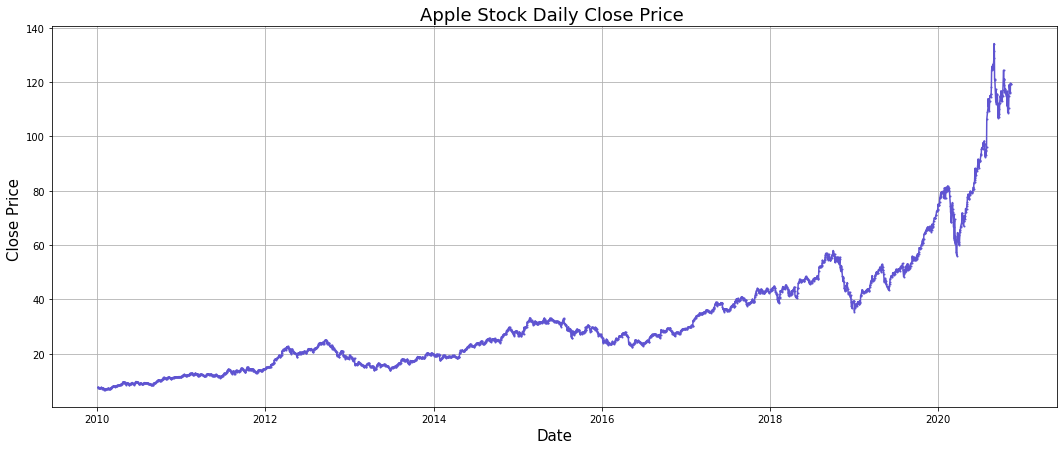

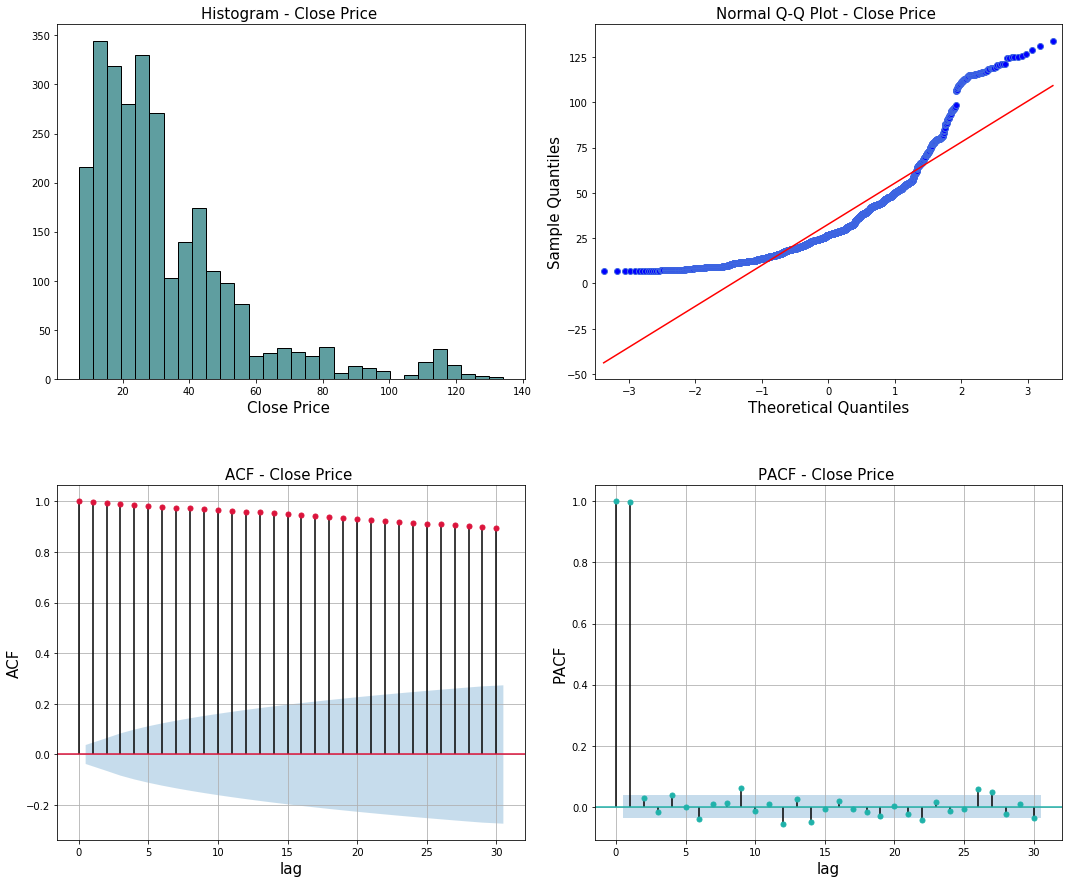

Augmented Dicky-Fuller Test - Apple Stock Daily Close Price 
Test Statistic: 2.9407
5% Critical Value: -2.8626
p-value: 1.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value >= alpha, Failed to reject the Null Hypothesis, the series is NOT Stationary.


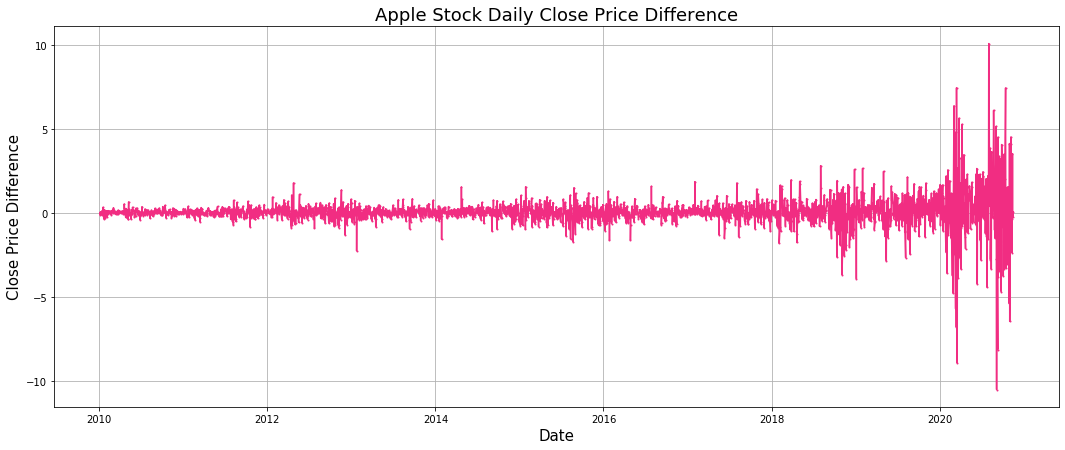

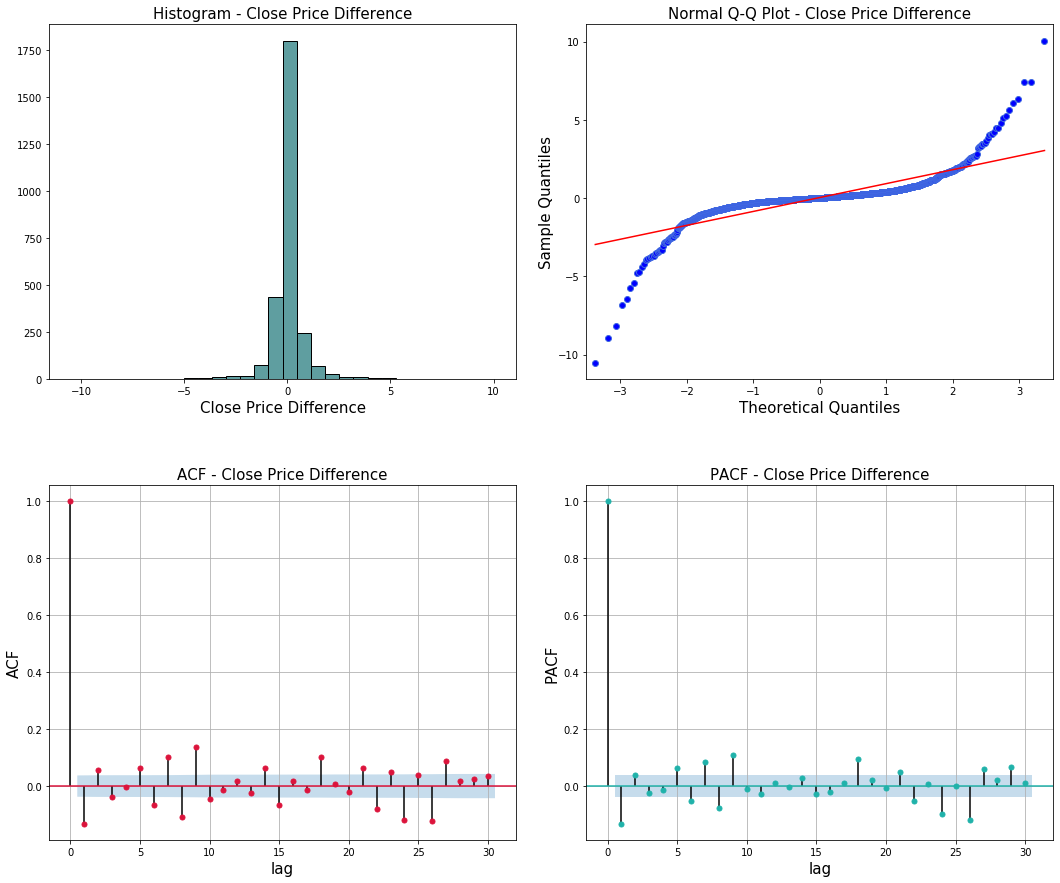

Augmented Dicky-Fuller Test - Apple Stock Daily Close Price Difference
Test Statistic: -9.0907
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.


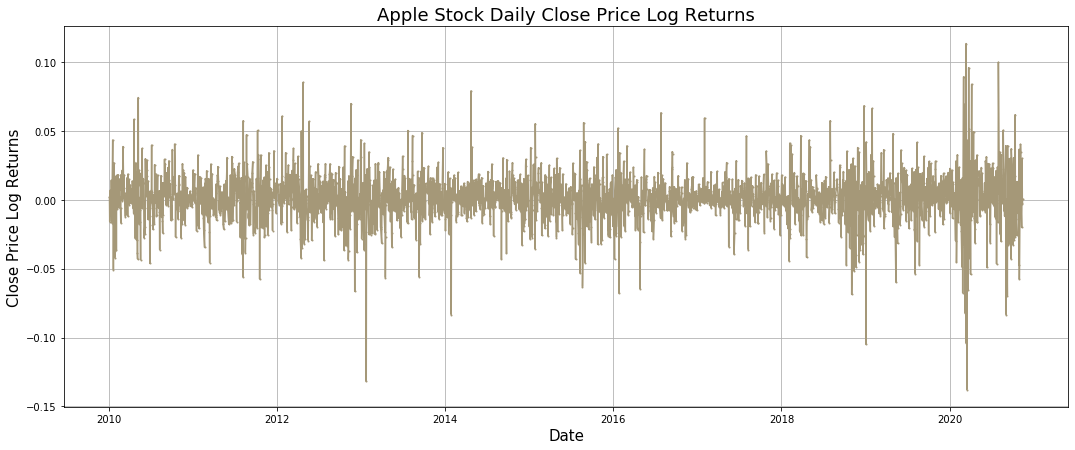

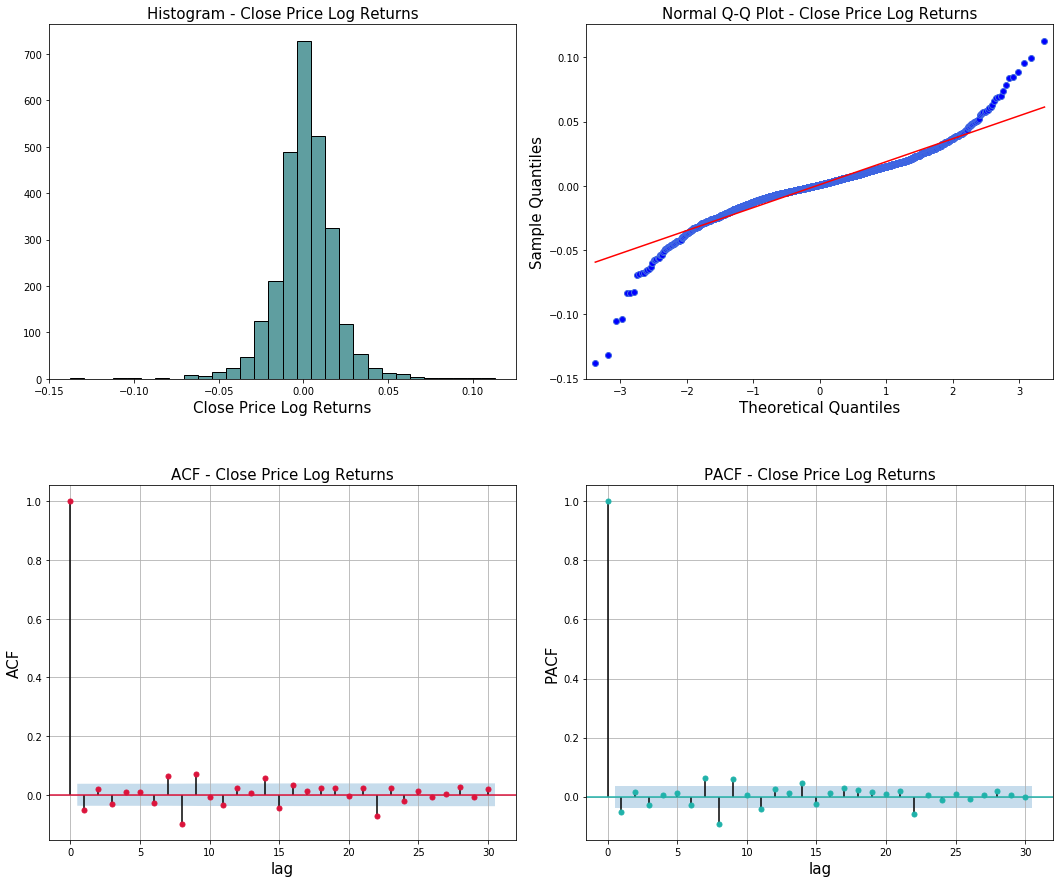

Augmented Dicky-Fuller Test - Apple Stock Daily Close Price Log Returns
Test Statistic: -10.6595
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.

******************************************* Apple Stock Processing Finished *******************************************


************************************************* Processing Microsoft Stock **********************************************


Number of observations: 2737 

Microsoft Stock - Summary Statistics

               Open         High          Low        Close
count  2737.000000  2737.000000  2737.000000  2737.000000
mean     67.066791    67.702575    66.397999    67.085798
std      49.133934    49.709501    48.513149    49.139758
min      23.090000    23.320000    22.730000    23.010000
25%      30.190000    30.400000    29.950000    30.165000
50%      46.790000    47.133900    46.440000    46.800000
75%      92.3900

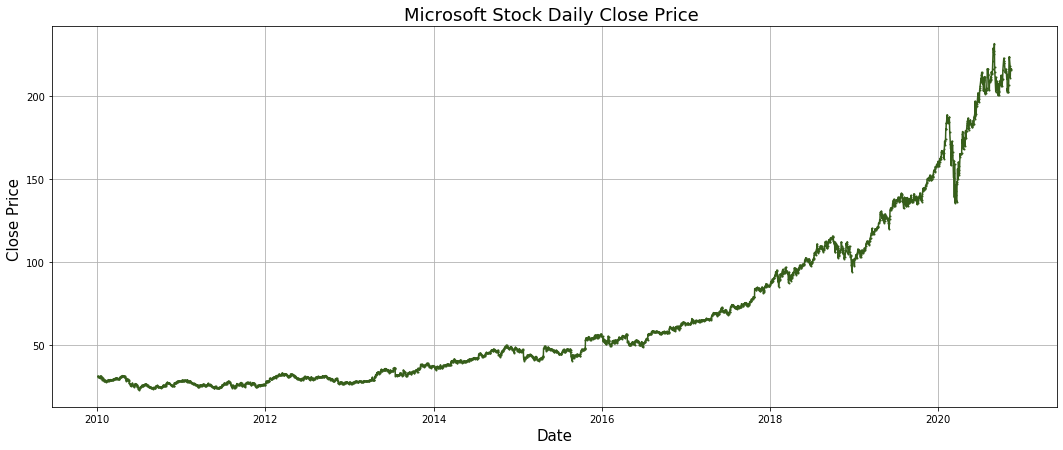

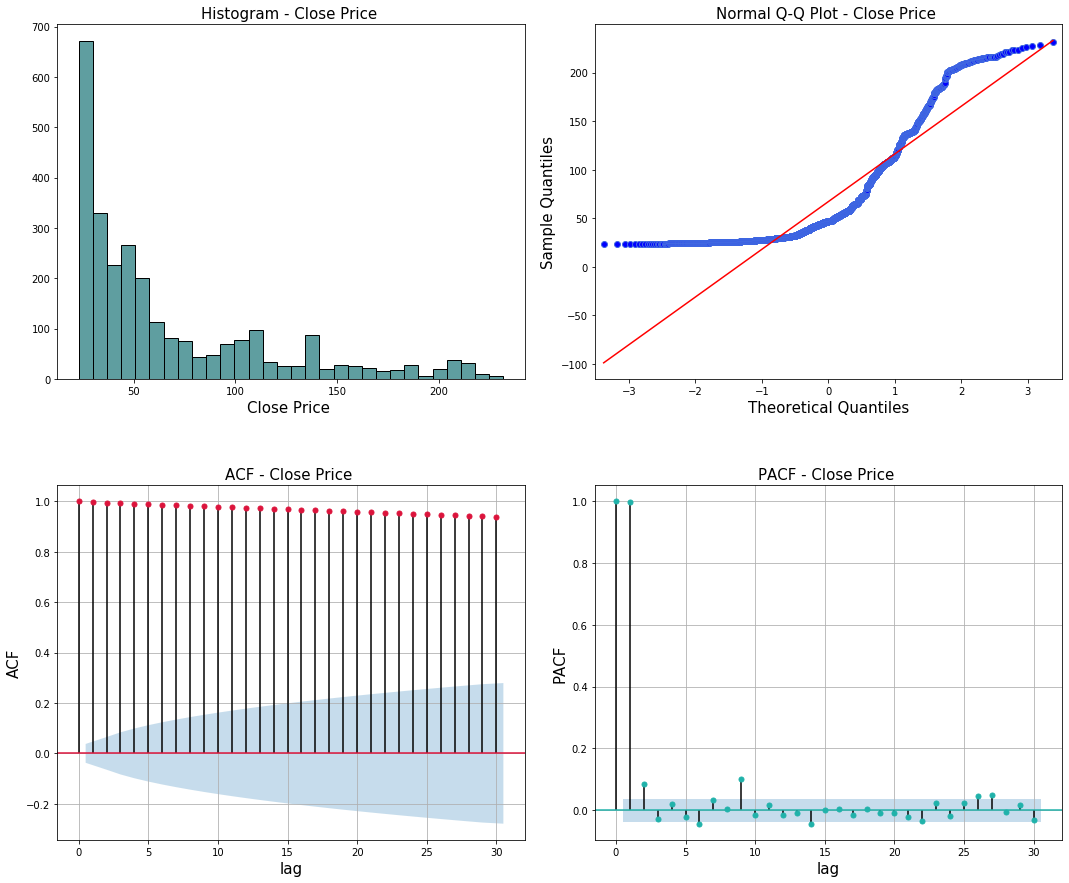

Augmented Dicky-Fuller Test - Microsoft Stock Daily Close Price 
Test Statistic: 4.5130
5% Critical Value: -2.8626
p-value: 1.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value >= alpha, Failed to reject the Null Hypothesis, the series is NOT Stationary.


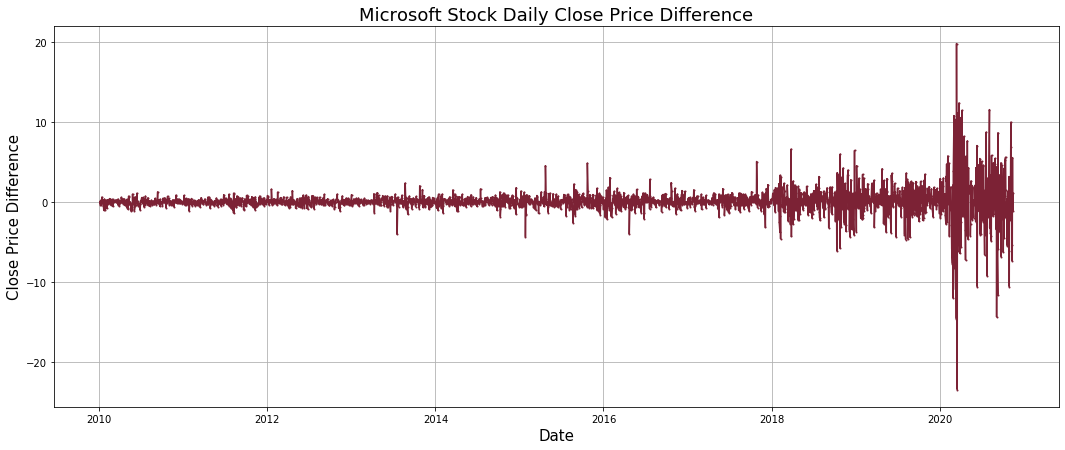

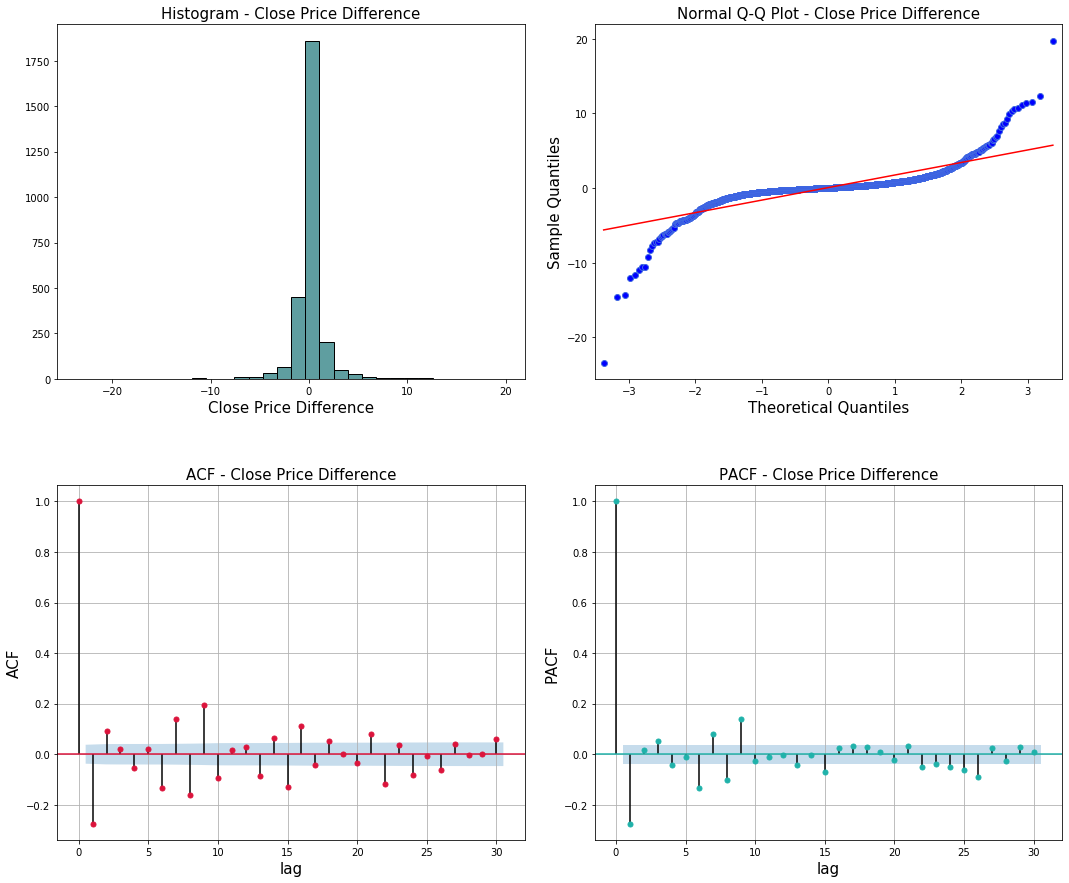

Augmented Dicky-Fuller Test - Microsoft Stock Daily Close Price Difference
Test Statistic: -11.8061
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.


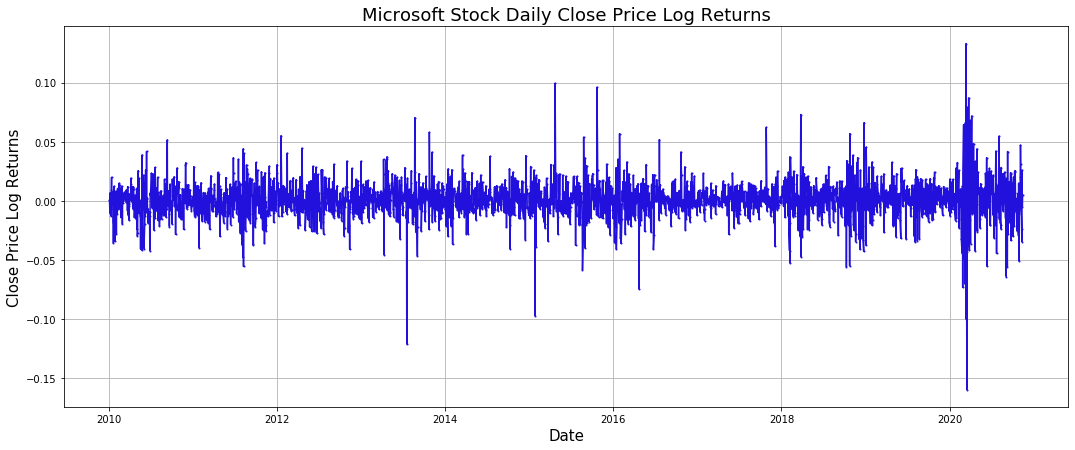

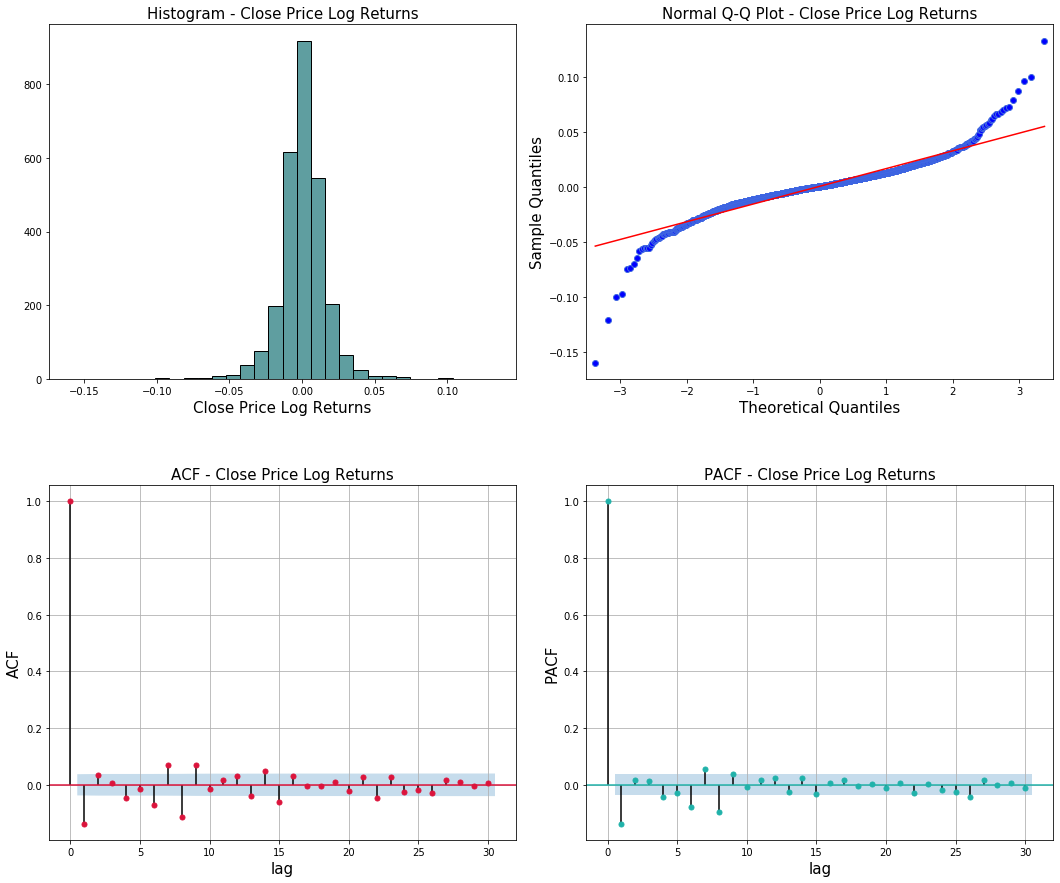

Augmented Dicky-Fuller Test - Microsoft Stock Daily Close Price Log Returns
Test Statistic: -18.9971
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.

******************************************* Microsoft Stock Processing Finished *******************************************


************************************************* Processing S&P 500 Index **********************************************


Number of observations: 2737 

S&P 500 Index - Summary Statistics

               Open         High          Low        Close
count  2737.000000  2737.000000  2737.000000  2737.000000
mean   2058.299463  2068.846259  2046.829328  2058.713771
std     656.408196   659.269030   653.150941   656.235640
min    1027.650000  1032.950000  1010.910000  1022.580000
25%    1410.080000  1416.580000  1403.650000  1410.490000
50%    2045.540000  2056.600000  2035.730000  2045.970000
75%    2638.

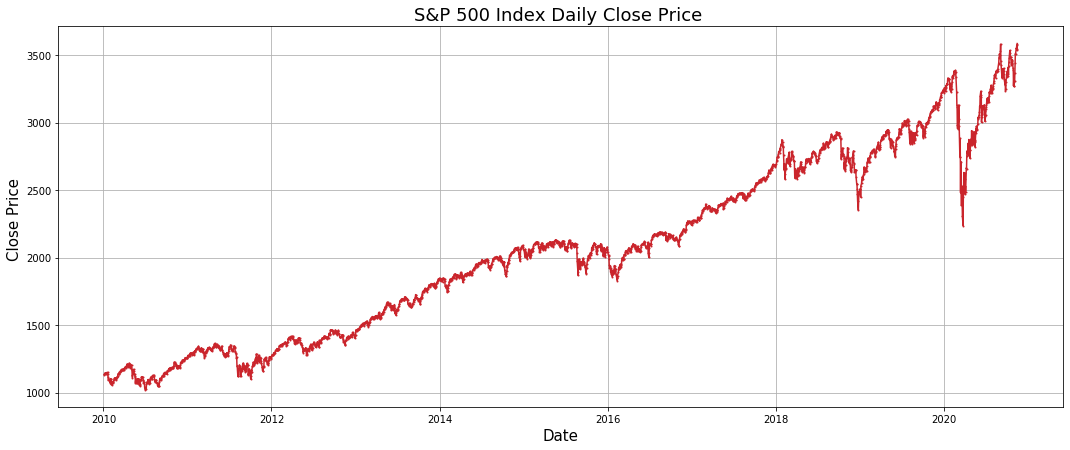

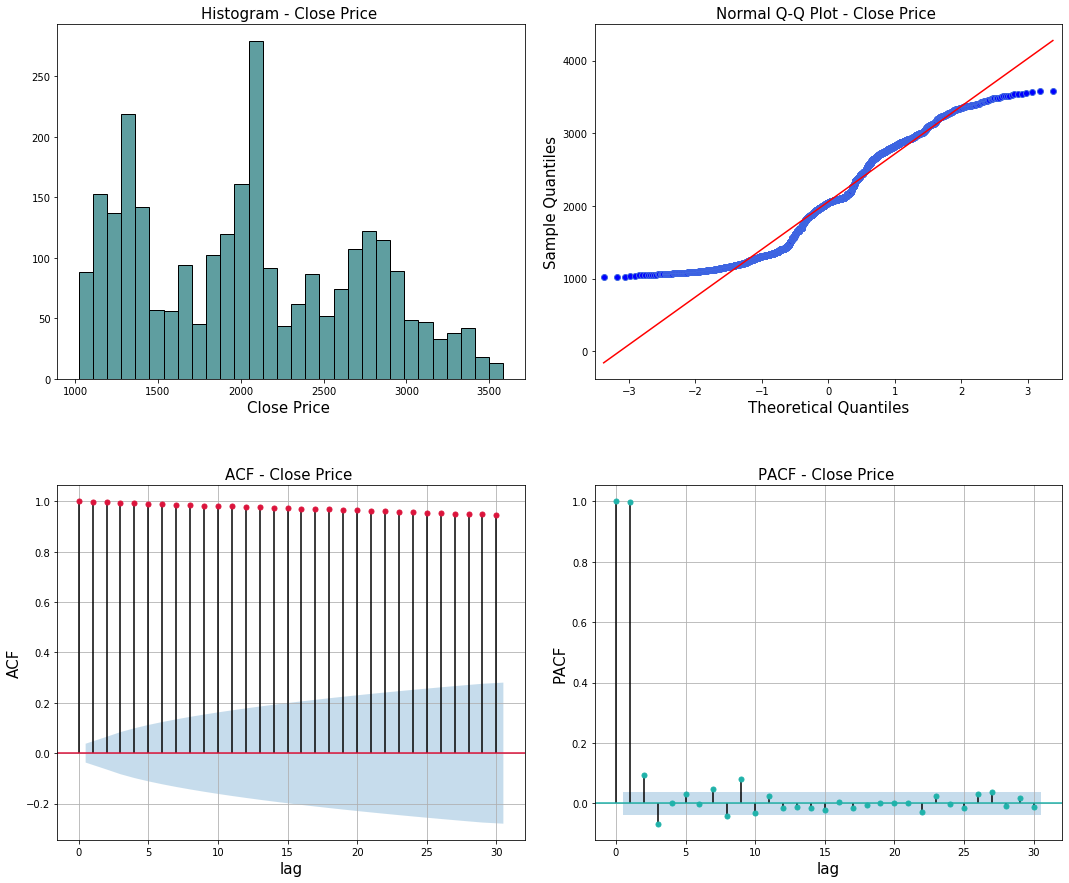

Augmented Dicky-Fuller Test - S&P 500 Index Daily Close Price 
Test Statistic: 0.2406
5% Critical Value: -2.8626
p-value: 0.9744
Signifiance Level (alpha): 0.05
Conclusion: p_value >= alpha, Failed to reject the Null Hypothesis, the series is NOT Stationary.


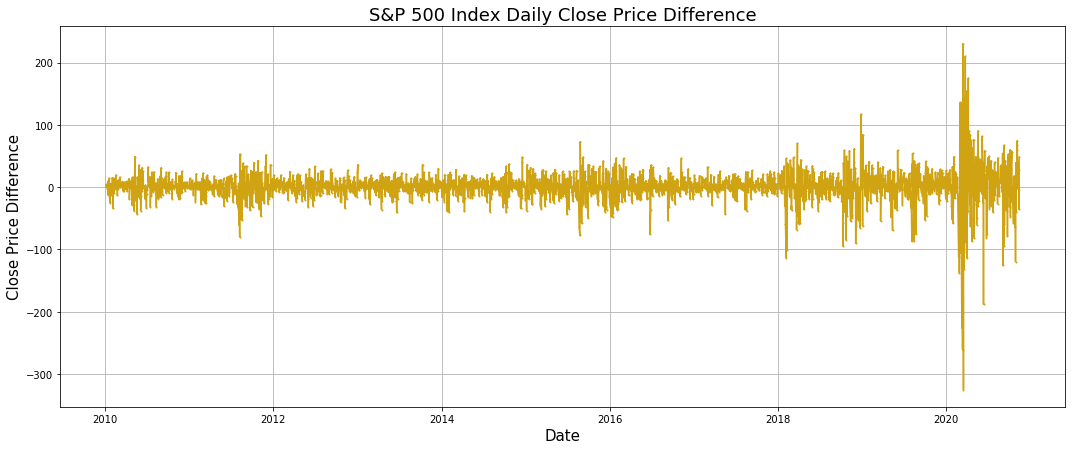

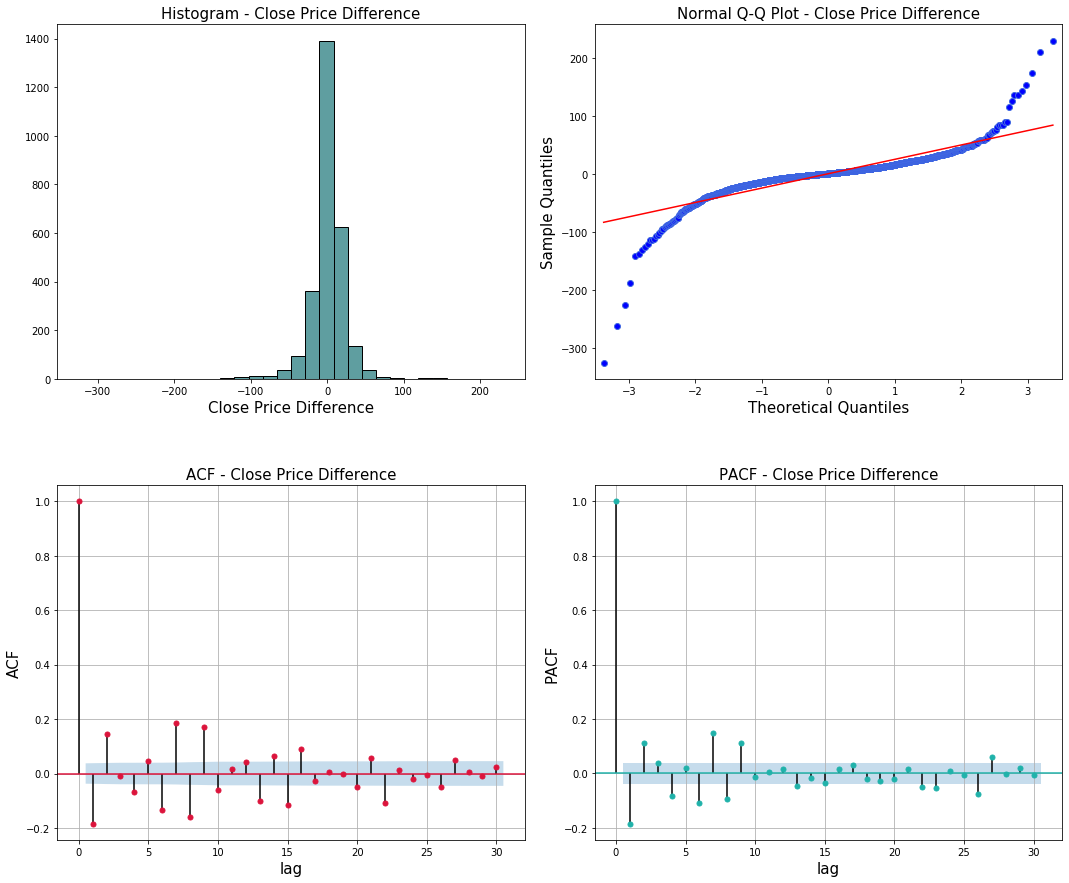

Augmented Dicky-Fuller Test - S&P 500 Index Daily Close Price Difference
Test Statistic: -11.1741
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.


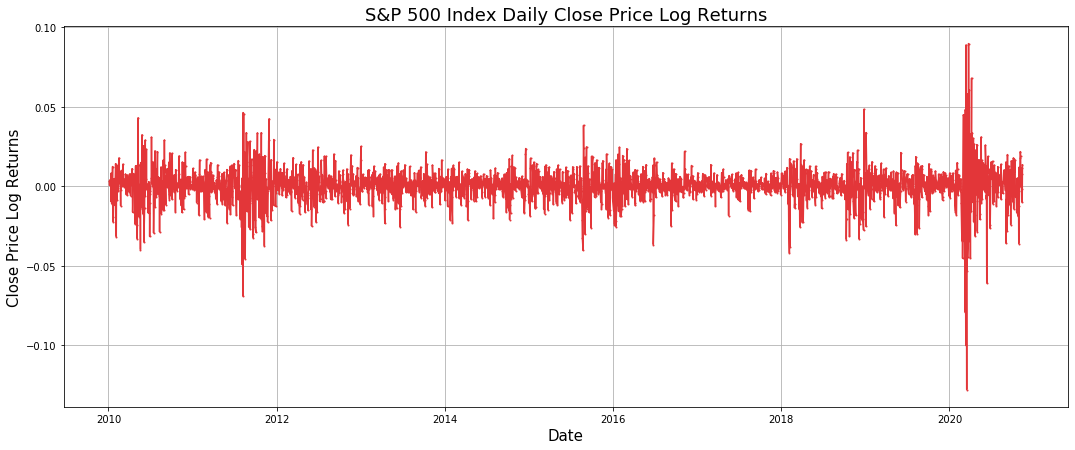

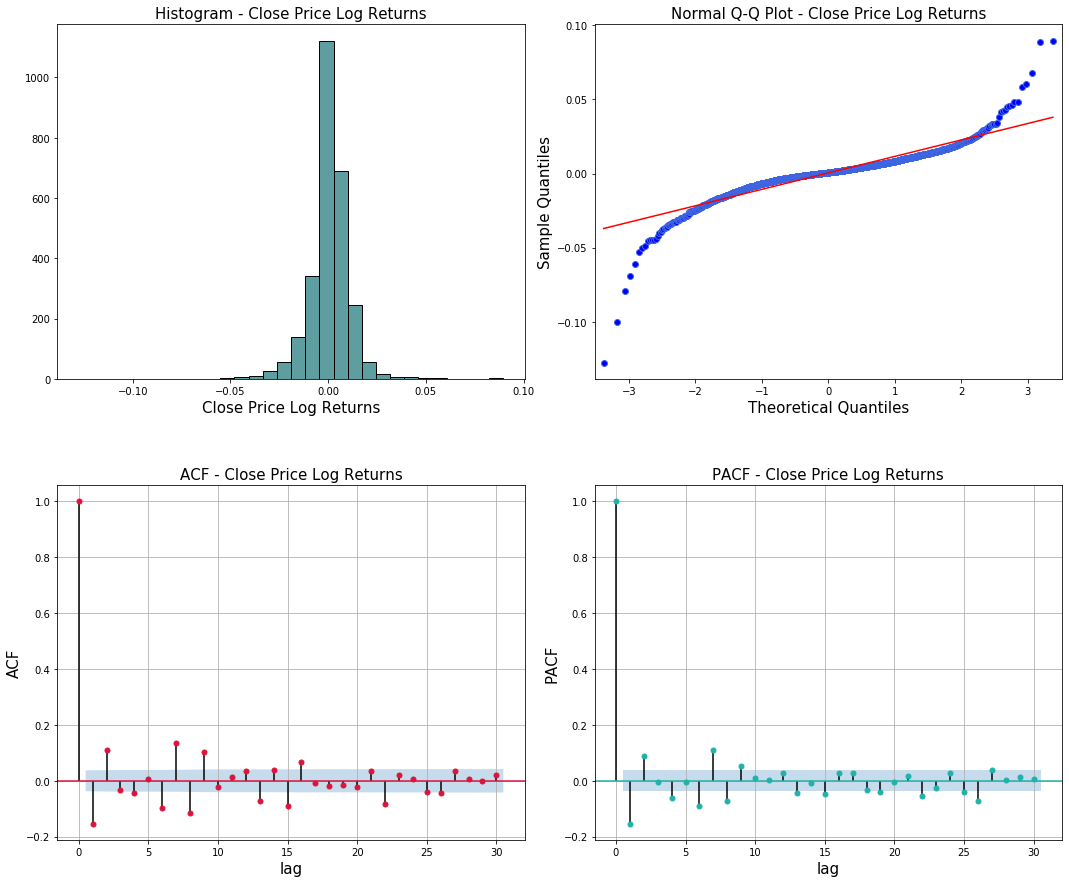

Augmented Dicky-Fuller Test - S&P 500 Index Daily Close Price Log Returns
Test Statistic: -11.5511
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.

******************************************* S&P 500 Index Processing Finished *******************************************


************************************************* Processing Nasdaq 100 Index **********************************************


Number of observations: 2737 

Nasdaq 100 Index - Summary Statistics

                Open          High           Low         Close
count   2737.000000   2737.000000   2737.000000   2737.000000
mean    4771.854322   4802.454023   4739.002068   4773.293336
std     2401.943180   2421.945209   2380.133090   2402.576967
min     1736.250000   1742.360000   1700.040000   1728.340000
25%     2715.710000   2731.350000   2704.910000   2716.140000
50%     4328.720000   4358.090000   4302.040

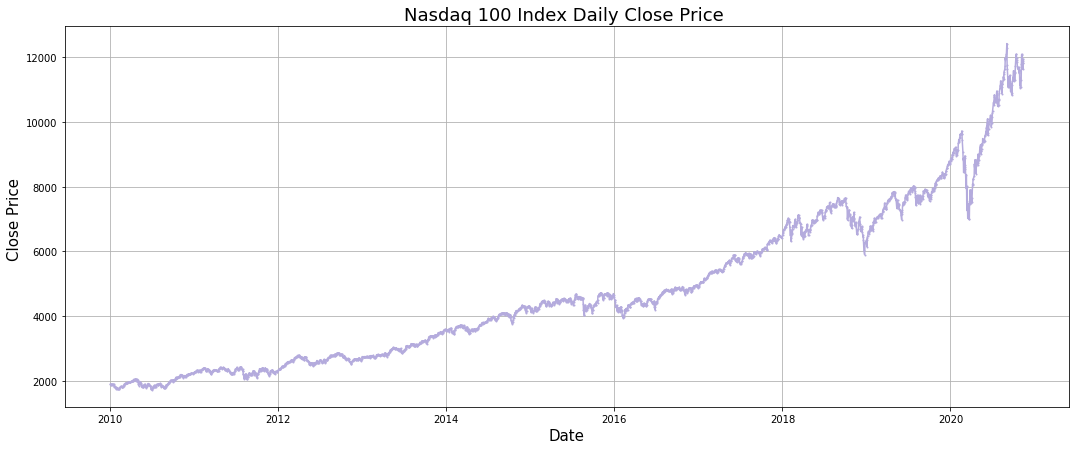

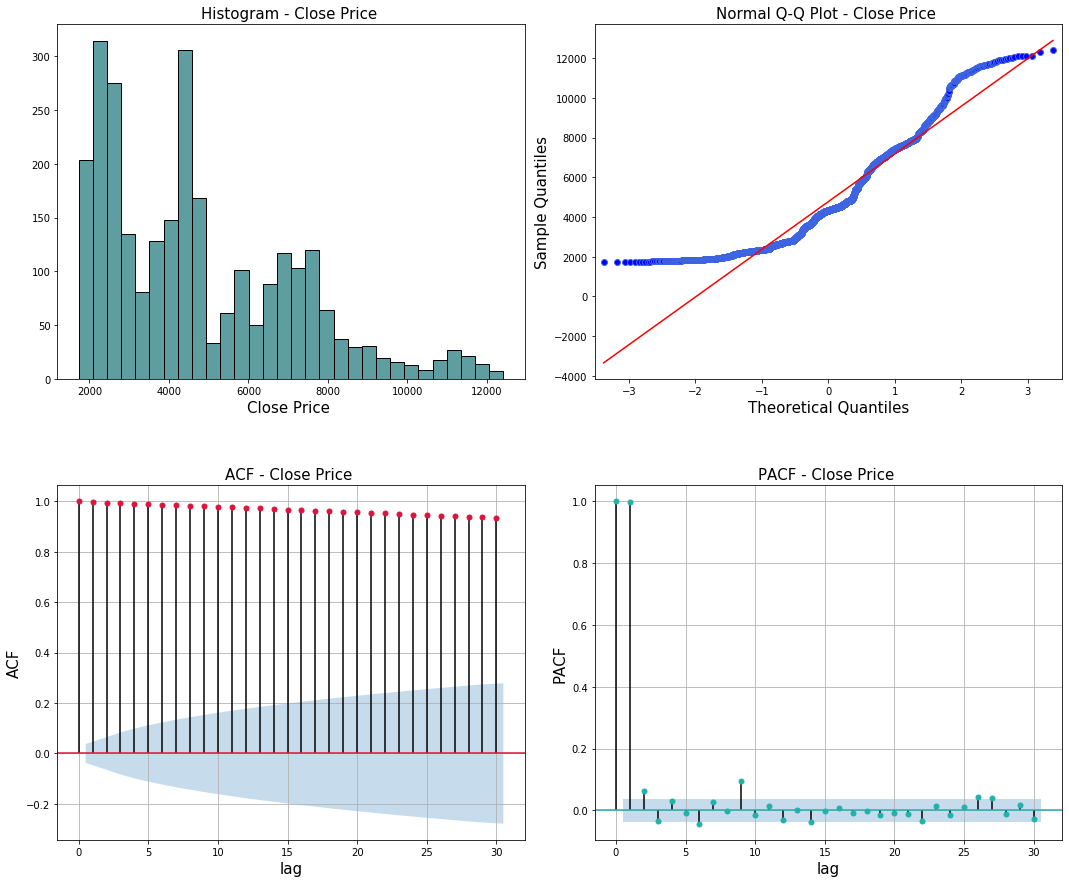

Augmented Dicky-Fuller Test - Nasdaq 100 Index Daily Close Price 
Test Statistic: 2.5263
5% Critical Value: -2.8626
p-value: 0.9991
Signifiance Level (alpha): 0.05
Conclusion: p_value >= alpha, Failed to reject the Null Hypothesis, the series is NOT Stationary.


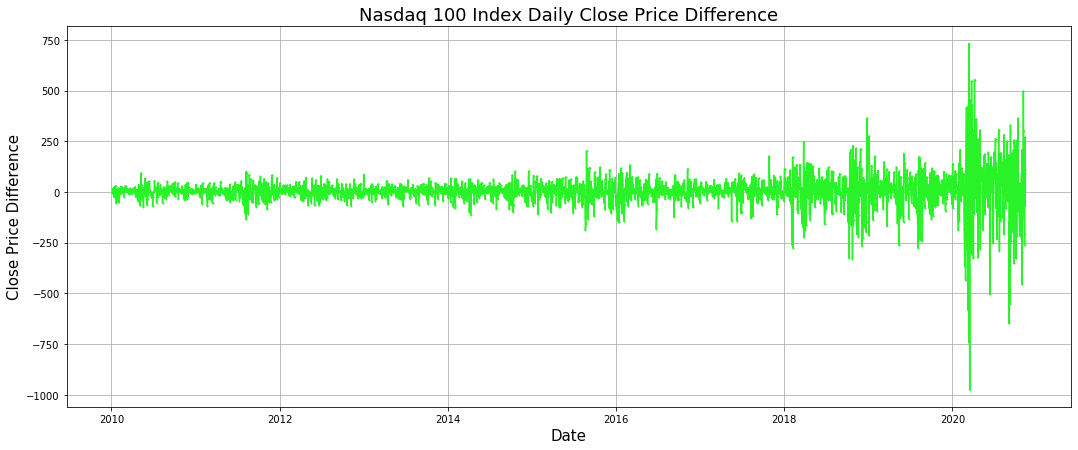

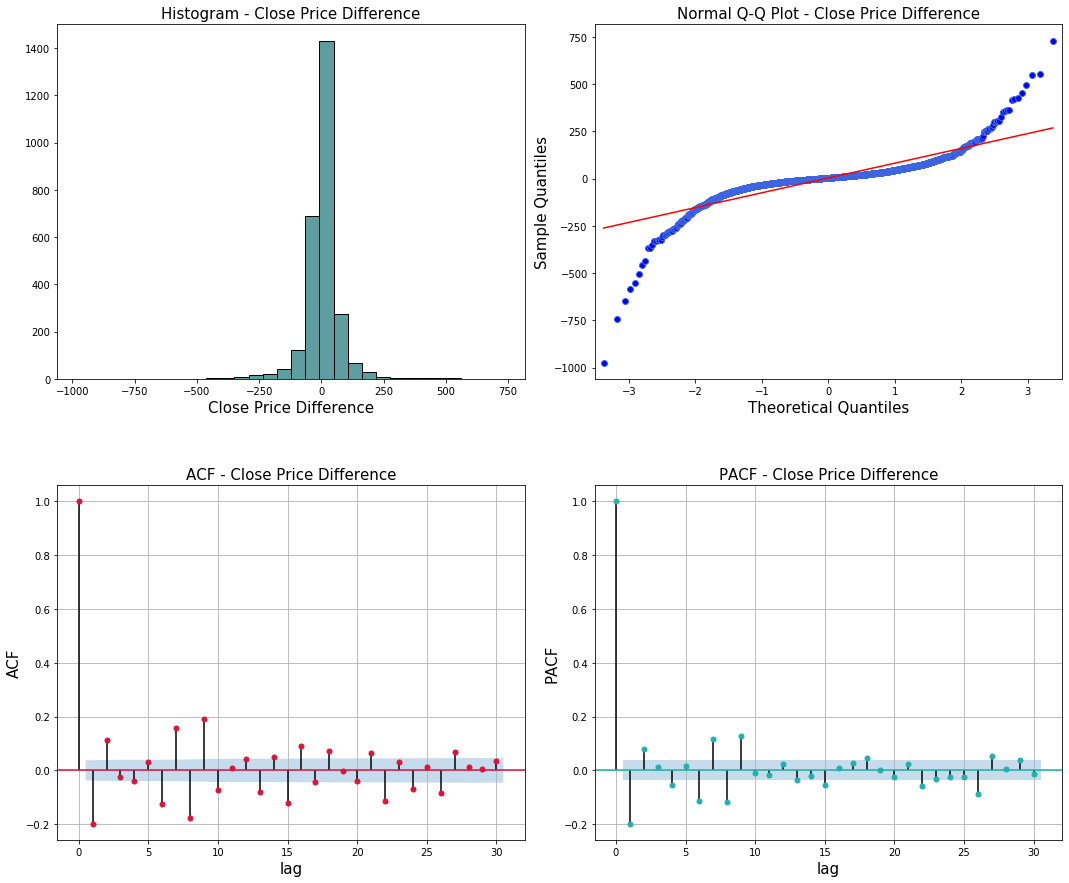

Augmented Dicky-Fuller Test - Nasdaq 100 Index Daily Close Price Difference
Test Statistic: -10.3013
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.


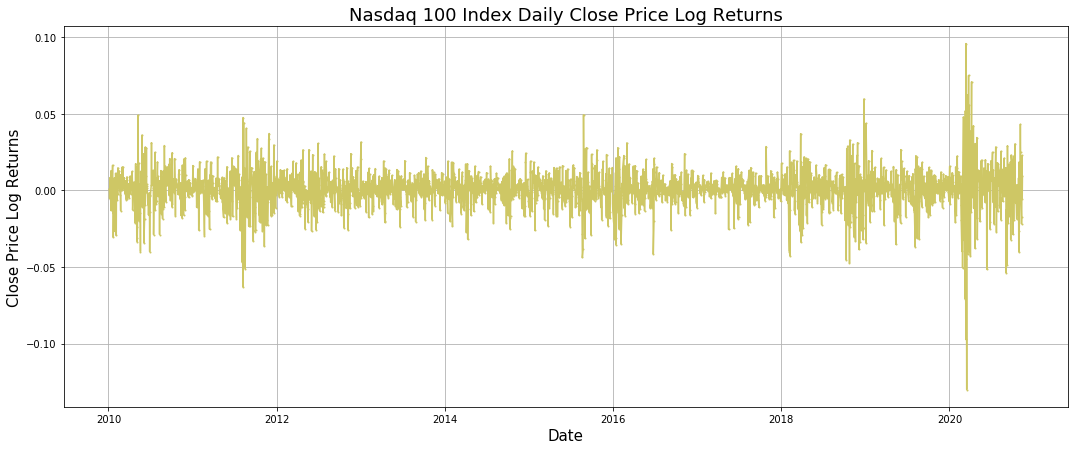

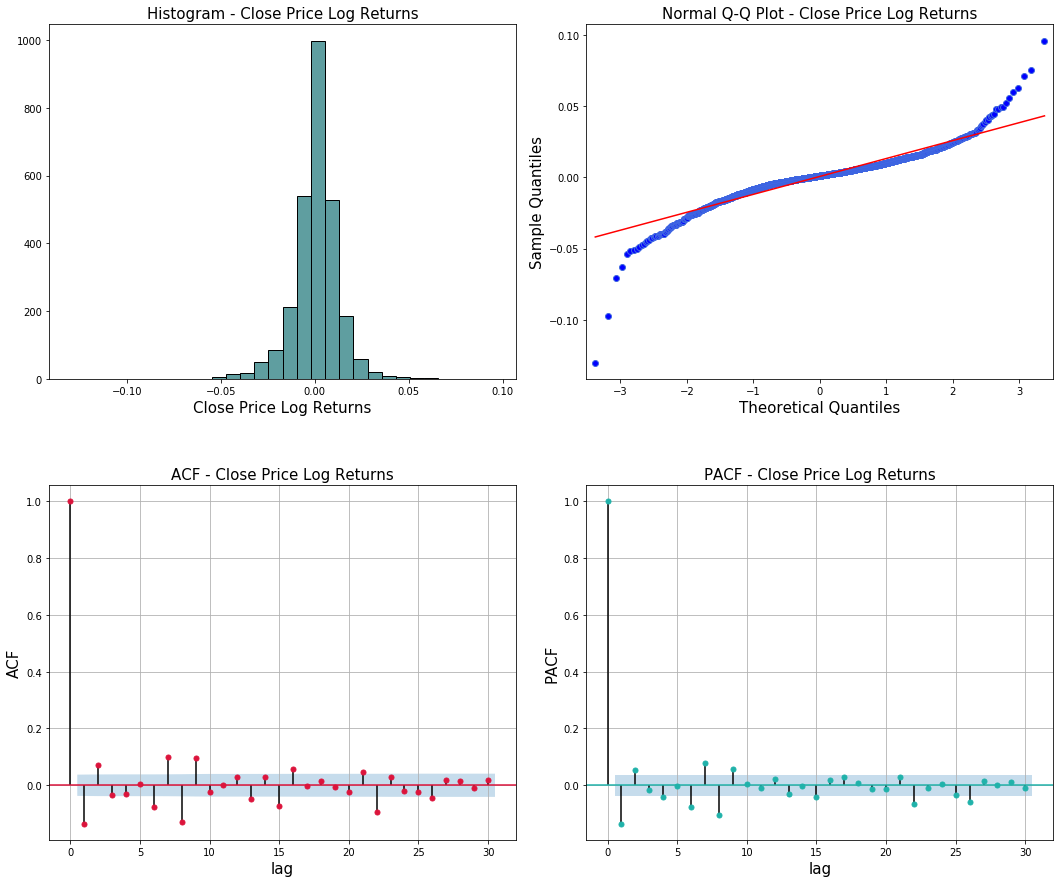

Augmented Dicky-Fuller Test - Nasdaq 100 Index Daily Close Price Log Returns
Test Statistic: -12.0695
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.

******************************************* Nasdaq 100 Index Processing Finished *******************************************



In [6]:
# Display Synopsis, Plot Price, ACF & PACF Charts and do Augmented Dicky-Fuller Test for Price, Price Difference and Log Returns

for security in dfs_price:
    header = header_prefix + security + header_suffix
    print(header)

    df_price = dfs_price[security]
    df_price_diff = dfs_price_diff[security]
    df_log_returns = dfs_log_return[security]

    # Display Synopsis
    describe_and_peek(df_price, security)

    # Price
    display_insight_charts(df_price, security, "")
    augmented_dicky_fuller_test(df_price, security, "")

    # First Order Difference of Price
    display_insight_charts(df_price_diff, security, "Difference")
    augmented_dicky_fuller_test(df_price_diff, security, "Difference")

    # Daily Logarithmic Return
    display_insight_charts(df_log_returns, security, "Log Returns")
    augmented_dicky_fuller_test(df_log_returns, security, "Log Returns")
    
    footer = footer_prefix + security + footer_suffix
    print(footer)

# Price Prediction using Classical Time Series Models

In [7]:
# Displays Diagnostic Plots of the Residuals or Residuals Square
def residual_diagnostic(data, security_name, series_type):
    title = security_name + " Daily " + price_type + " Price - " + series_type + " - Diagnostic Plots"

    plt.figure(figsize=(18, 7))
    plt.plot(data, "-o", ms='1', color=np.random.rand(3,))
    plt.title(title, fontsize=18)
    plt.ylabel(series_type, fontsize=15)
    plt.grid(True)
    plt.show()
    
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(18, 15))
    plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
    h_max = 30
    
    ax[0, 0].hist(data, bins = 60, color='cadetblue', ec='black')
    ax[0, 0].set_title("Histogram - " + series_type, fontsize=15)
    ax[0, 0].set_xlabel(series_type, fontsize=15)
    
    qqplot(data, ax=ax[0, 1], line='s', color='royalblue')
    ax[0, 1].set_title('Normal Q-Q Plot - ' + series_type, fontsize=15)
    ax[0, 1].set_xlabel("Theoretical Quantiles", fontsize=15)
    ax[0, 1].set_ylabel("Sample Quantiles", fontsize=15)
 
    plot_acf(data, ax=ax[1, 0], lags=h_max, color='crimson')
    ax[1, 0].set_title("ACF - " + series_type, fontsize=15)
    ax[1, 0].set_xlabel("lag", fontsize=15)
    ax[1, 0].set_ylabel("ACF", fontsize=15)
    ax[1, 0].grid(True)

    plot_pacf(data, ax=ax[1, 1], lags=h_max, color='lightseagreen')
    ax[1, 1].set_title("PACF - " + series_type, fontsize=15)
    ax[1, 1].set_xlabel("lag", fontsize=15)
    ax[1, 1].set_ylabel("PACF", fontsize=15)
    ax[1, 1].grid(True)
    plt.show();

# Plots Actual, Fitted, Predicted Values and Confidence Intervals of the Predictions
def plot_original_fitted_pred(title, dates, actual, dates_train, fitted, dates_test, predictions, conf_int=None):
    plt.figure(figsize=(18, 7))
       
    # Plot Actual Values
    plt.plot(dates, actual, color='crimson', label = "Actual")
    
    # Plot Fitted Values
    plt.plot(dates_train, fitted, color='blue', label="Fitted")
    
    # Plot Separator Line
    plt.axvline(x=len(dates_train), linestyle='--', alpha=.2, color='k')
    
    # Plot Predicted Values
    plt.plot(dates_test, predictions, color='orange', label="Predicted")
    
    # Fill Prediction Region
    if conf_int is not None:
        max_y = max(max(actual), max(fitted), max(predictions), max(conf_int[:,0]), max(conf_int[:,1]))*1.05
    else:
        max_y = max(max(actual), max(fitted), max(predictions))*1.05
    plt.fill_between(range(len(dates_train), len(dates)), -10, max_y, color='pink', alpha=.3)
    
    # Plot Prediction Confidence Interval
    if conf_int is not None:
        pred_date_range = range(len(dates_train), len(dates))
        plt.fill_between(pred_date_range, conf_int[:,0], conf_int[:,1], color='cyan', alpha=.3, label="95% Prediction Conf Int")
 
    plt.title(title, fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Close Price", fontsize=15)
    plt.xticks(dates[::250])
    plt.legend(fontsize=12) 
    plt.show();

### ARIMA Model (Optimal AR, MA and Differencing Orders Found in Automated Manner)

In [8]:
# Find optimal orders for SARIMA model
class Auto_Arima():
    def __init__(self, df, start_p=1, start_q=1, max_p=10, max_q=10, seasonal=False, information_criterion='aic'):
        self.df = df
        self.start_p = start_p
        self.start_q = start_q
        self.max_p = max_p
        self.max_q = max_q
        self.seasonal = seasonal
        self.information_criterion = information_criterion

    def arima_results(self):
        return pm.auto_arima(self.df, start_p=self.start_p, start_q=self.start_q, max_p=self.max_p, max_q=self.max_q,
                             seasonal=self.seasonal, information_criterion=self.information_criterion, trace = False,
                             error_action = 'ignore', suppress_warnings=True, stepwise = True, scoring = 'mse')

In [9]:
def arima_model(df_price, scalers, security, price_type):
    model_name = "ARIMA Model"
    
    print("-------------------------------------------------", model_name, "-----------------------------------------------\n")
    
    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Split Into Train and Test Sets
    price_all = df_price[price_type]
    price_train = df_price[price_type][:-test_size]
    price_test = df_price[price_type][-test_size:]
    scaler = scalers[price_type]

    # Extract dates
    dates_all = df_price.index.format()
    dates_train = df_price.head(training_size).index.format()
    dates_test = df_price.tail(test_size).index.format()

    print("Training the model ...")

    # Fit model with auto-arima
    arima_model = Auto_Arima(price_train)
    model_fit = arima_model.arima_results()

    print("Training completed!\n")

    # Print the model summary
    print(model_fit.summary())    

    # Plot residuals diagnostics plots
    residuals = model_fit.resid()
    residual_diagnostic(residuals, security, "ARIMA Fit Residuals")
    residual_diagnostic(residuals**2, security, "ARIMA Fit Residuals Square")  
    
    # Use the model to find fitted values and convert to origianl scale
    price_fitted = scaler.inverse_transform(model_fit.predict_in_sample().reshape(-1, 1))

    # Use the model to predict for the test data and convert to origianl scale
    price_predicted, conf_int = model_fit.predict(n_periods=test_size, return_conf_int=True)
    price_predicted = scaler.inverse_transform(price_predicted.reshape(-1, 1))
    conf_int = scaler.inverse_transform(conf_int)
    
    # Convert all prices and test prices to the origianl scale
    price_all = scaler.inverse_transform(price_all.values.reshape(-1, 1))
    price_test = scaler.inverse_transform(price_test.values.reshape(-1, 1))
    
    # Plot Original, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title,
                              dates_all, price_all,
                              dates_train, price_fitted,
                              dates_test, price_predicted,
                              conf_int)

    return "ARIMA", dates_test, price_test, price_predicted, mean_squared_error(price_test, price_predicted)

### AR-ARCH Model

In [10]:
def ar_arch_model(df_price, scalers, security, price_type):
    model_name = "AR ARCH Model"
    
    print("-----------------------------------------------", model_name, "-------------------------------------------------\n")

    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Split Into Train and Test Sets
    price_all = df_price[price_type]
    price_train = df_price[price_type][:-test_size]
    price_test = df_price[price_type][-test_size:]
    scaler = scalers[price_type]

    # Extract dates
    dates_all = df_price.index.format()
    dates_train = df_price.head(training_size).index.format()
    dates_test = df_price.tail(test_size).index.format()

    print("Training the model ...")
    print("Trying order combinations to find the best combination...")
    
    # Find best lags, p and q values
    min_aic = np.inf
    best_orders = None
    best_model = None
    
    for lags in range(10):
        for p in range(1, 10):
            for q in range(10):
                model_fit = arch_model(price_train, mean='AR', lags=lags, vol='ARCH', p=p, q=q).fit(disp='off')
                aic = model_fit.aic
                if aic < min_aic:
                    min_aic = aic
                    best_orders = (lags, p, q)
                    best_model = model_fit

    print("Best Lags Value:", best_orders[0])
    print("Best p Value:", best_orders[1])
    print("Best q Value:", best_orders[2])
    print("Training completed!\n")

    # Print the best model summary
    print(best_model.summary())

    # Plot residuals diagnostics plots
    residuals = model_fit.resid.dropna()
    residual_diagnostic(residuals, security, "AR ARCH Fit Residuals")
    residual_diagnostic(residuals**2, security, "AR ARCH Fit Residuals Square")    
    
    # arch_model doesn't provide fitted values, so using actual values
    price_fitted = scaler.inverse_transform(price_train.values.reshape(-1, 1))
    
    # Use the model to predict for the test data and convert to origianl scale
    forecast_results = best_model.forecast(horizon=test_size)
    forecast_mean = forecast_results.mean.values[-1, :].reshape(-1, 1)
    forecast_variance = forecast_results.variance.values[-1, :].reshape(-1, 1)
    
    price_predicted = scaler.inverse_transform(forecast_mean)
    conf_int_left = scaler.inverse_transform(forecast_mean - 1.96*np.sqrt(forecast_variance)).ravel()
    conf_int_right = scaler.inverse_transform(forecast_mean + 1.96*np.sqrt(forecast_variance)).ravel()
    
    conf_int = np.array([conf_int_left, conf_int_right]).transpose()
    
    # Convert all prices and test prices to the origianl scale
    price_all = scaler.inverse_transform(price_all.values.reshape(-1, 1))
    price_test = scaler.inverse_transform(price_test.values.reshape(-1, 1))
    
    # Plot Original, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title,
                              dates_all, price_all,
                              dates_train, price_fitted,
                              dates_test, price_predicted,
                              conf_int)

    return "AR ARCH", dates_test, price_test, price_predicted, mean_squared_error(price_test, price_predicted)

### Run all the Classical Time Series Models and Display Results of Individual Models

In [11]:
# Dictionary to store the mse results of all the models
mse_values = {}

# Perecentage training size
training_percentage = 0.9


************************************************* Processing Apple Stock **********************************************

Classical Time Series Models: Total Size: 2737 Training Size: 2463 Test Size: 274


------------------------------------------------- ARIMA Model -----------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1074.556
Date:                Mon, 14 Dec 2020   AIC                           2153.112
Time:                        04:56:08   BIC                           2164.730
Sample:                             0   HQIC                          2157.333
                               - 2463                                         
Covariance Type:                  

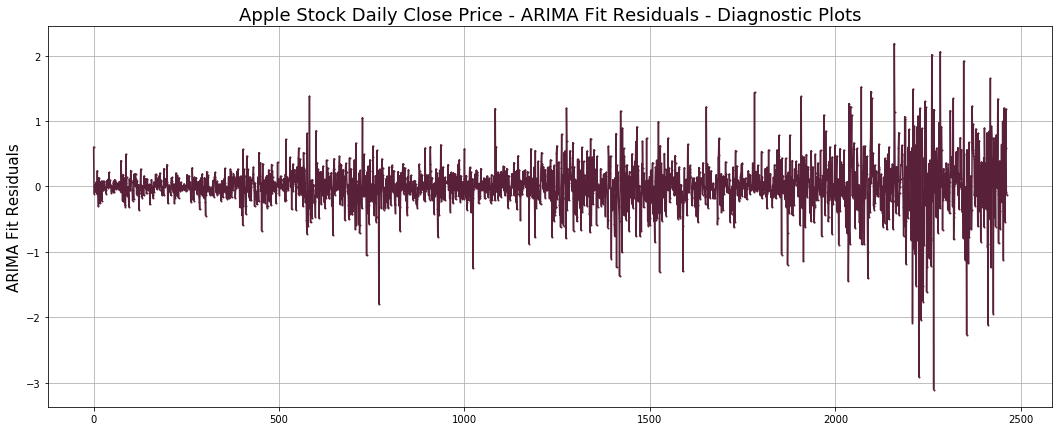

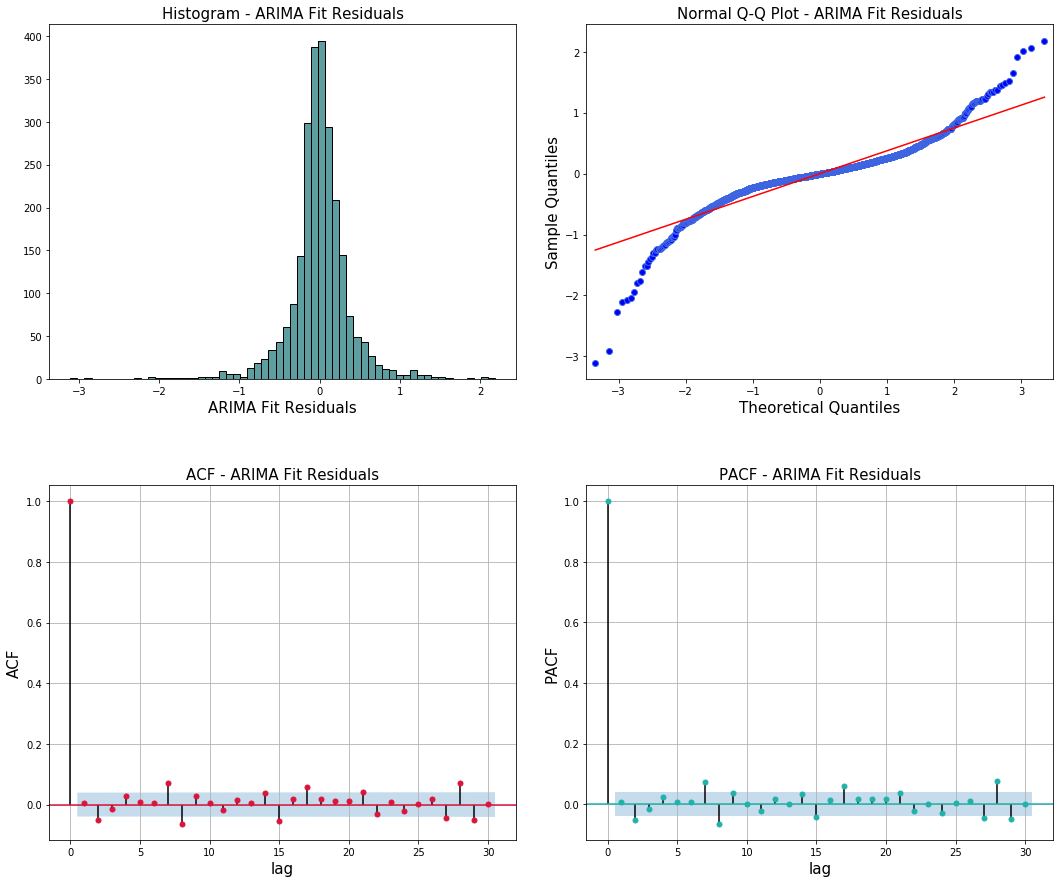

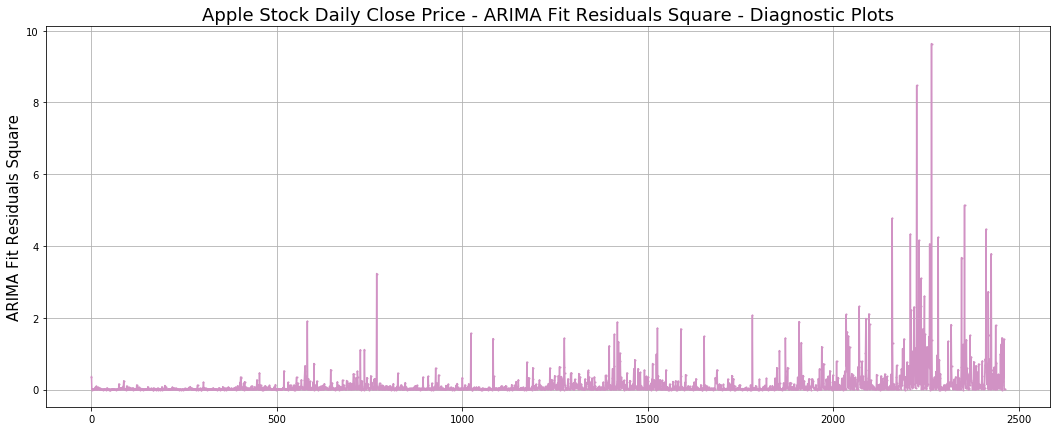

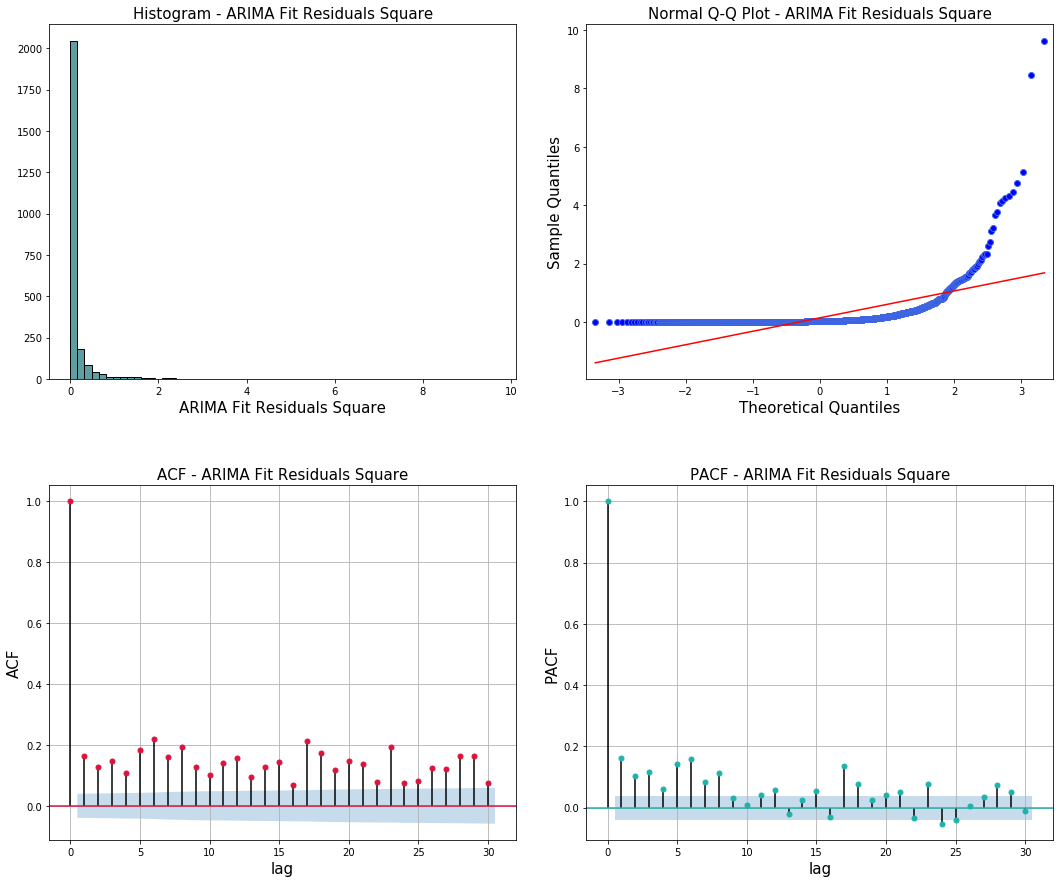

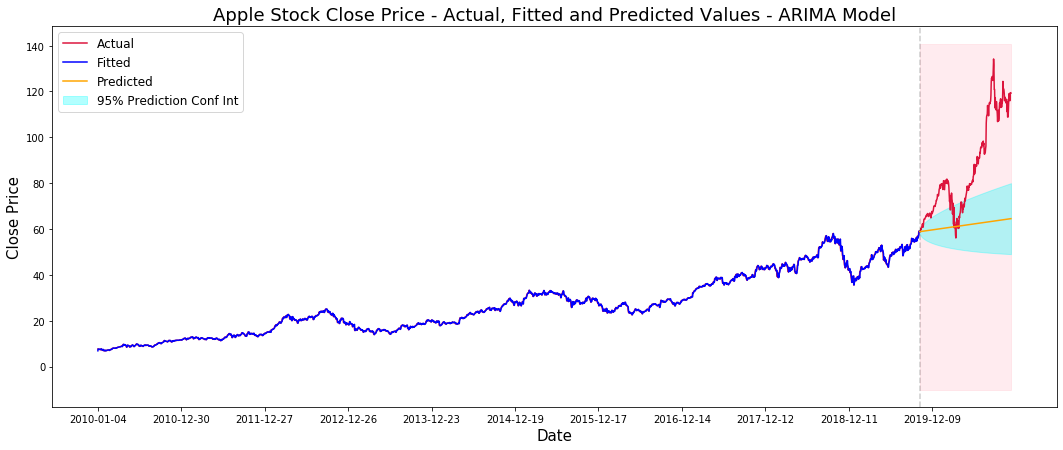

----------------------------------------------- AR ARCH Model -------------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Trying order combinations to find the best combination...
Best Lags Value: 1
Best p Value: 9
Best q Value: 0
Training completed!

                           AR - ARCH Model Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Mean Model:                        AR   Adj. R-squared:                  0.999
Vol Model:                       ARCH   Log-Likelihood:               -530.282
Distribution:                  Normal   AIC:                           1084.56
Method:            Maximum Likelihood   BIC:                           1154.27
                                        No. Observations:                 2462
Date:                Mon, Dec 14 2020   Df Residuals:                     2450
Time:                        04:56:22   Df Model: 

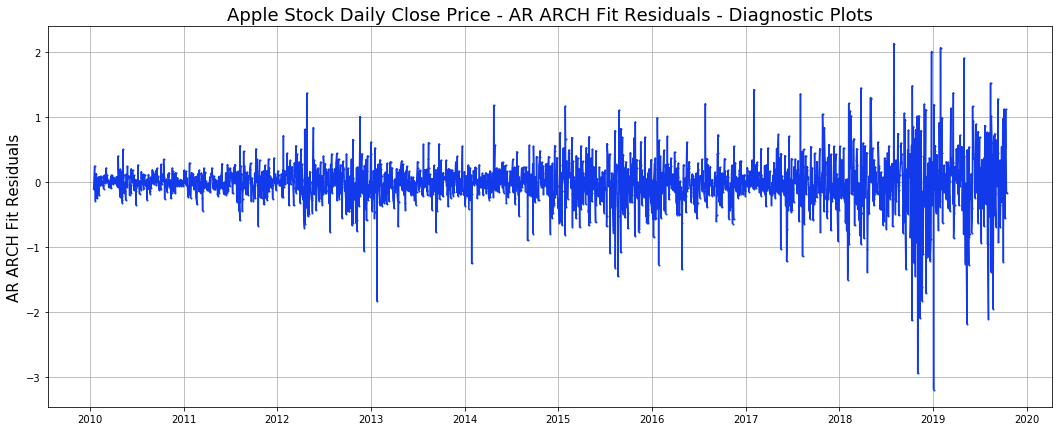

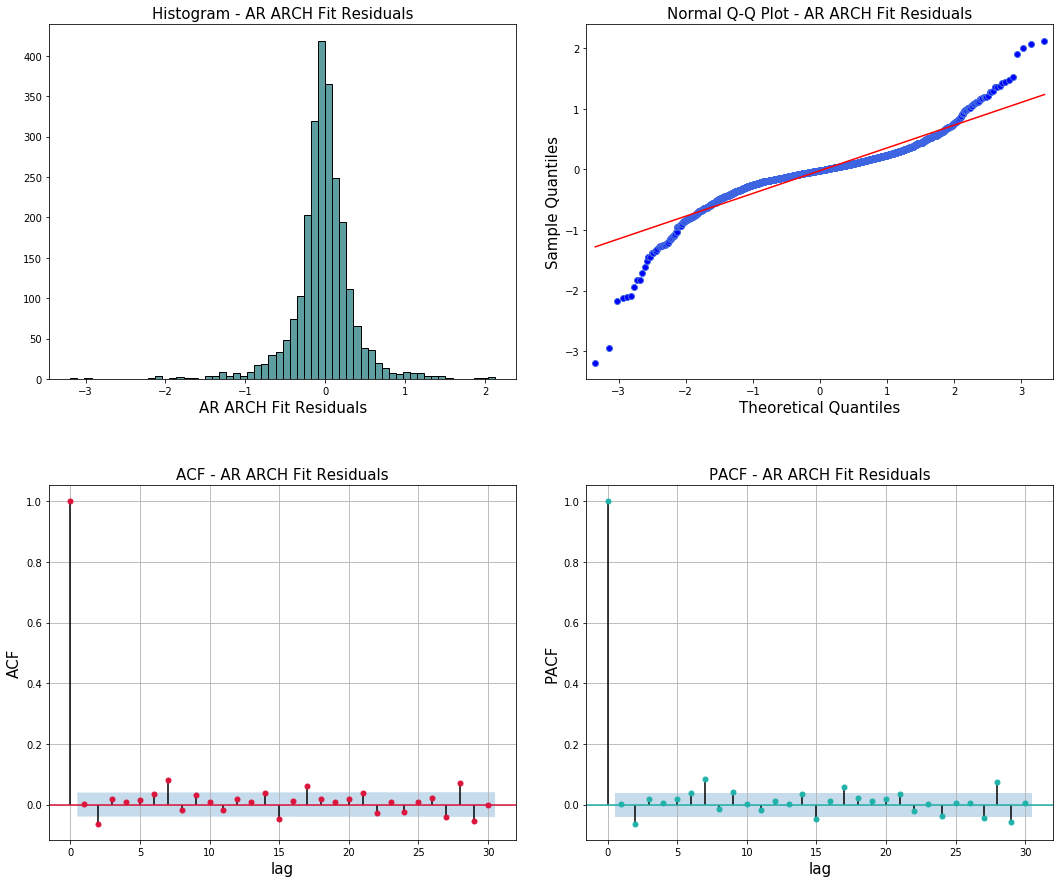

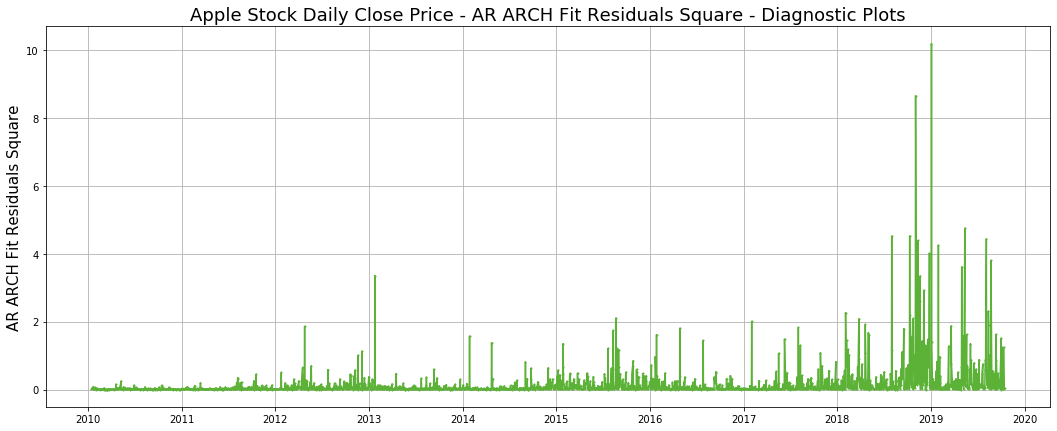

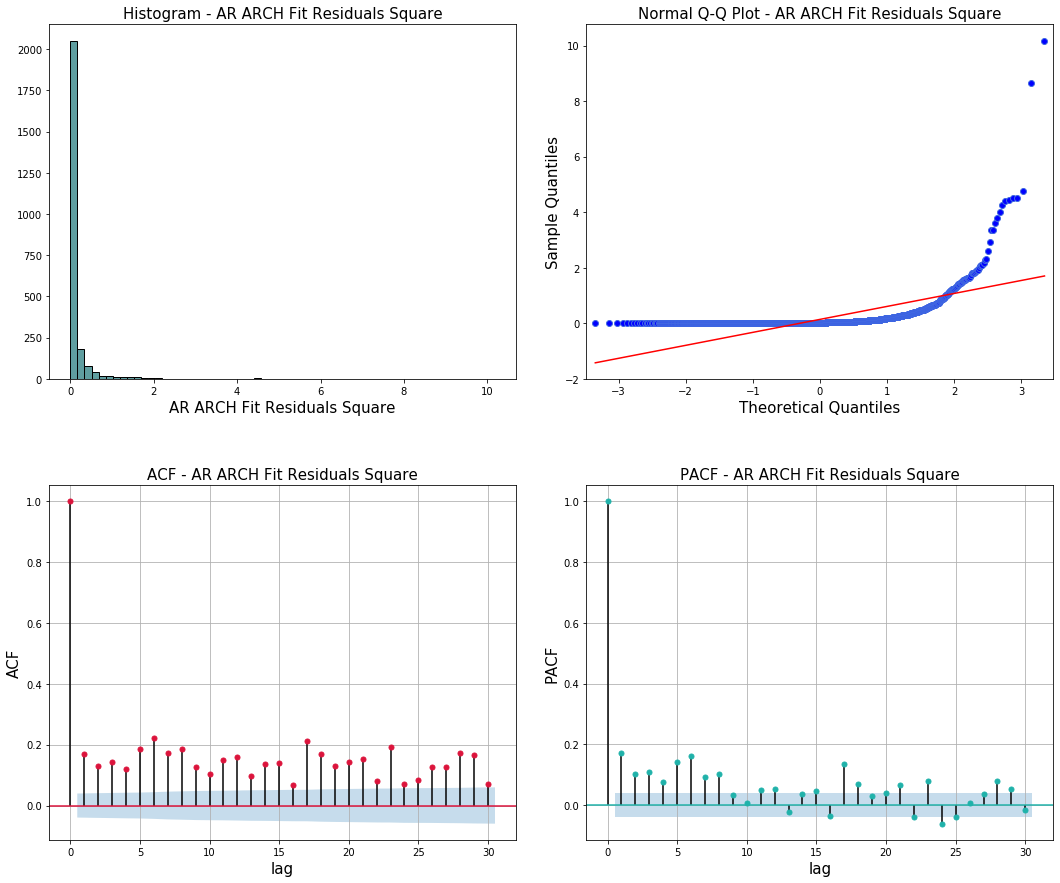

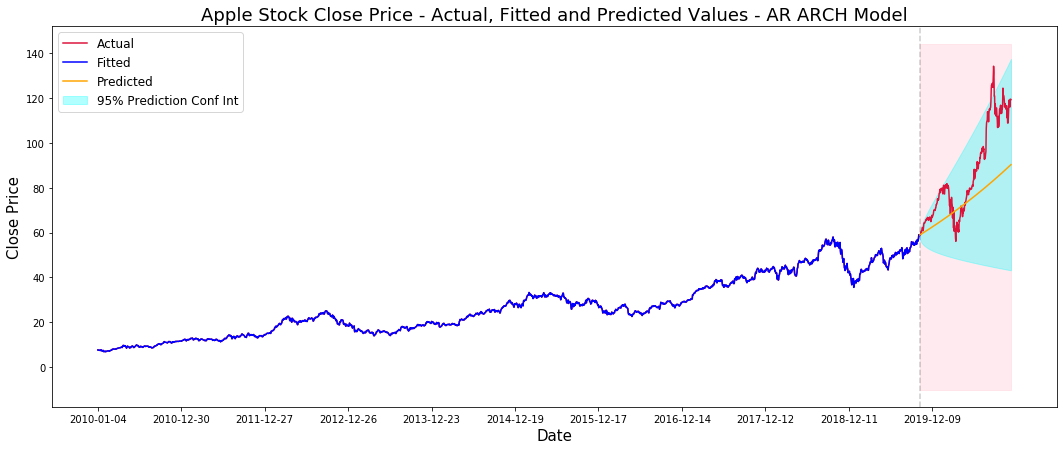


******************************************* Apple Stock Processing Finished *******************************************


************************************************* Processing Microsoft Stock **********************************************

Classical Time Series Models: Total Size: 2737 Training Size: 2463 Test Size: 274


------------------------------------------------- ARIMA Model -----------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(8, 2, 1)   Log Likelihood               -1410.189
Date:                Mon, 14 Dec 2020   AIC                           2842.378
Time:                        05:00:33   BIC                           2906.269
Sample:                             0   HQIC                      

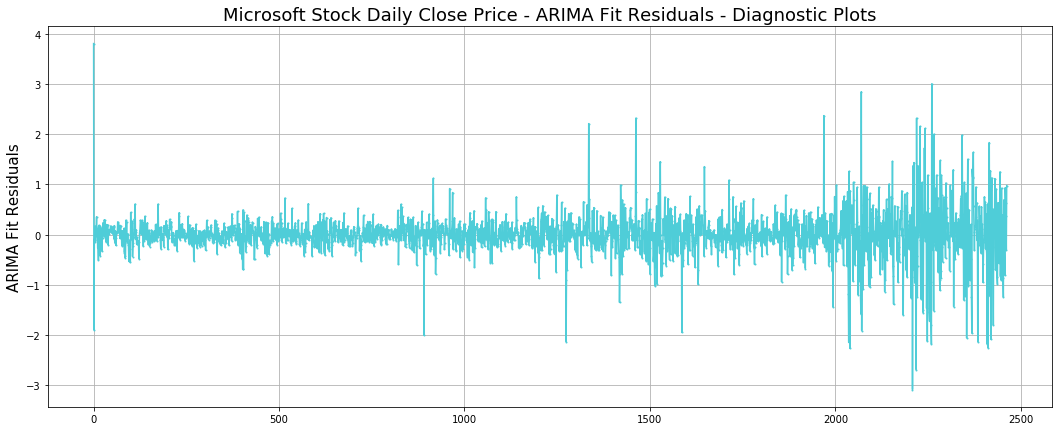

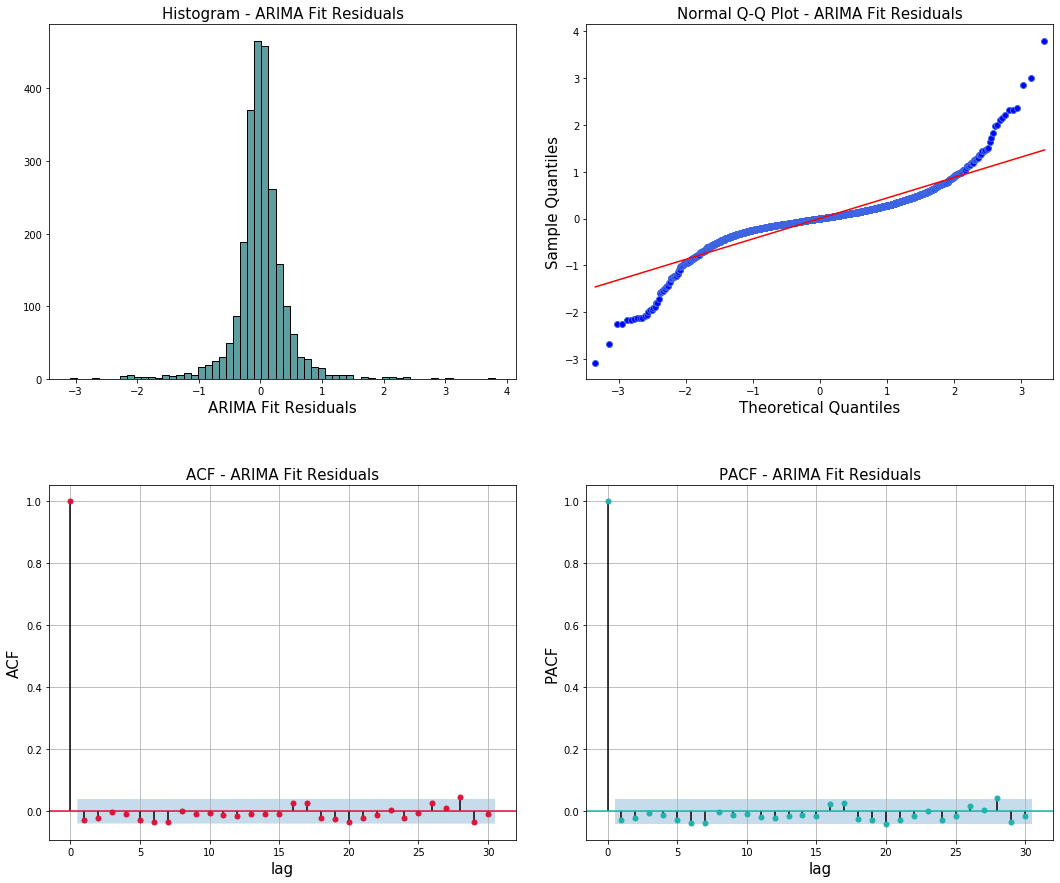

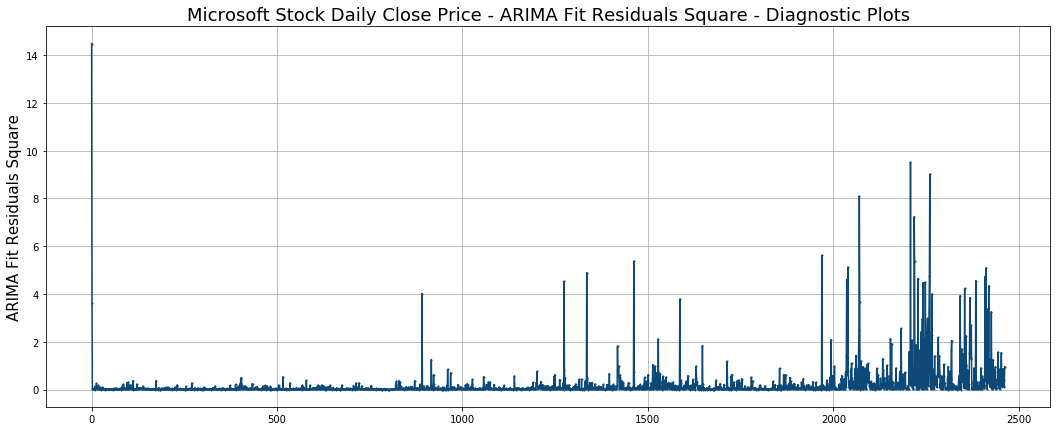

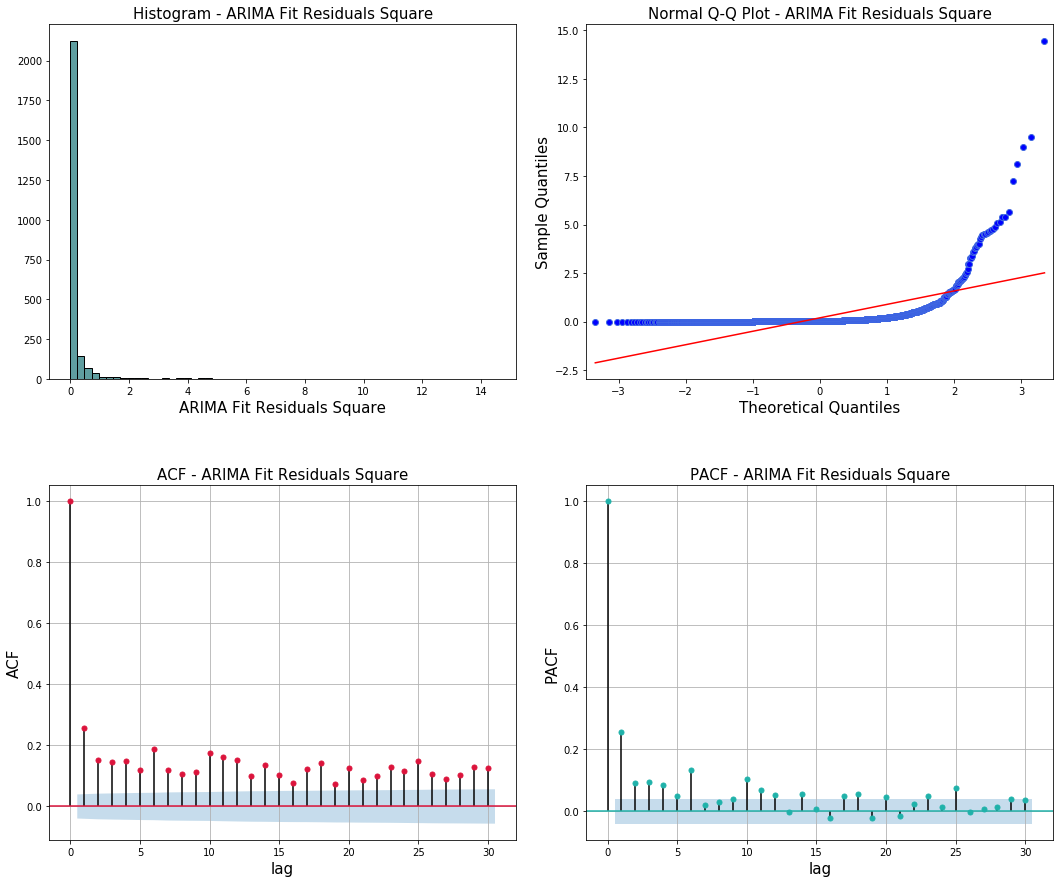

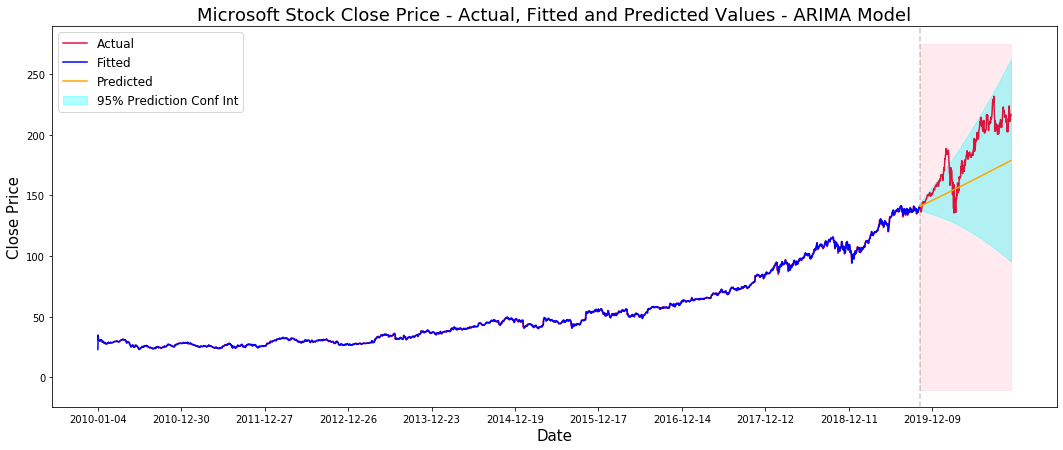

----------------------------------------------- AR ARCH Model -------------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Trying order combinations to find the best combination...
Best Lags Value: 1
Best p Value: 8
Best q Value: 0
Training completed!

                           AR - ARCH Model Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Mean Model:                        AR   Adj. R-squared:                  0.999
Vol Model:                       ARCH   Log-Likelihood:               -756.106
Distribution:                  Normal   AIC:                           1534.21
Method:            Maximum Likelihood   BIC:                           1598.11
                                        No. Observations:                 2462
Date:                Mon, Dec 14 2020   Df Residuals:                     2451
Time:                        05:00:43   Df Model: 

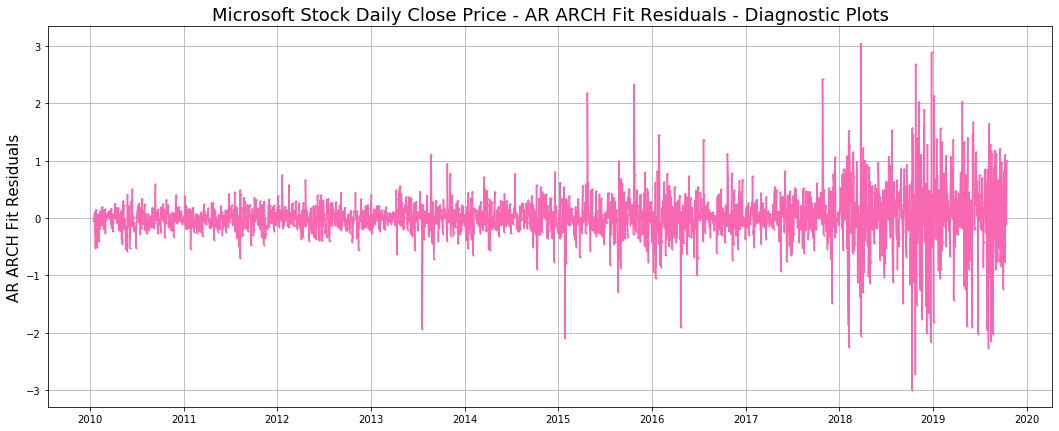

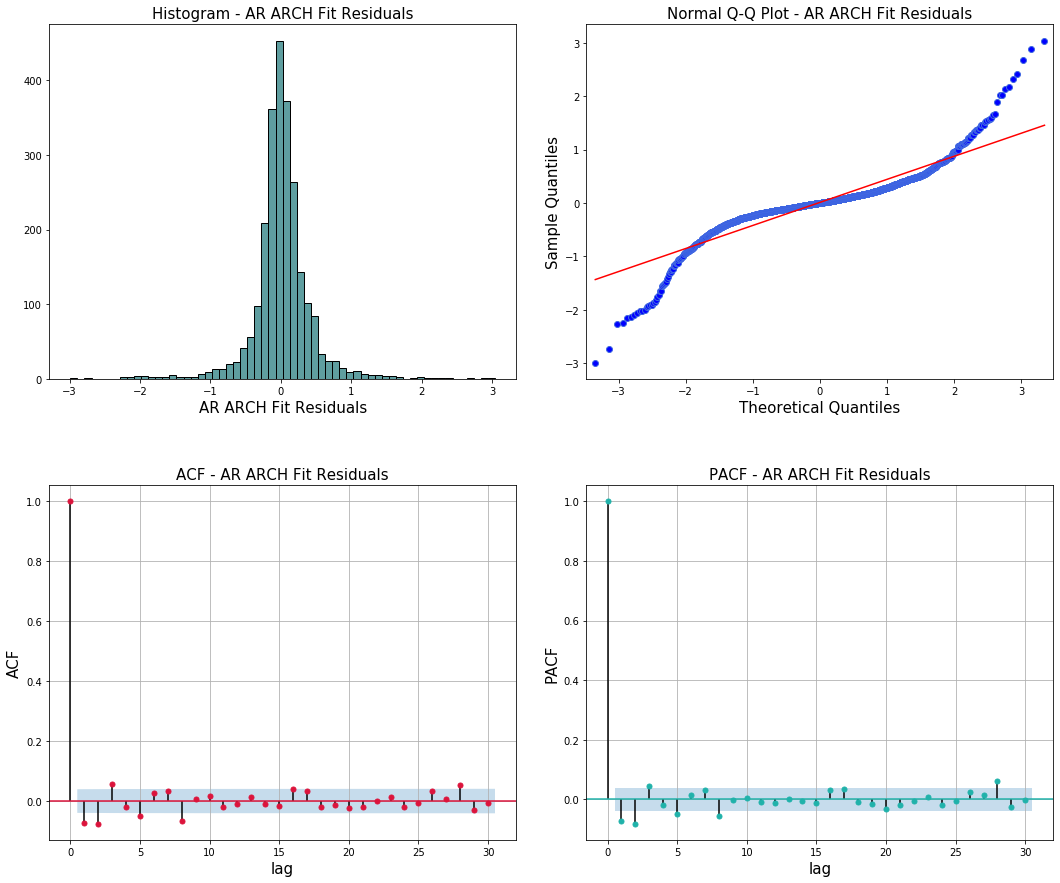

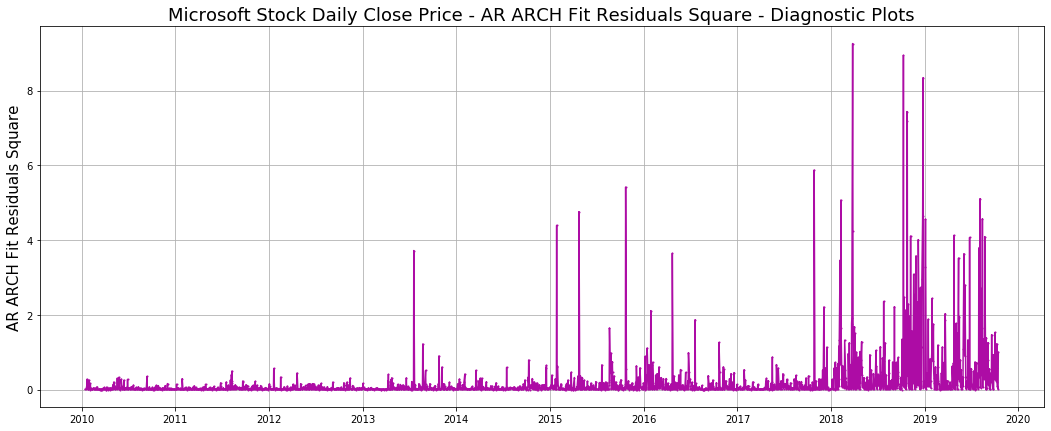

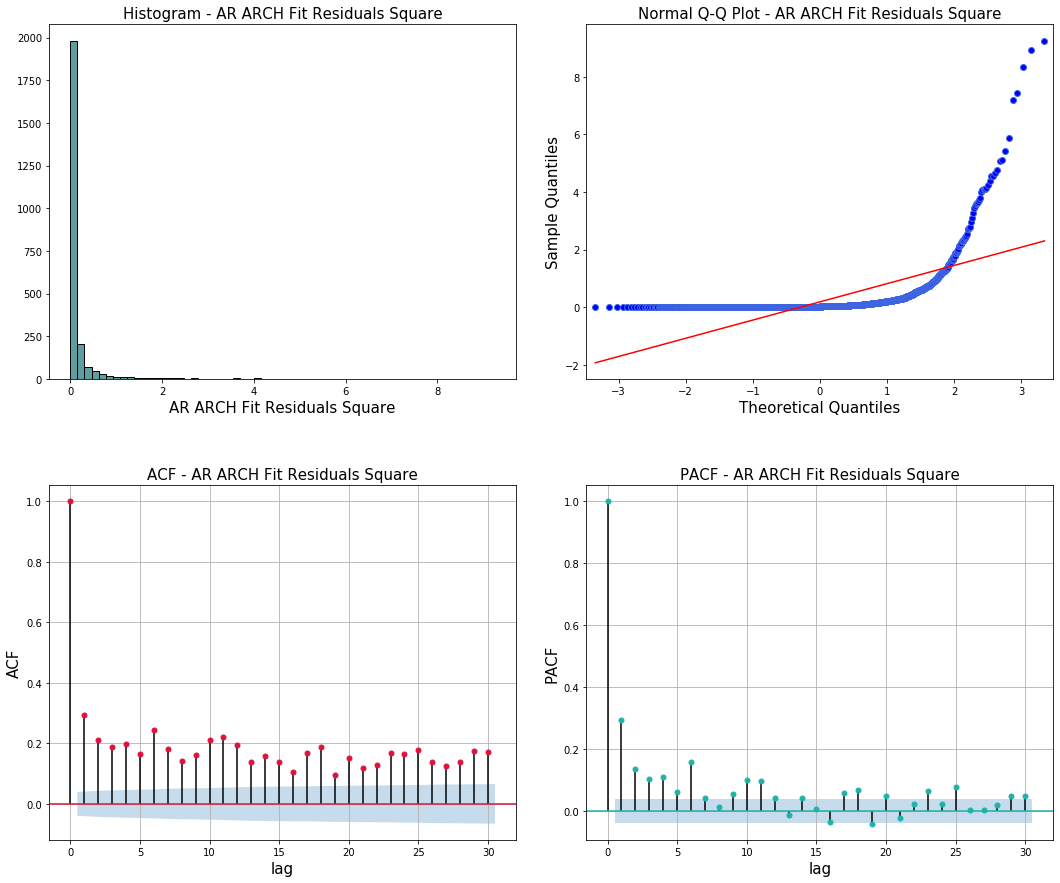

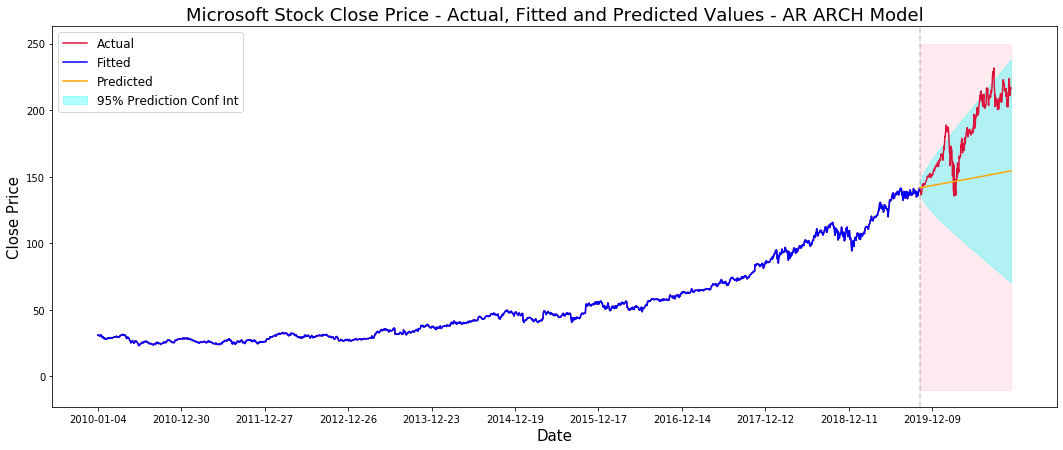


******************************************* Microsoft Stock Processing Finished *******************************************


************************************************* Processing S&P 500 Index **********************************************

Classical Time Series Models: Total Size: 2737 Training Size: 2463 Test Size: 274


------------------------------------------------- ARIMA Model -----------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2537.594
Date:                Mon, 14 Dec 2020   AIC                           5083.188
Time:                        05:02:44   BIC                           5106.423
Sample:                             0   HQIC                    

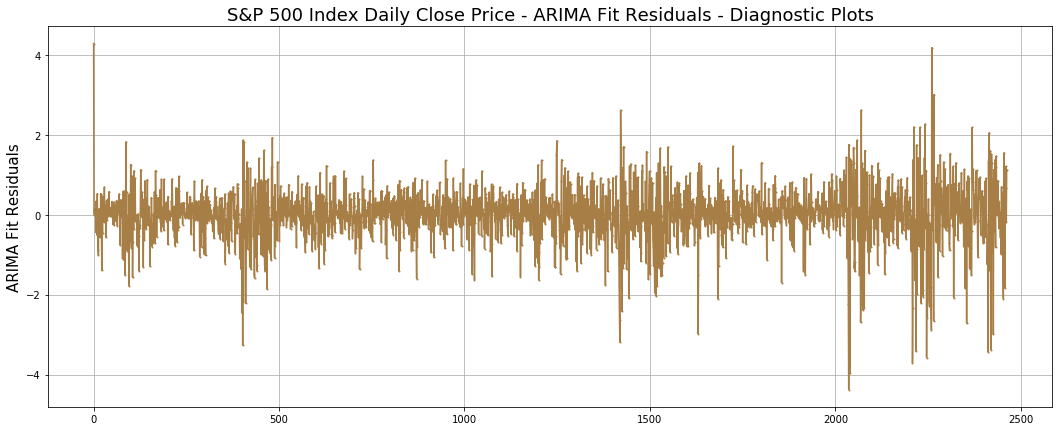

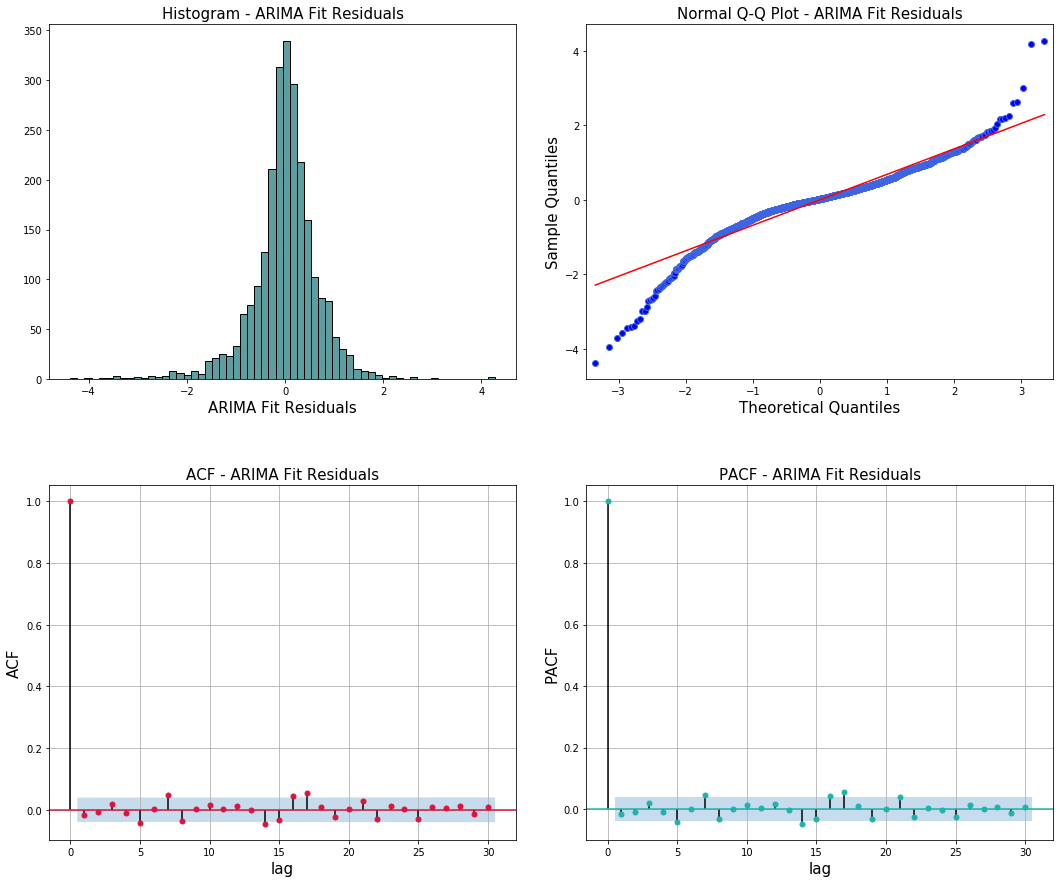

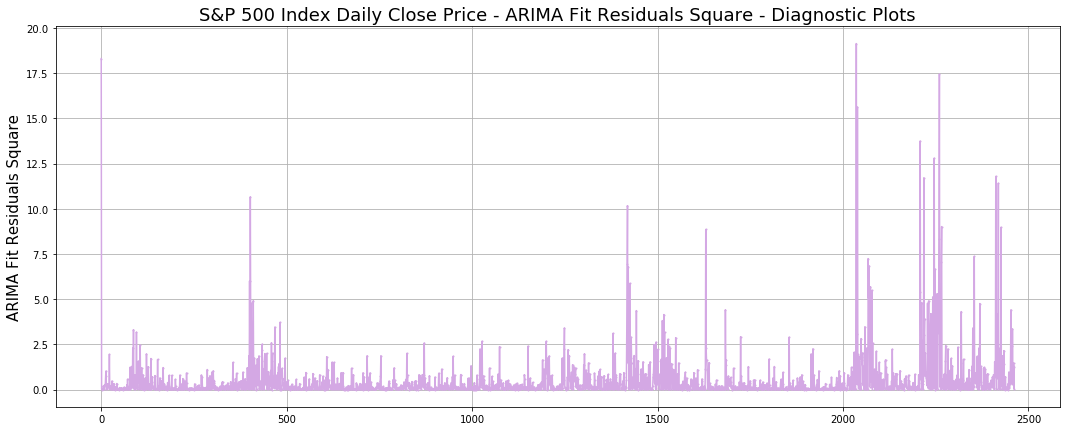

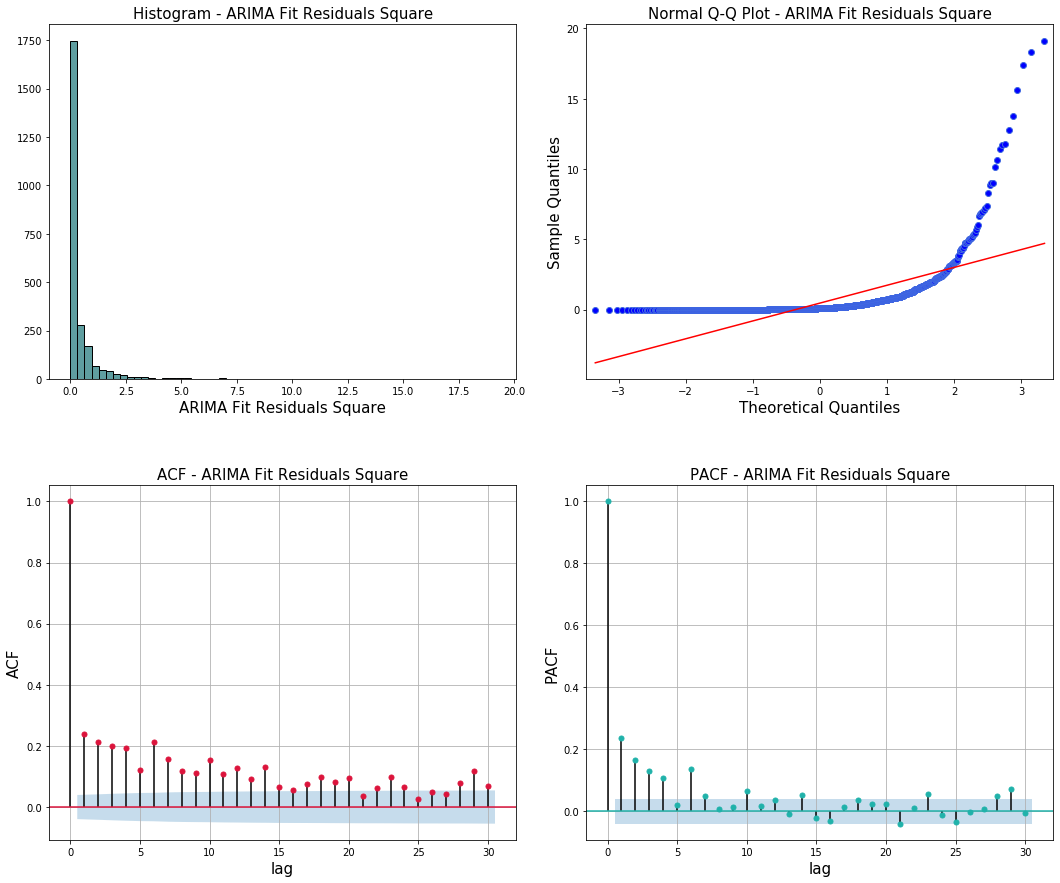

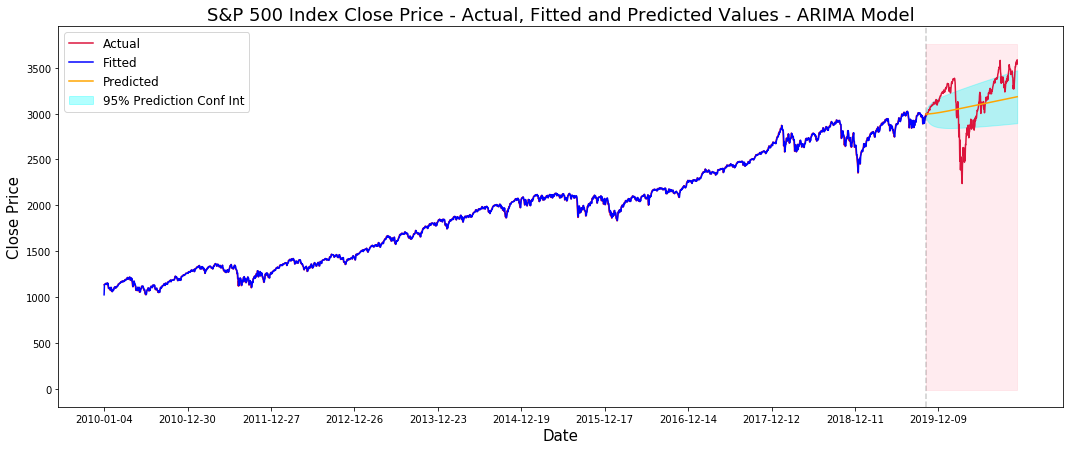

----------------------------------------------- AR ARCH Model -------------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Trying order combinations to find the best combination...
Best Lags Value: 2
Best p Value: 9
Best q Value: 0
Training completed!

                           AR - ARCH Model Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Mean Model:                        AR   Adj. R-squared:                  0.999
Vol Model:                       ARCH   Log-Likelihood:               -2153.20
Distribution:                  Normal   AIC:                           4332.39
Method:            Maximum Likelihood   BIC:                           4407.90
                                        No. Observations:                 2461
Date:                Mon, Dec 14 2020   Df Residuals:                     2448
Time:                        05:03:02   Df Model: 

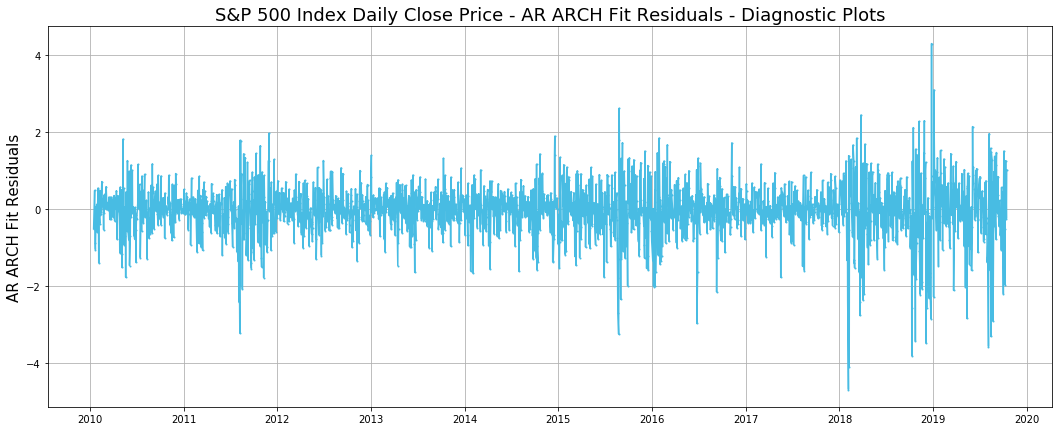

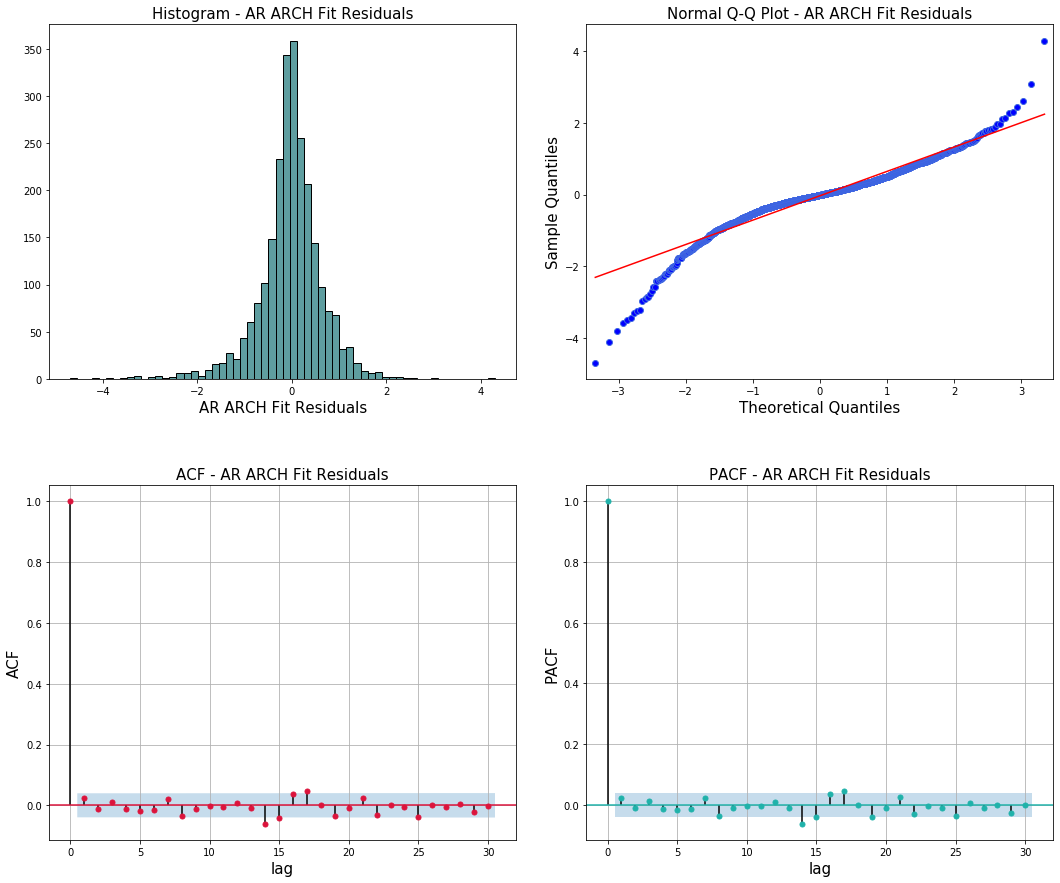

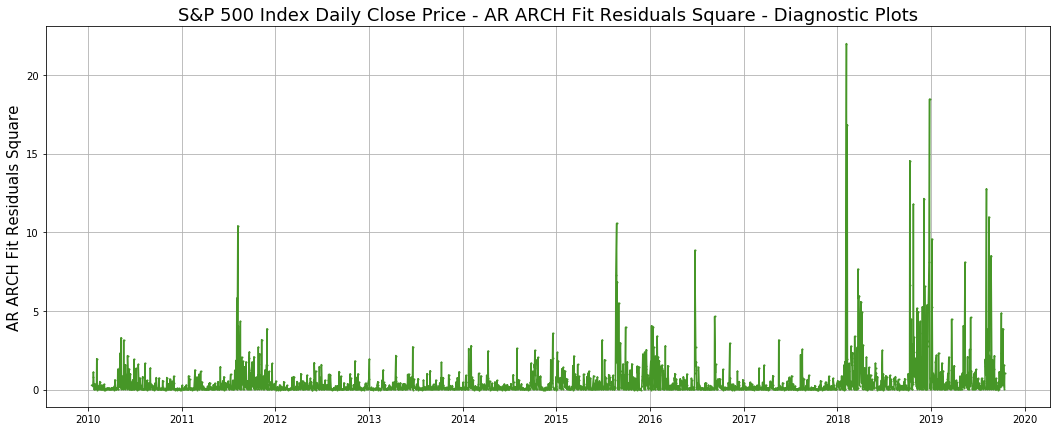

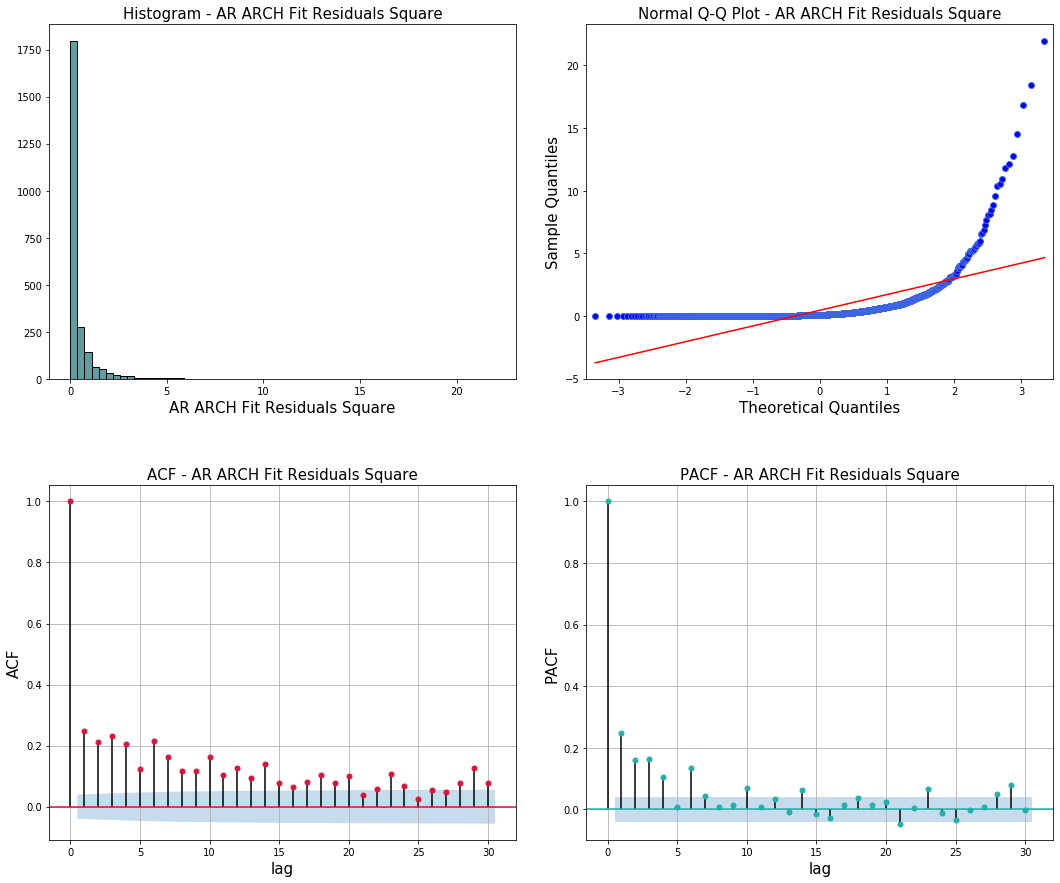

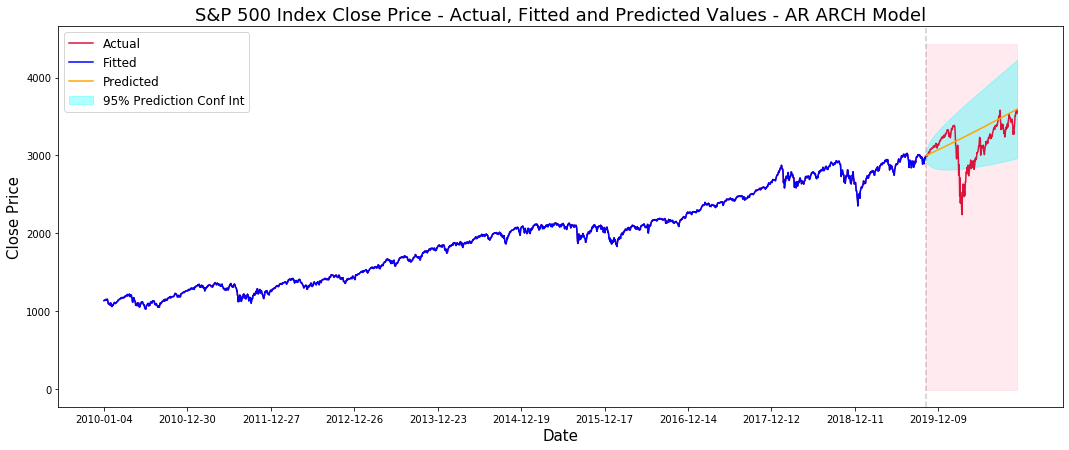


******************************************* S&P 500 Index Processing Finished *******************************************


************************************************* Processing Nasdaq 100 Index **********************************************

Classical Time Series Models: Total Size: 2737 Training Size: 2463 Test Size: 274


------------------------------------------------- ARIMA Model -----------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -1608.521
Date:                Mon, 14 Dec 2020   AIC                           3237.042
Time:                        05:06:11   BIC                           3295.129
Sample:                             0   HQIC                   

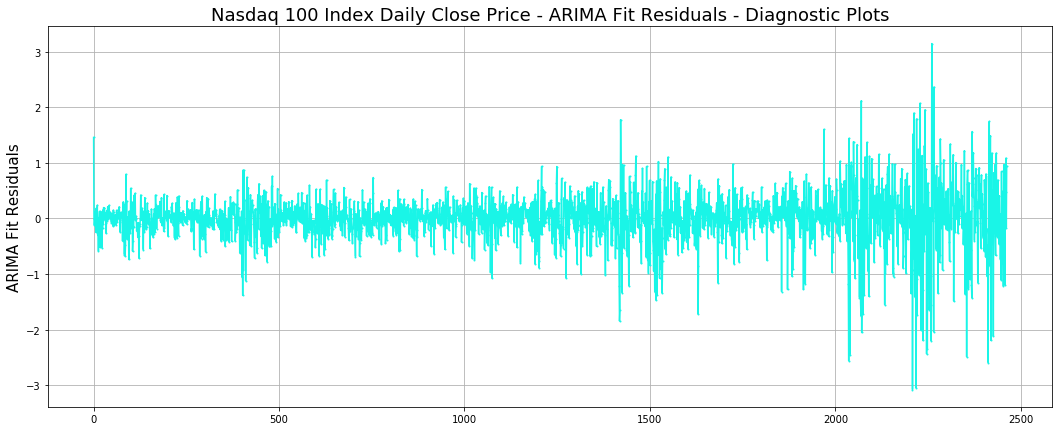

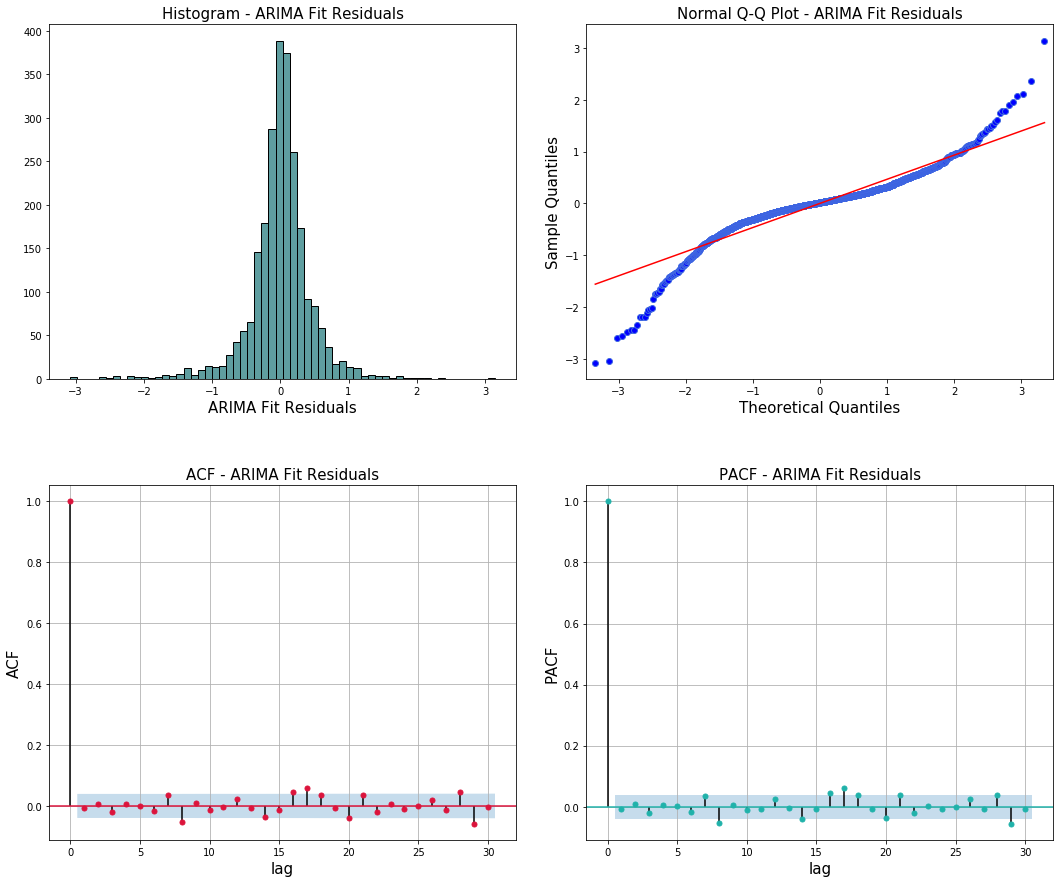

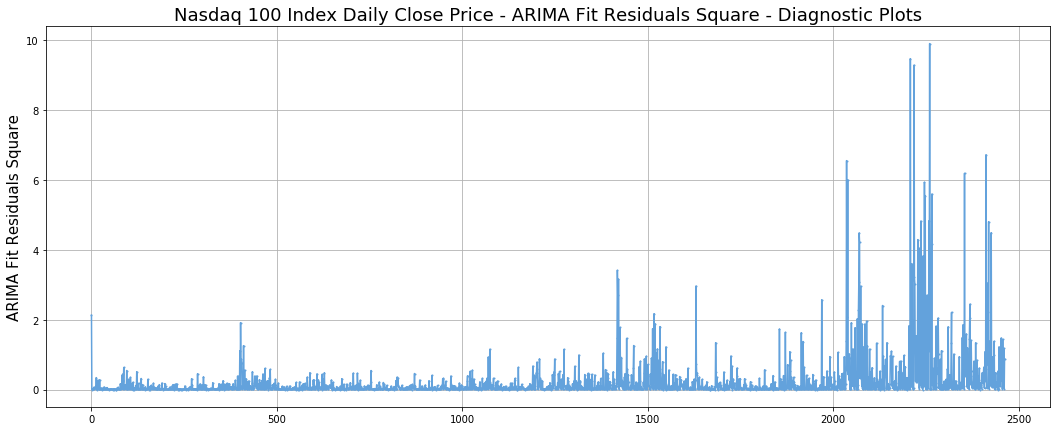

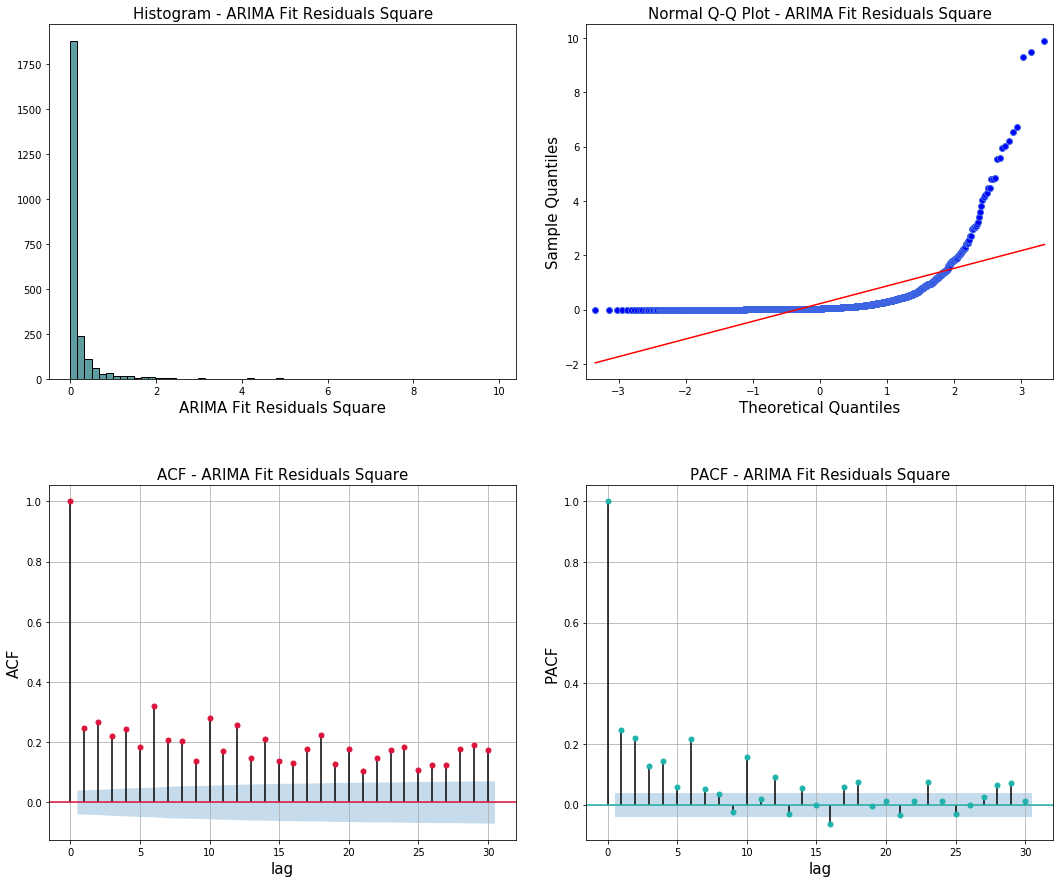

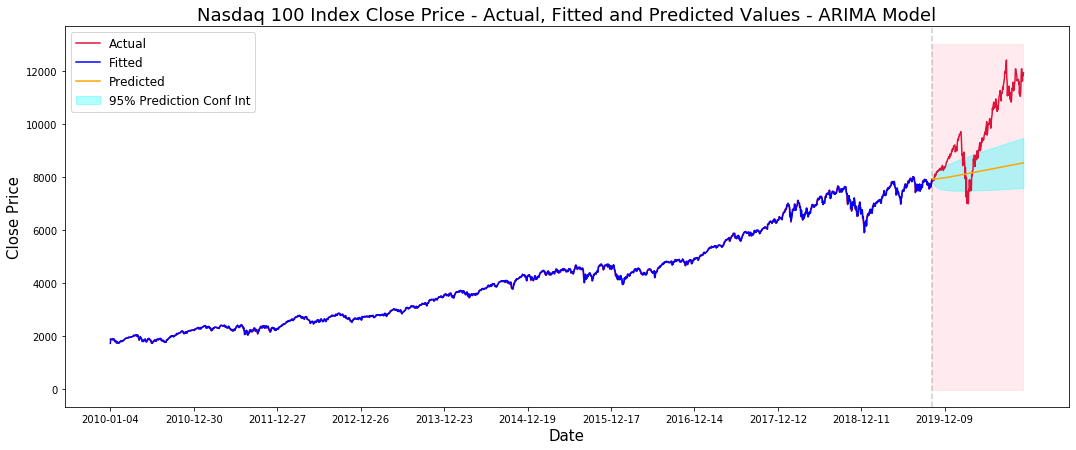

----------------------------------------------- AR ARCH Model -------------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Trying order combinations to find the best combination...
Best Lags Value: 1
Best p Value: 9
Best q Value: 0
Training completed!

                           AR - ARCH Model Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Mean Model:                        AR   Adj. R-squared:                  0.999
Vol Model:                       ARCH   Log-Likelihood:               -1013.01
Distribution:                  Normal   AIC:                           2050.03
Method:            Maximum Likelihood   BIC:                           2119.73
                                        No. Observations:                 2462
Date:                Mon, Dec 14 2020   Df Residuals:                     2450
Time:                        05:06:23   Df Model: 

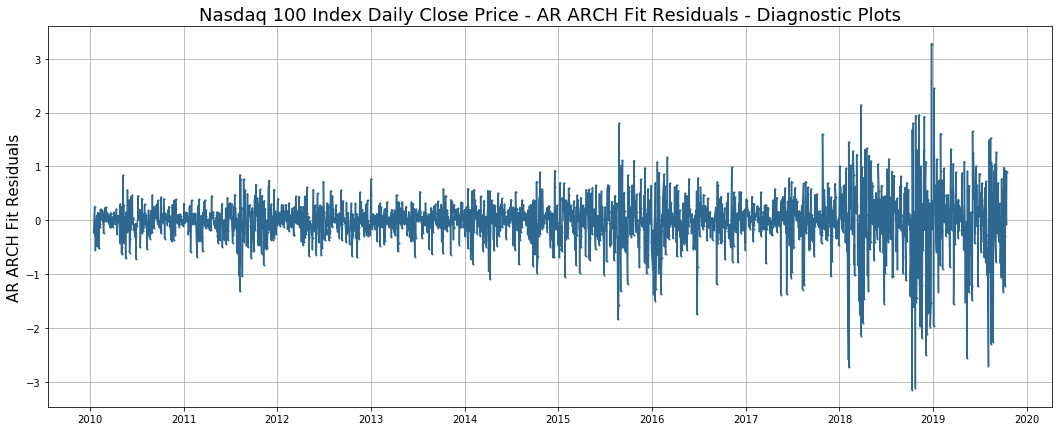

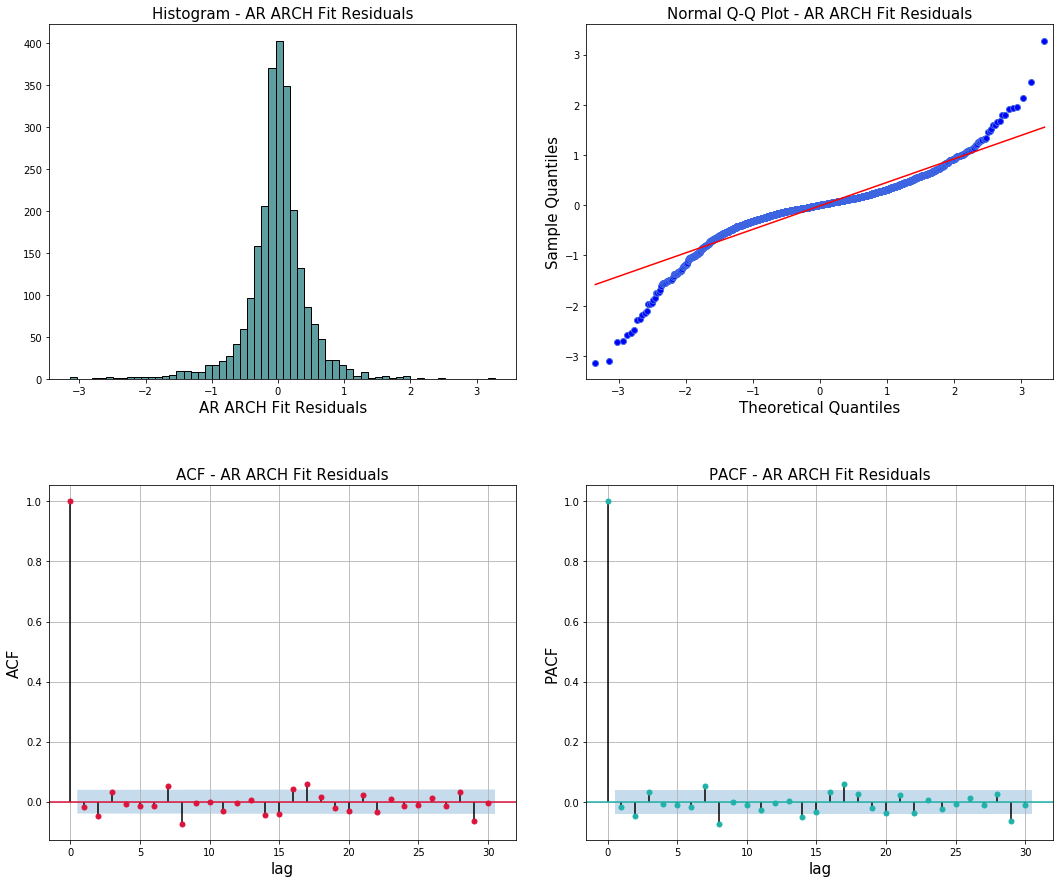

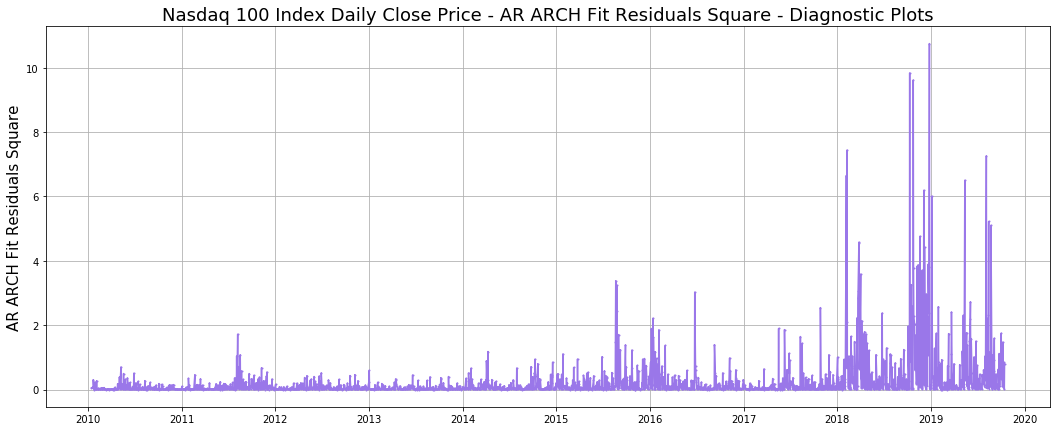

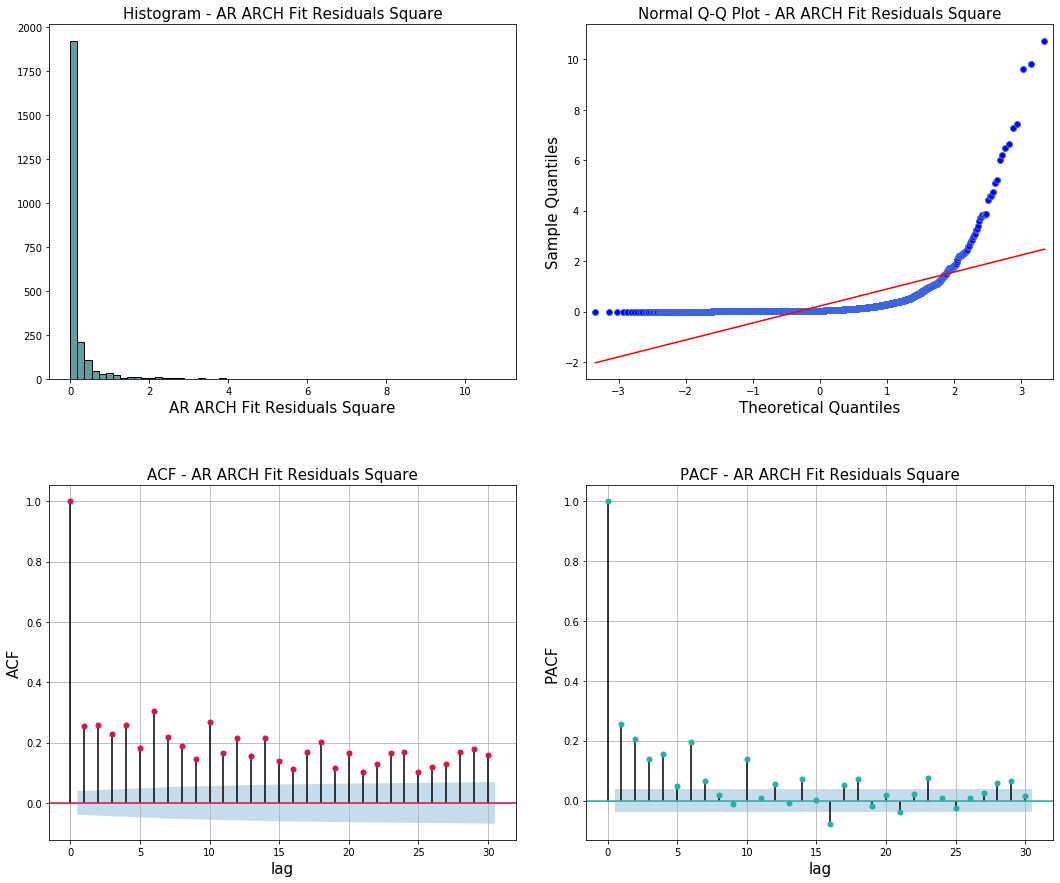

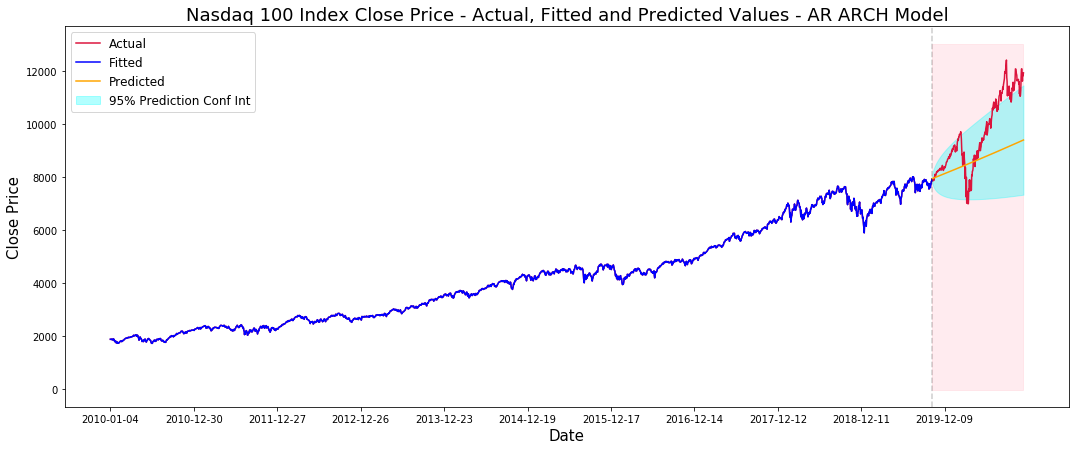


******************************************* Nasdaq 100 Index Processing Finished *******************************************



In [12]:
# Dictionary to store the results of all the classical models
classical_results = {}

# Build and predict using all the classical time series models
for security in dfs_price_scaled_classical:
    header = header_prefix + security + header_suffix
    print(header)

    security_results = {}
    security_mse = {}

    price_scaled = dfs_price_scaled_classical[security]
    security_scalers = scalers_classical[security]

    total_size = len(price_scaled)
    
    # Compute Training and Test Set Sizes
    training_size = int(total_size * training_percentage)
    test_size = total_size - training_size

    # Print Training and Test Set Sizes
    print("Classical Time Series Models: Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)
    print('\n')
    
    model, dates, actual, predictions, mse = arima_model(price_scaled, security_scalers, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse
    
    model, dates, actual, predictions, mse = ar_arch_model(price_scaled, security_scalers, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse
    
    classical_results[security] = security_results
    mse_values[security] = security_mse
    
    footer = footer_prefix + security + footer_suffix
    print(footer)

### Display Price Prediction of all the Classical Time Series Models

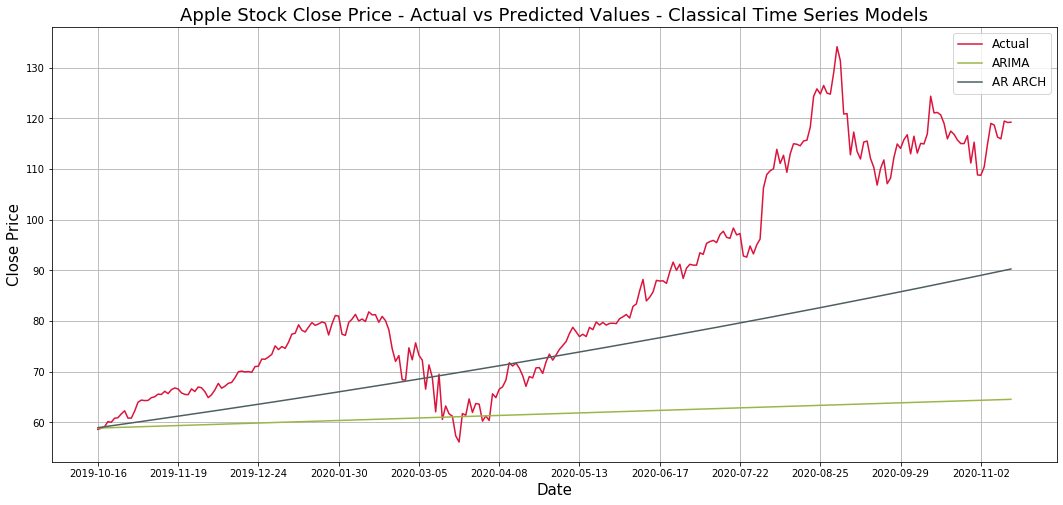

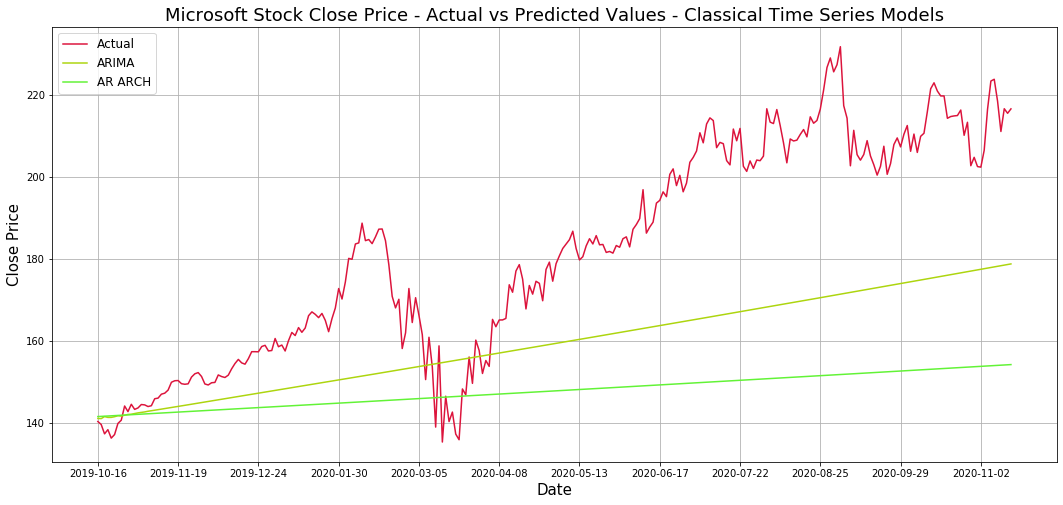

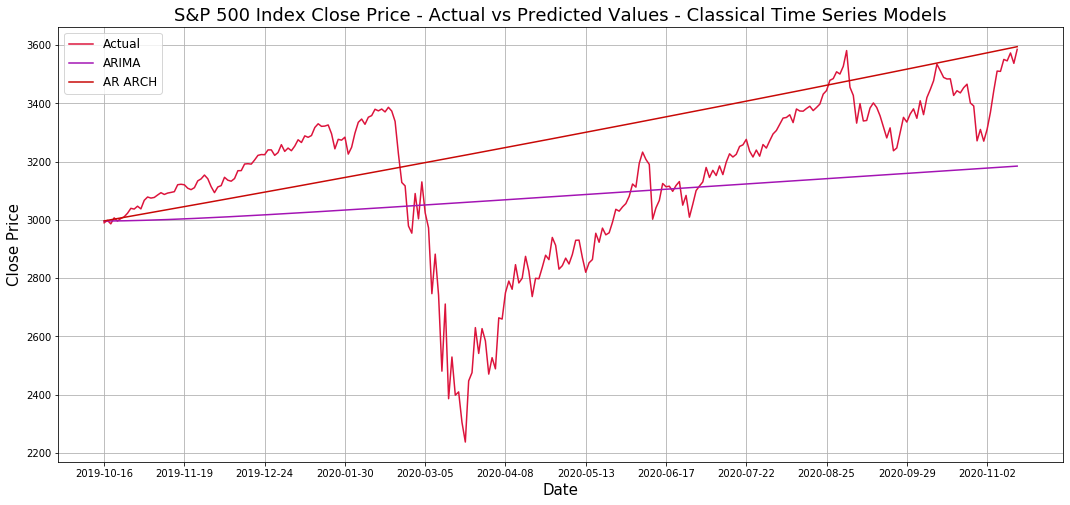

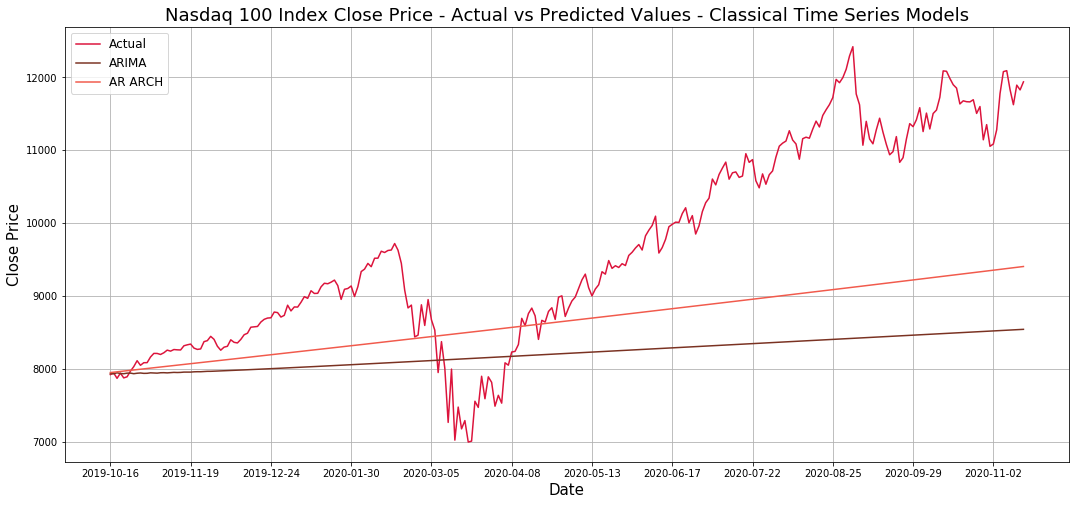

In [13]:
for security, security_results in classical_results.items():
    actual_displayed = False
    model_list = []
    
    plt.figure(figsize=(18, 8))
    for model, model_results in security_results.items():
        dates, actual, predictions = model_results
        model_list.append(model)
        if not actual_displayed:
            plt.plot(dates, actual, "-", color='crimson', label='Actual')
            actual_displayed = True

        plt.plot(dates, predictions, "-", color=np.random.rand(3,), label=model)

    plt.title(security + " " + price_type + " Price - Actual vs Predicted Values - Classical Time Series Models", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price", fontsize=15)
    plt.xticks(dates[::24])
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show();

# Price Prediction using LSTM Models

## Common Functions for all the Models

In [14]:
# Given history displays Loss and RMSE curves
def plot_loss_and_rmse(history, title_prefix):
    # Extract loss and accuracy
    loss = history.history['loss']
    rmse = history.history['rmse']

    val_loss = history.history['val_loss']
    val_rmse = history.history['val_rmse']

    epochs = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
    plt.suptitle(title_prefix + "Loss and RMSE", fontsize=18)

    ax[0].plot(epochs, loss, '-o', label='Training Loss')
    ax[0].plot(epochs, val_loss, '-o', color='r', label='Validation Loss')
    ax[0].grid(color='black', which='major', linestyle='dashed')
    ax[0].set_title('Training and Validation Loss', fontsize=18)
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=12)

    ax[1].plot(epochs, rmse, '-o', label='Training RMSE')
    ax[1].plot(epochs, val_rmse, '-o', color='r', label='Validation RMSE')
    ax[1].grid(color='black', which='major', linestyle='dashed')
    ax[1].set_title('Training and Validation RMSE', fontsize=18)
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('RMSE', fontsize=15)
    ax[1].legend(fontsize=12)

    plt.show();
    
# Displays Actual and Predicted prices for given dates
def plot_actual_vs_predicted(dates, actual, predictions, title_prefix, price_type):
    plt.figure(figsize=(21, 8))
    plt.plot(dates, actual, "-o", color='b', label='Actual')
    plt.plot(dates, predictions, "-o", color='r', label='Predicted')
    plt.title(title_prefix + "Actual vs Predicted", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price (USD)", fontsize=15)
    plt.xticks(dates[::6])
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show();

In [15]:
def build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead):
    
    # Extract Input Shape
    input_shape = (train_features.shape[1], train_features.shape[2])
    
    # Create the model
    model = Sequential()

    # Add LSTM and Dropout Layers
    model.add(CuDNNLSTM(units=150, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150))
    model.add(Dropout(0.2))

    # Add dense layers
    model.add(Dense(units = look_ahead))

    # Compile the Model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[RootMeanSquaredError(name='rmse')])

    print("Training the model ...")

    # Train the model
    history = model.fit(train_features,
                        train_labels,
                        epochs=60,
                        batch_size=32,
                        validation_data=(val_features, val_labels),
                        verbose=verbose)

    print("Training completed!\n")
    
    return model, history

### Model 1 - Univariate Model

In [16]:
def univariate_model(df_price, scalers, security, price_type):
    model_name = "Univariate LSTM Model"
    
    print("-----------------------------------------------", model_name, "-------------------------------------------------\n")

    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 1
    title_prefix = security + " " + price_type + " Price - Univariate LSTM Model - "

    # Extract price and scaler for the price type
    price = df_price[[price_type]].values
    scaler = scalers[price_type]
    
    # Extract dates
    dates = df_price[window_size:].index.format()
    dates_train = df_price[window_size:].head(training_size).index.format()
    dates_test = df_price[window_size:].tail(test_size).index.format()

    # Create Training and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price)):
        if i < window_size + training_size:
            train_features.append(price[i-window_size:i, 0])
            train_labels.append(price[i, 0])
        else:
            test_features.append(price[i-window_size:i, 0])
            test_labels.append(price[i, 0])
    
    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Reshape Training and Test Feature Sets to fit LSTM input shape
    train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, test_features, test_labels, look_ahead)

    # Save the model
    model.save("lstm_univariate_" + security + '.h5', save_format='tf')
    
    # Print the model summary
    print(model.summary())
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to find fitted values and convert to origianl scale
    fitted = scaler.inverse_transform(model.predict(train_features)) 

    # Use the model to predict for the test data and convert to origianl scale
    predictions = scaler.inverse_transform(model.predict(test_features))
    
    # Convert all actual values to the origianl scale
    actual = scaler.inverse_transform(price)

    # Plot Actual, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title, dates, actual[window_size:], dates_train, fitted, dates_test, predictions)   

    # Convert actual test values to the origianl scale
    actual = scaler.inverse_transform(test_labels.reshape(-1, 1))
    
    return "Univariate LSTM", dates_test, actual, predictions, mean_squared_error(actual, predictions)

### Model 2 - Univariate Multiday Look ahead Model

In [17]:
def univariate_multiday_model(df_price, scalers, security, price_type):
    model_name = "Univariate MultiDay Look ahead LSTM Model"
    
    print("----------------------------------------", model_name, "-----------------------------------------\n")

    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 3
    title_prefix = security + " " + price_type + " Price - Univariate Multiday Look ahead LSTM Model - "

    # Extract price and scaler for the price type
    price = df_price[[price_type]].values
    scaler = scalers[price_type]
    
    # Extract dates
    dates = df_price[window_size:].index.format()
    dates_train = df_price[window_size:].head(training_size).index.format()
    dates_test = df_price[window_size:].tail(test_size).index.format()

    # Create Training and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price) - look_ahead + 1):  
        if i < window_size + training_size:
            train_features.append(price[i-window_size:i, 0])
            train_labels.append(price[i:i+look_ahead, 0])
        else:
            test_features.append(price[i-window_size:i, 0])
            test_labels.append(price[i:i+look_ahead, 0])
    
    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Reshape data to fit LSTM input shape
    train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, test_features, test_labels, look_ahead)

    # Save the model
    model.save("lstm_univariate_multiday_look_ahead_" + security + '.h5', save_format='tf')
    
    # Print the model summary
    print(model.summary())
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix) 
    
    # Use the model to find fitted values and convert to origianl scale
    fitted = scaler.inverse_transform(model.predict(train_features))

    # Use the model to predict for the test data and convert to origianl scale
    predictions = scaler.inverse_transform(model.predict(test_features))
    
    # Convert all actual values to the origianl scale
    actual = scaler.inverse_transform(price)   
    
    model_names = np.empty(look_ahead, dtype=object)
    model_dates = np.empty((test_size-look_ahead+1, look_ahead), dtype=object)
    model_mse = np.empty(look_ahead)
    actual_test = np.empty((test_labels.shape[0], look_ahead), dtype=object)

    for i in range(look_ahead):
        model_names[i] = "Univariate: Lahead-" + str(i+1)       
        model_dates[:, i] = np.array(dates_test[i:i+test_size-look_ahead+1])        
        actual_test[:, i] = scaler.inverse_transform(test_labels[:, i].reshape(-1, 1)).ravel()        
        model_mse[i] = mean_squared_error(actual_test[:, i], predictions[:, i])

        # Plot Actual, Fitted and Predicted Values
        title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_names[i]
        plot_original_fitted_pred(title, dates, actual[window_size:], dates_train, fitted[:, i], model_dates[:, i], predictions[:, i])
    
    return model_names, model_dates, actual_test, predictions, model_mse

### Model 3 - Multivariate Model

In [18]:
def multivariate_model(df_price, scalers, security, price_type):
    model_name = "Multivariate LSTM Model"
    
    print("-----------------------------------------------", model_name, "-------------------------------------------------\n")

    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 1
    title_prefix = security + " " + price_type + " Price - Multivariate LSTM Model - "

    # Extract price and scaler for the price type
    price_all = df_price.values
    price = df_price[[price_type]].values
    scaler = scalers[price_type]

    # Extract dates
    dates = df_price[window_size:].index.format()
    dates_train = df_price[window_size:].head(training_size).index.format()
    dates_test = df_price[window_size:].tail(test_size).index.format()

    # Create Training and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price)):
        if i < window_size + training_size:
            train_features.append(price_all[i-window_size:i, :])
            train_labels.append(price[i, 0])        
        else:
            test_features.append(price_all[i-window_size:i, :])
            test_labels.append(price[i, 0])

    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, test_features, test_labels, look_ahead)

    # Save the model
    model.save("lstm_multivariate_" + security + '.h5', save_format='tf')    

    # Print the model summary
    print(model.summary())
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to find fitted values and convert to origianl scale
    fitted = scaler.inverse_transform(model.predict(train_features))

    # Use the model to predict for the test data and convert to origianl scale
    predictions = scaler.inverse_transform(model.predict(test_features))
    
    # Convert all actual values to the origianl scale
    actual = scaler.inverse_transform(price)

    # Plot Actual, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title, dates, actual[window_size:], dates_train, fitted, dates_test, predictions)   

    # Convert actual test values to the origianl scale
    actual = scaler.inverse_transform(test_labels.reshape(-1, 1))

    return "Multivariate LSTM", dates_test, actual, predictions, mean_squared_error(actual, predictions)

### Run all the LSTM Models and Display Results of Individual Models


************************************************* Processing Apple Stock **********************************************

LSTM Models: Total Size: 2737 Training Size: 2403 Test Size: 274


----------------------------------------------- Univariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 60, 150)           91800     
_________________________________________________________________
dropout (Dropout)            (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 60, 150)           181200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 150)  

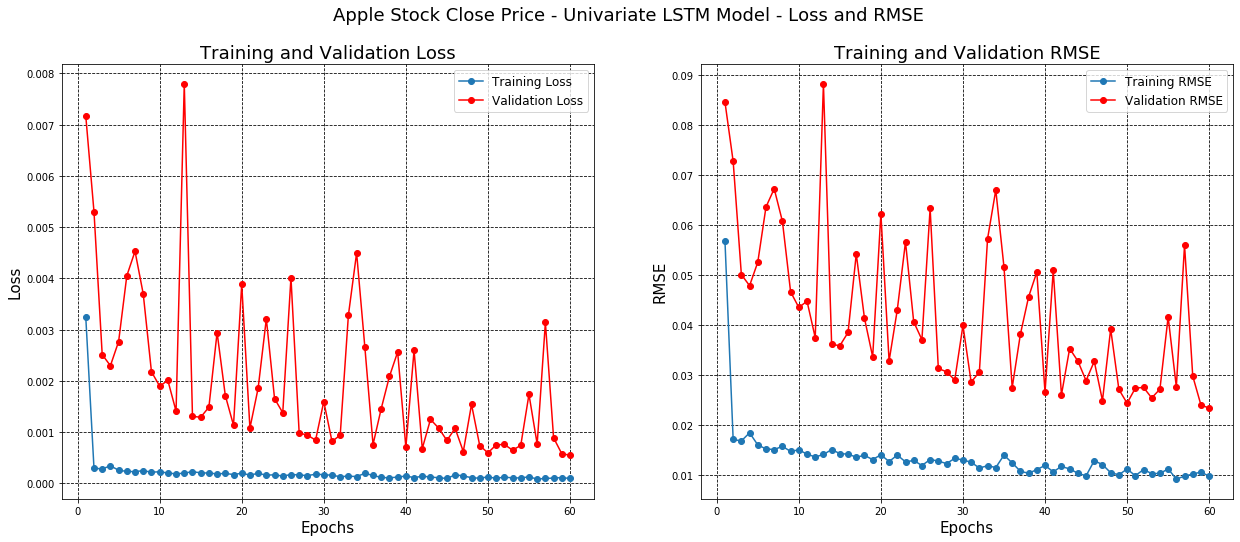

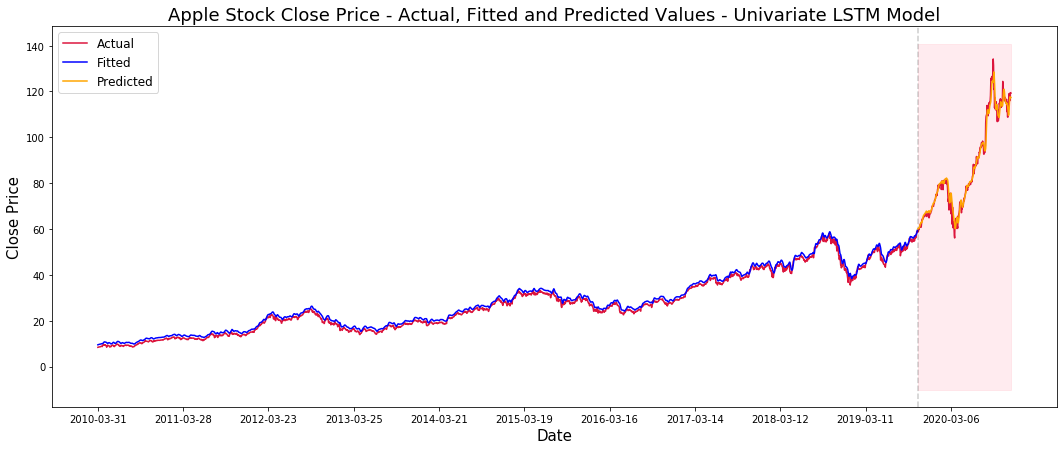

---------------------------------------- Univariate MultiDay Look ahead LSTM Model -----------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 60, 150)           91800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 60, 150)           181200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 60, 150)           181200    
______________________________

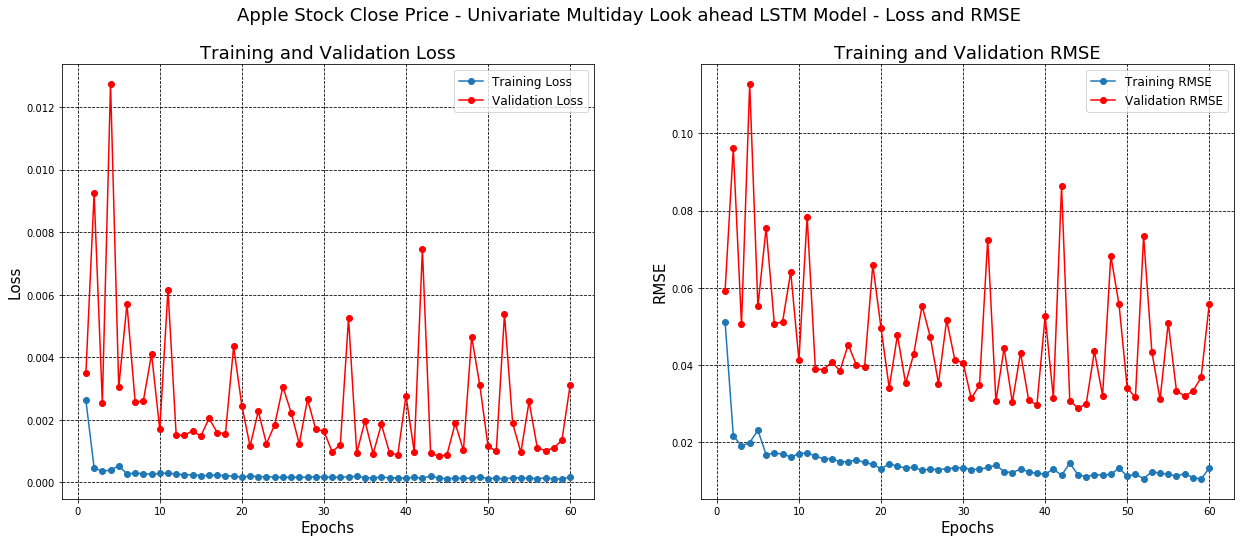

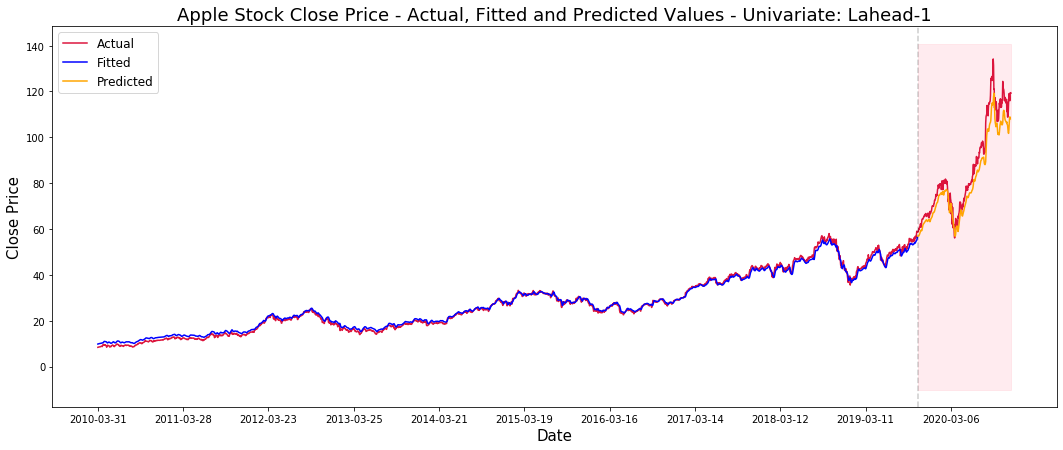

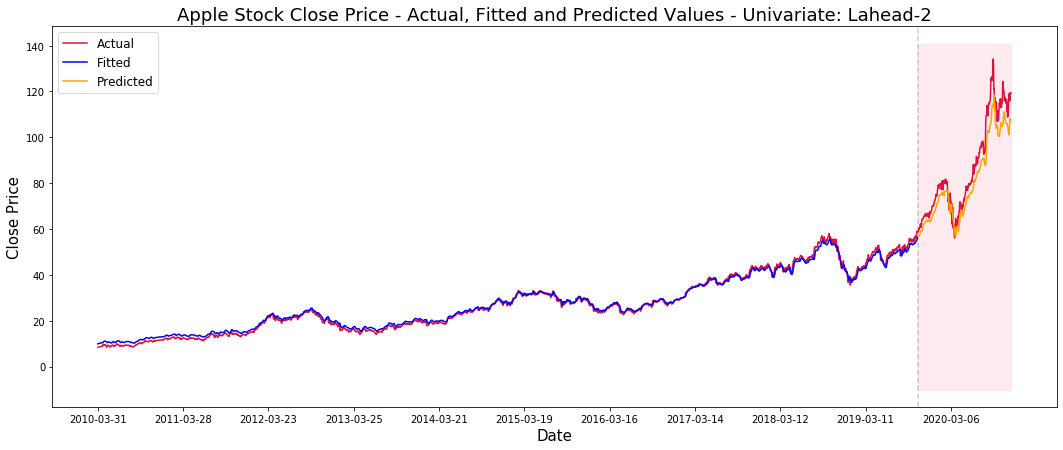

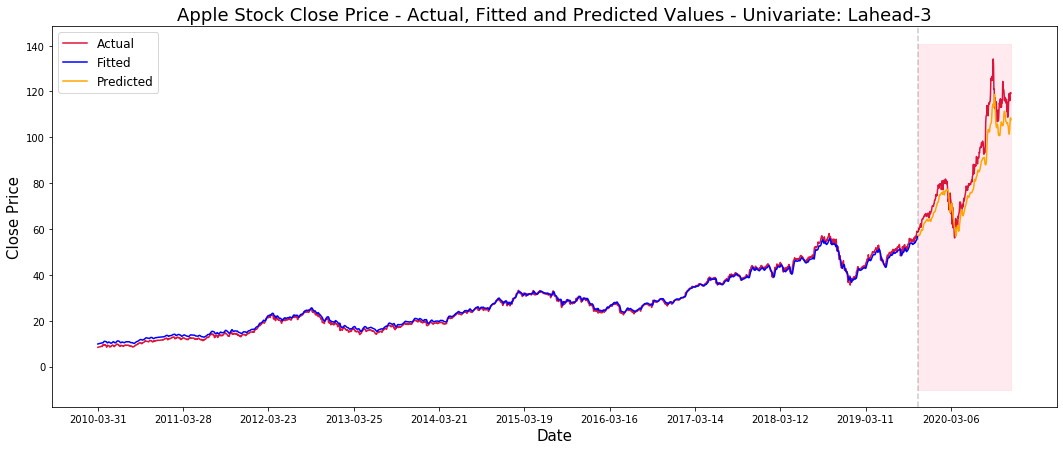

----------------------------------------------- Multivariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_8 (CuDNNLSTM)     (None, 60, 150)           93600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 60, 150)           181200    
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________

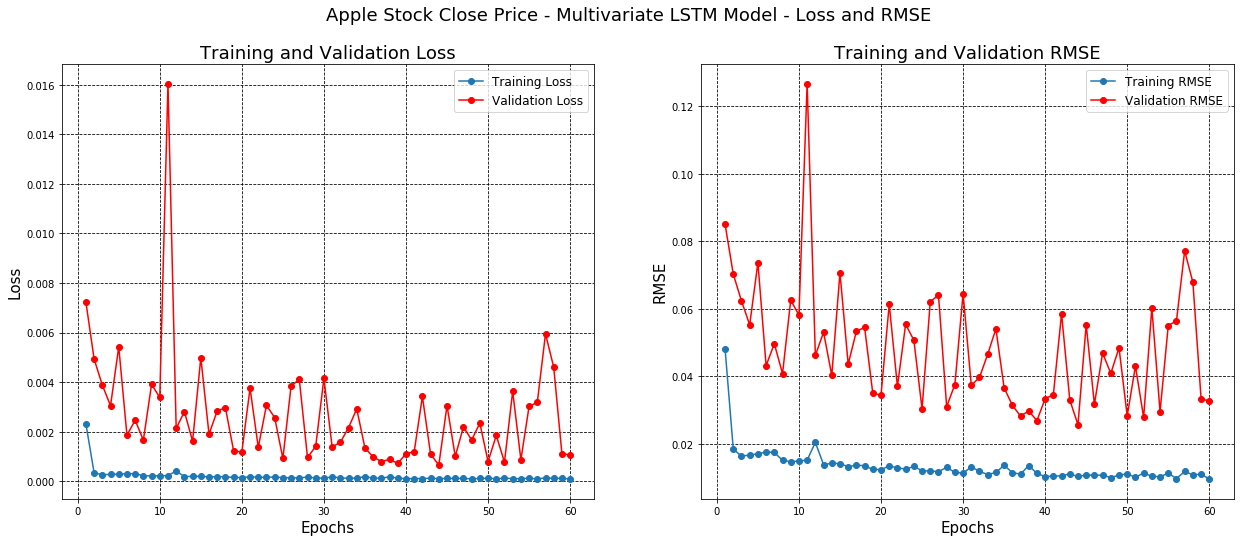

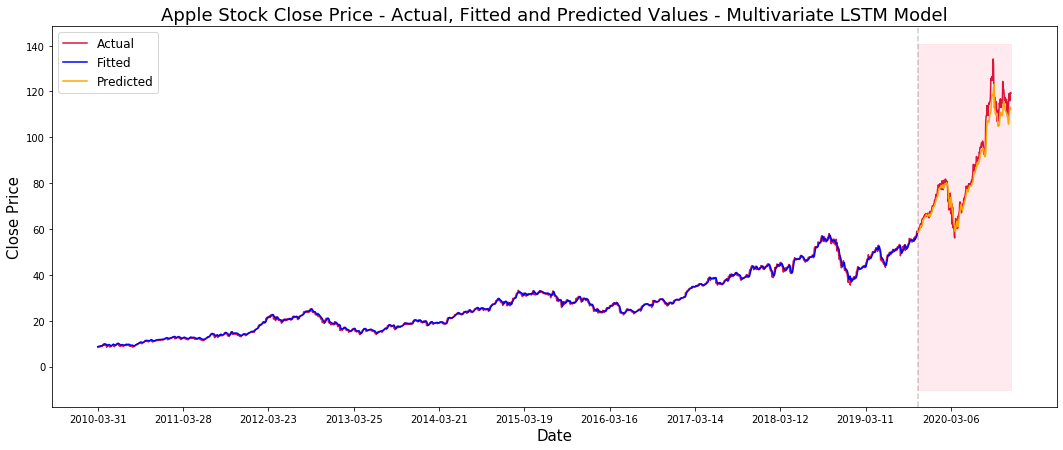


************************************************* Processing Apple Stock **********************************************


************************************************* Processing Microsoft Stock **********************************************

LSTM Models: Total Size: 2737 Training Size: 2403 Test Size: 274


----------------------------------------------- Univariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_12 (CuDNNLSTM)    (None, 60, 150)           91800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 60, 150)      

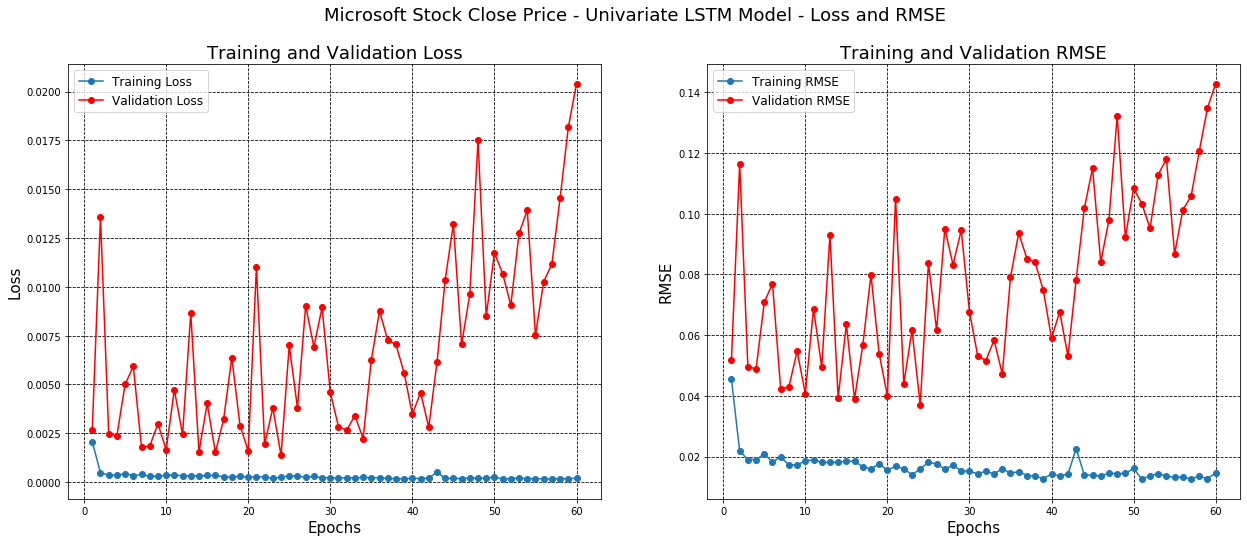

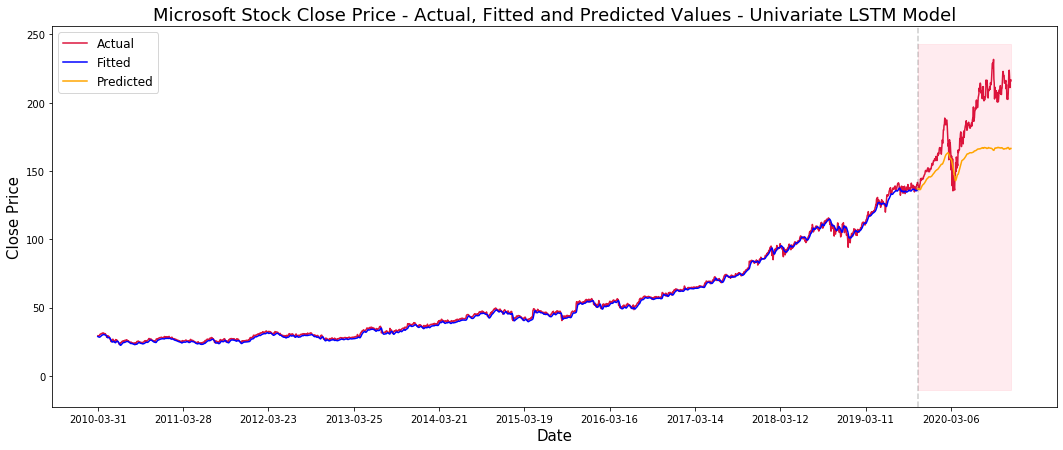

---------------------------------------- Univariate MultiDay Look ahead LSTM Model -----------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_16 (CuDNNLSTM)    (None, 60, 150)           91800     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_17 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 60, 150)           181200    
______________________________

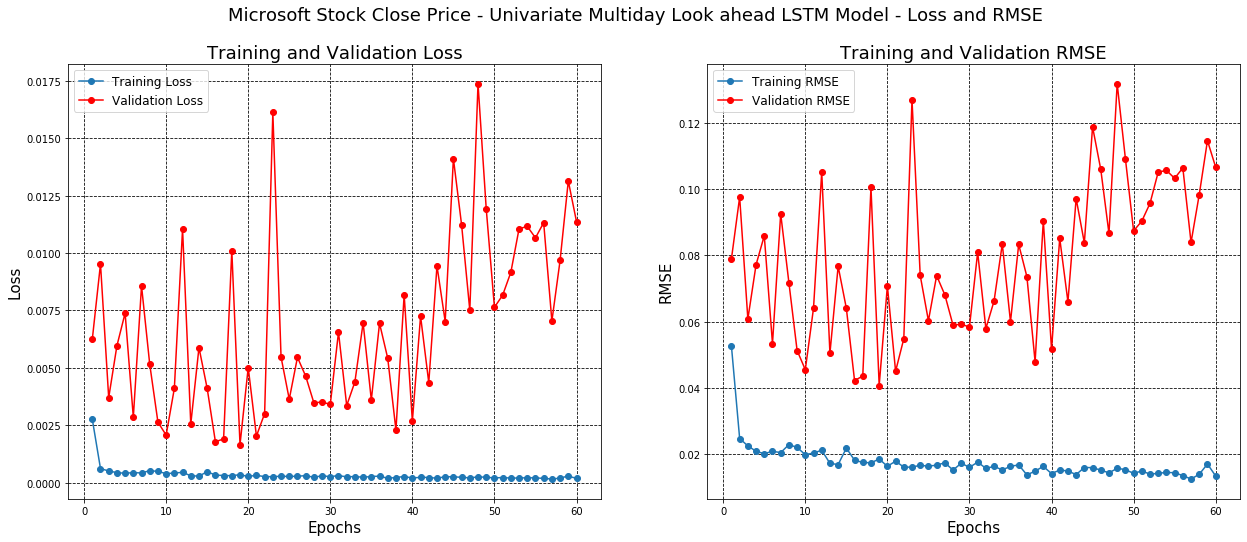

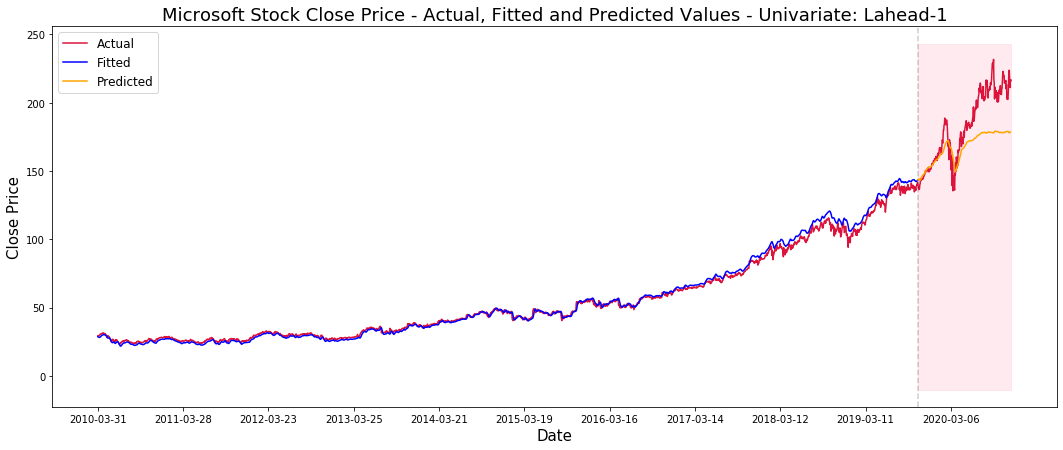

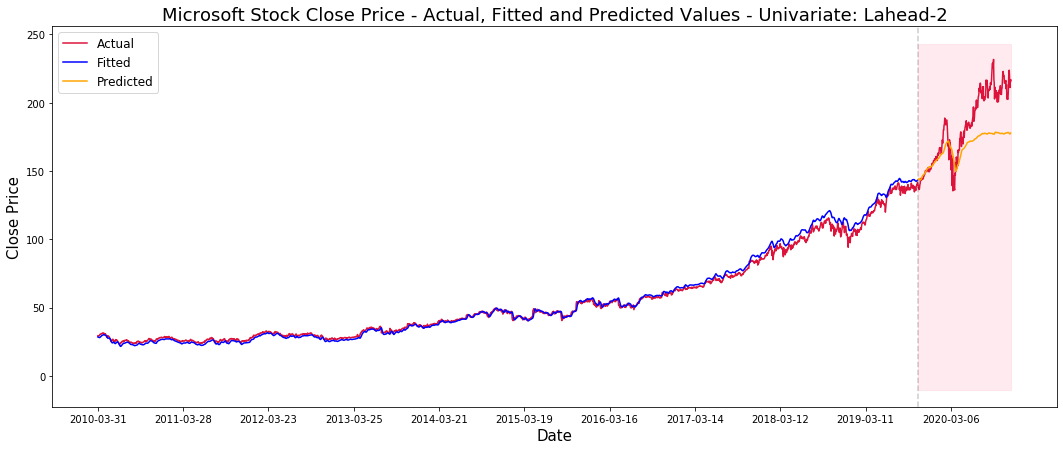

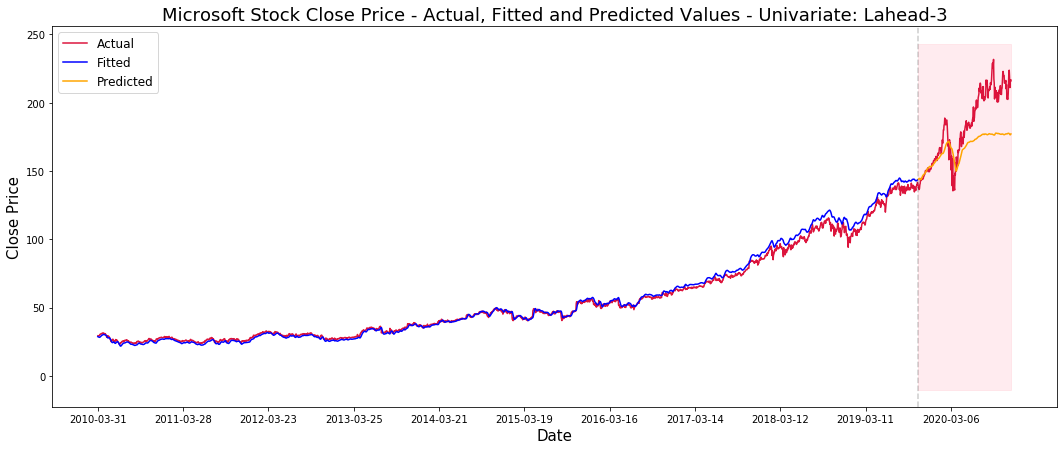

----------------------------------------------- Multivariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_20 (CuDNNLSTM)    (None, 60, 150)           93600     
_________________________________________________________________
dropout_20 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_21 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________

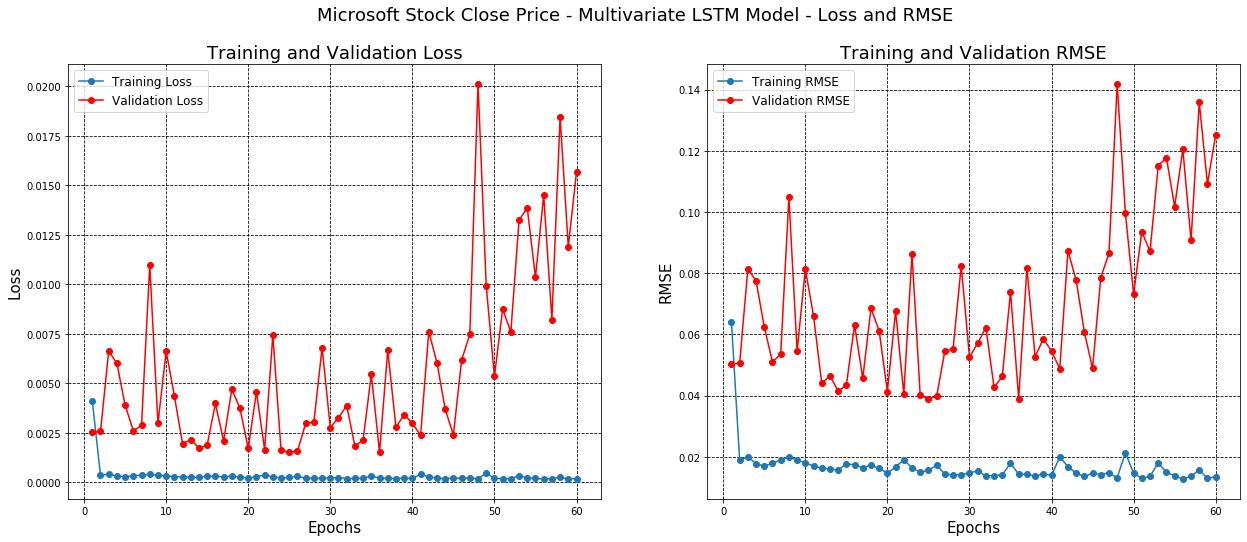

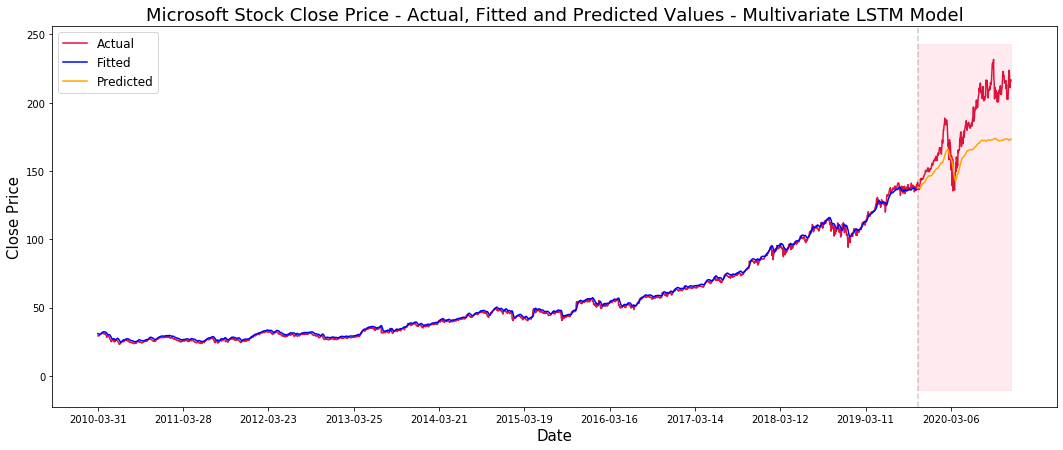


************************************************* Processing Microsoft Stock **********************************************


************************************************* Processing S&P 500 Index **********************************************

LSTM Models: Total Size: 2737 Training Size: 2403 Test Size: 274


----------------------------------------------- Univariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_24 (CuDNNLSTM)    (None, 60, 150)           91800     
_________________________________________________________________
dropout_24 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_25 (CuDNNLSTM)    (None, 60, 150)    

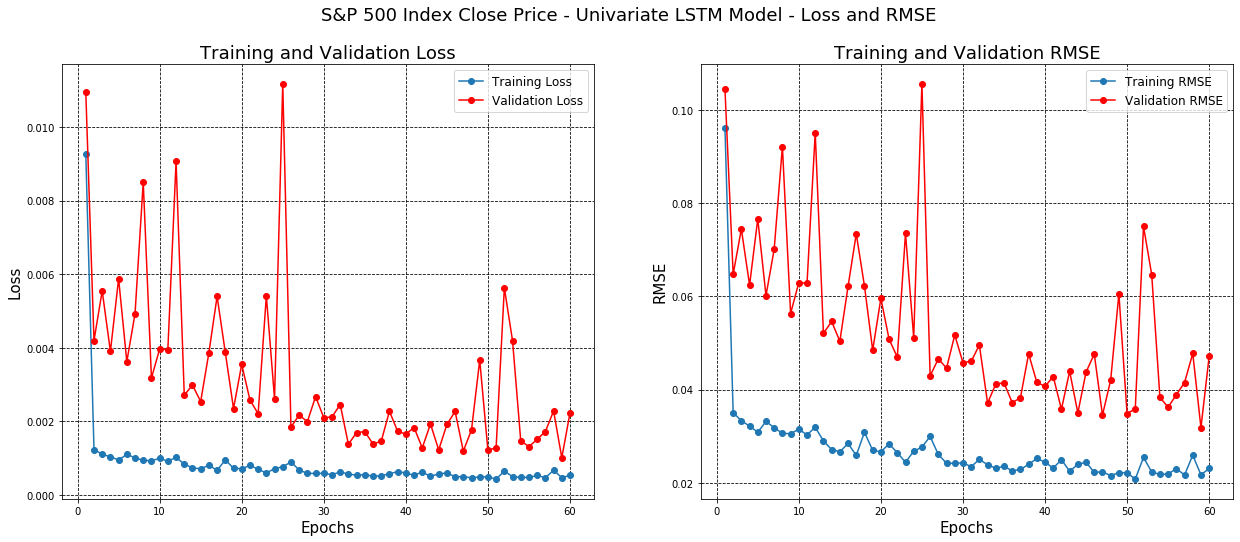

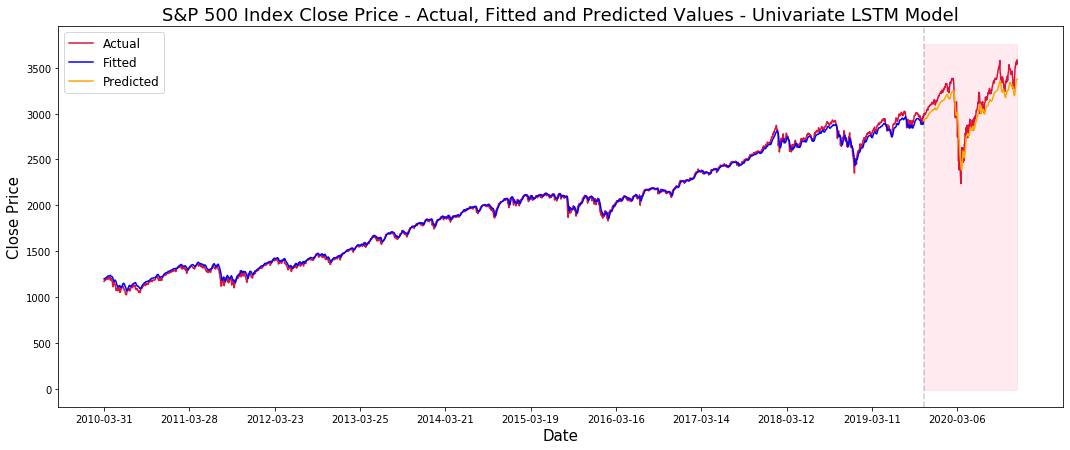

---------------------------------------- Univariate MultiDay Look ahead LSTM Model -----------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_28 (CuDNNLSTM)    (None, 60, 150)           91800     
_________________________________________________________________
dropout_28 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_29 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_29 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_30 (CuDNNLSTM)    (None, 60, 150)           181200    
______________________________

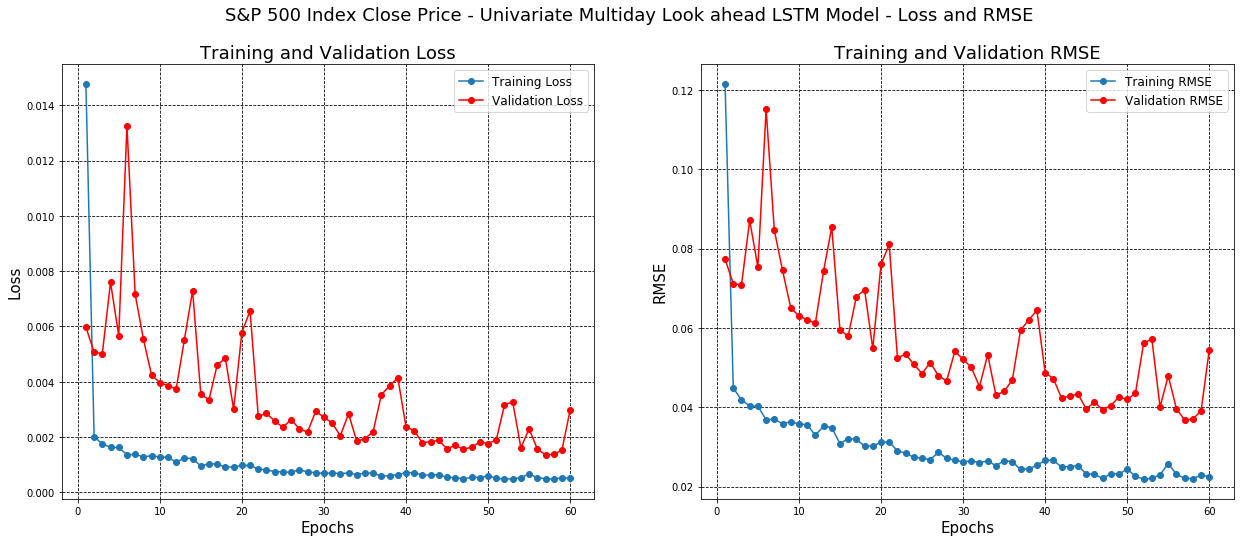

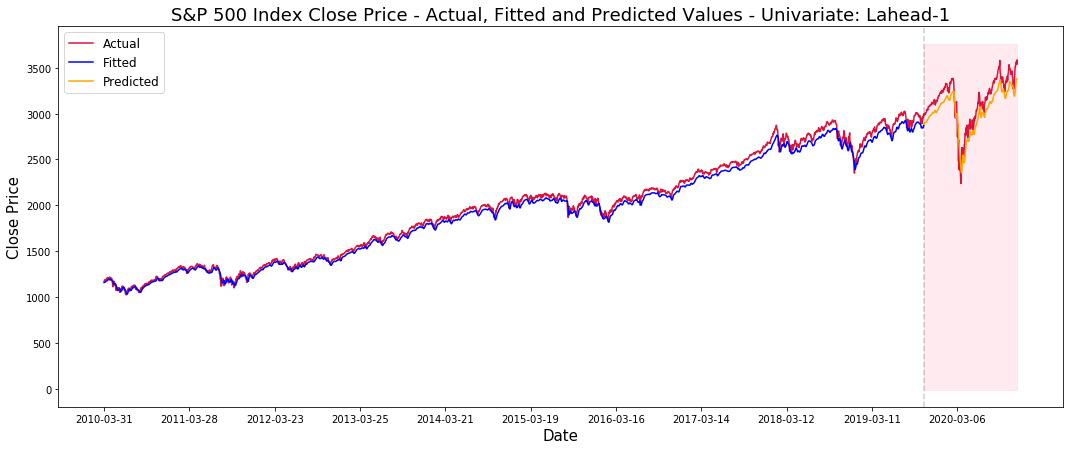

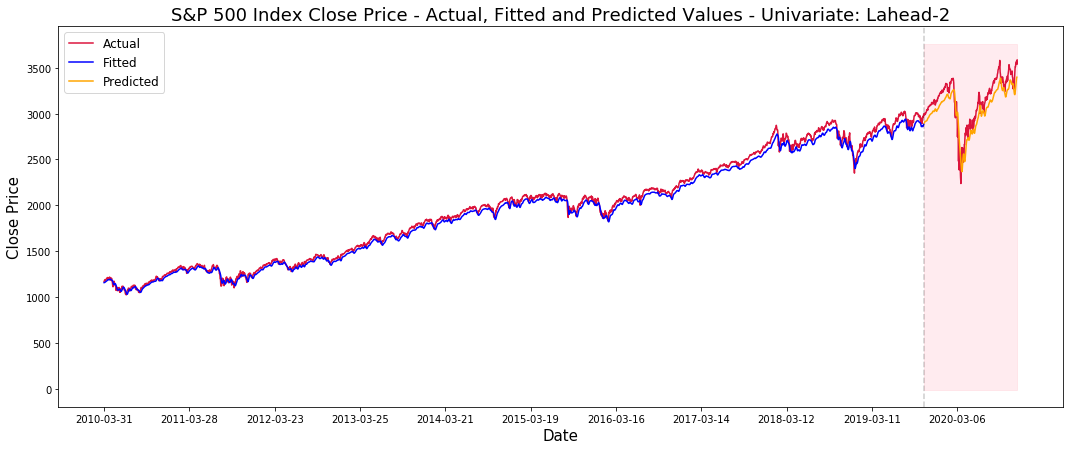

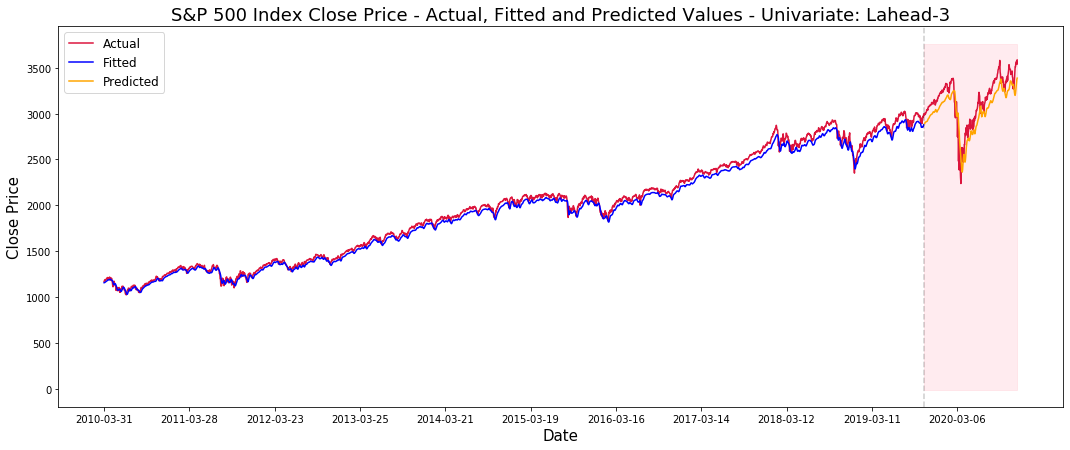

----------------------------------------------- Multivariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_32 (CuDNNLSTM)    (None, 60, 150)           93600     
_________________________________________________________________
dropout_32 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_33 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_33 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_34 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________

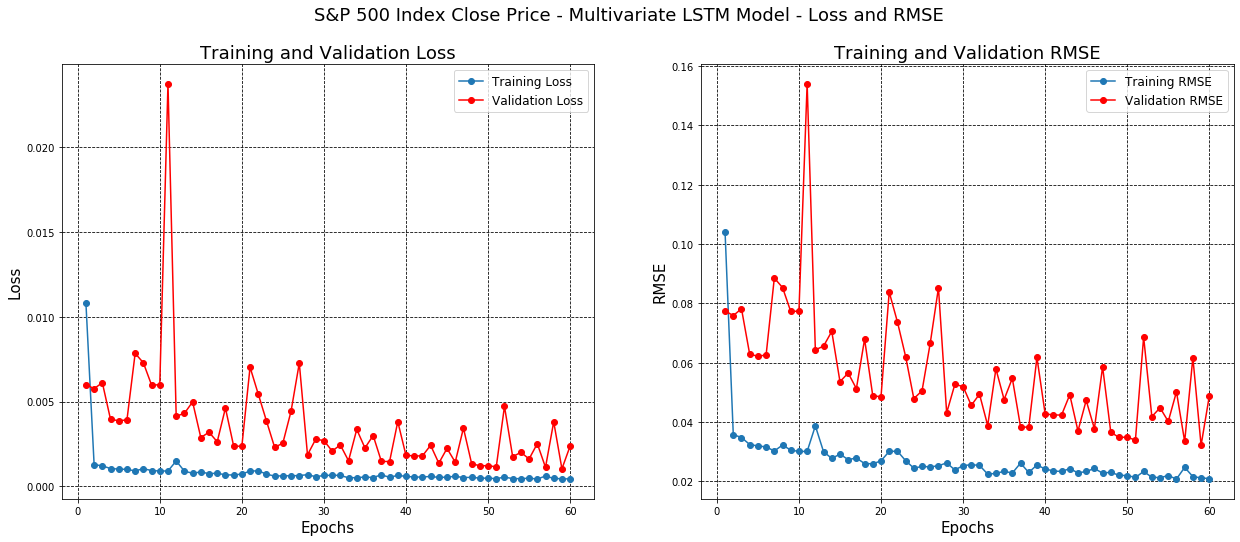

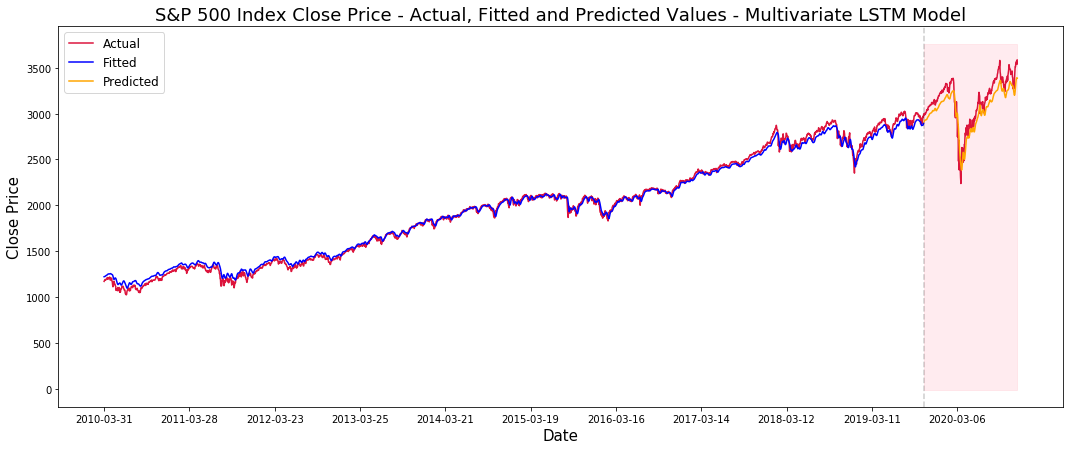


************************************************* Processing S&P 500 Index **********************************************


************************************************* Processing Nasdaq 100 Index **********************************************

LSTM Models: Total Size: 2737 Training Size: 2403 Test Size: 274


----------------------------------------------- Univariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_36 (CuDNNLSTM)    (None, 60, 150)           91800     
_________________________________________________________________
dropout_36 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_37 (CuDNNLSTM)    (None, 60, 150)   

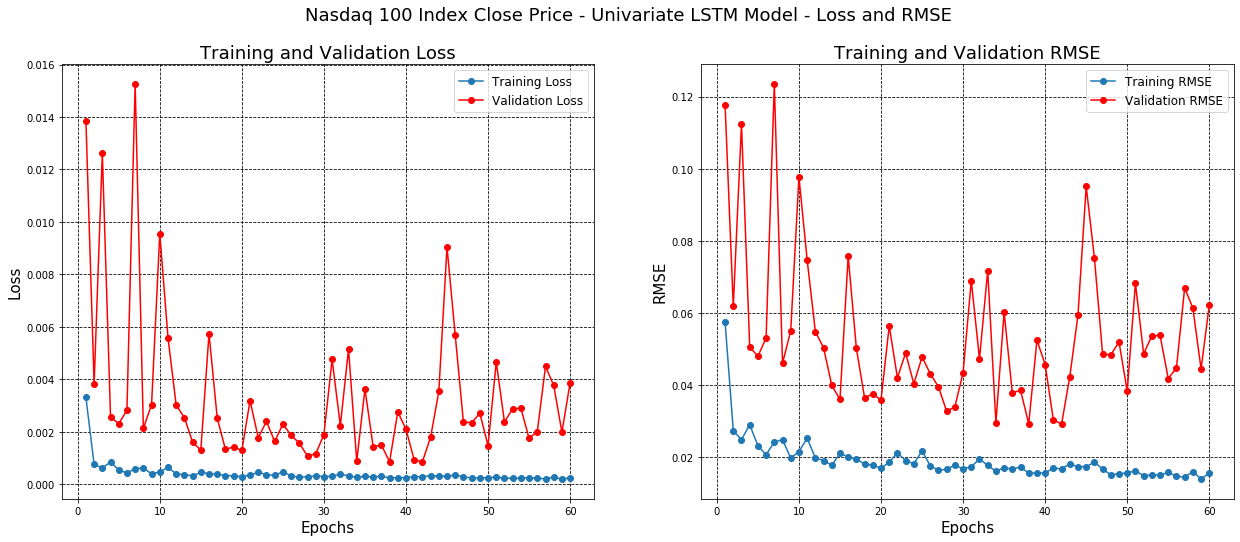

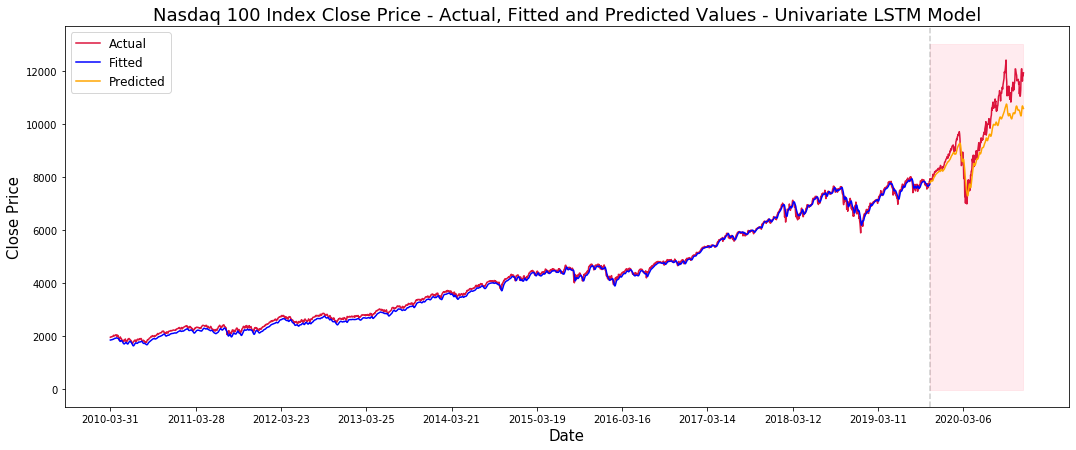

---------------------------------------- Univariate MultiDay Look ahead LSTM Model -----------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_40 (CuDNNLSTM)    (None, 60, 150)           91800     
_________________________________________________________________
dropout_40 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_41 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_41 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_42 (CuDNNLSTM)    (None, 60, 150)           181200    
_____________________________

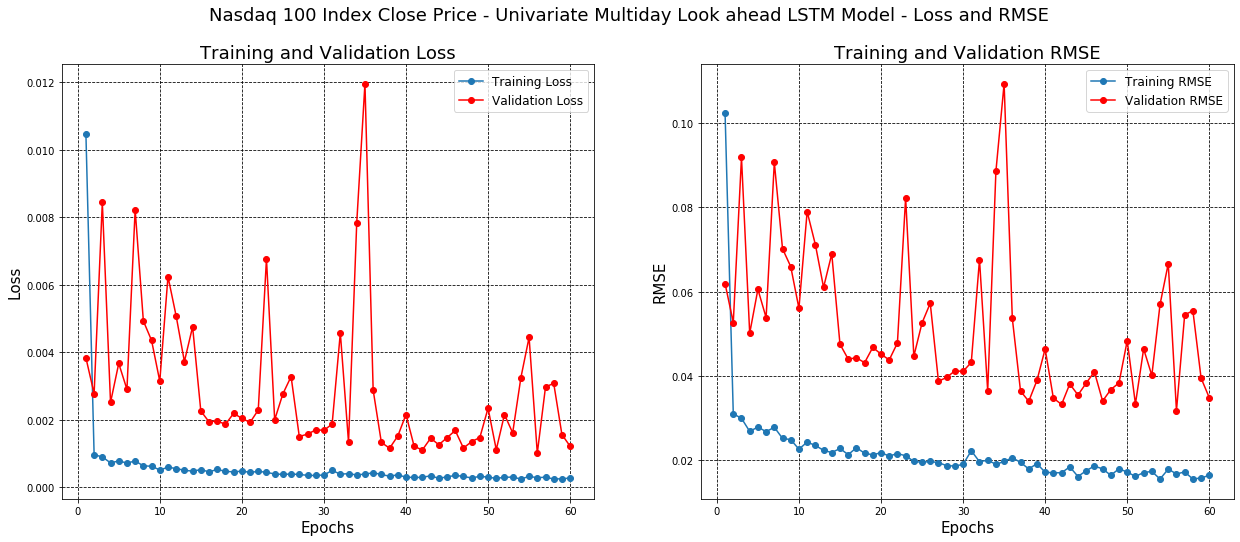

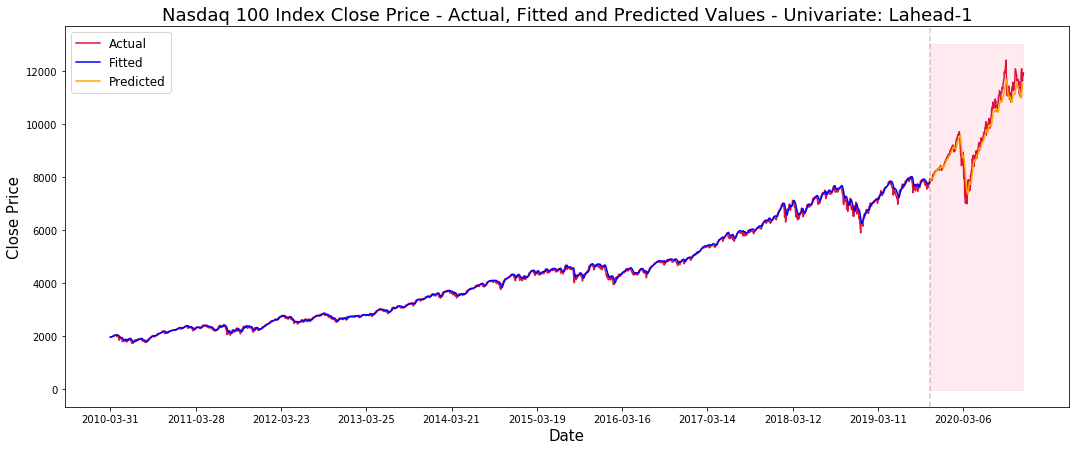

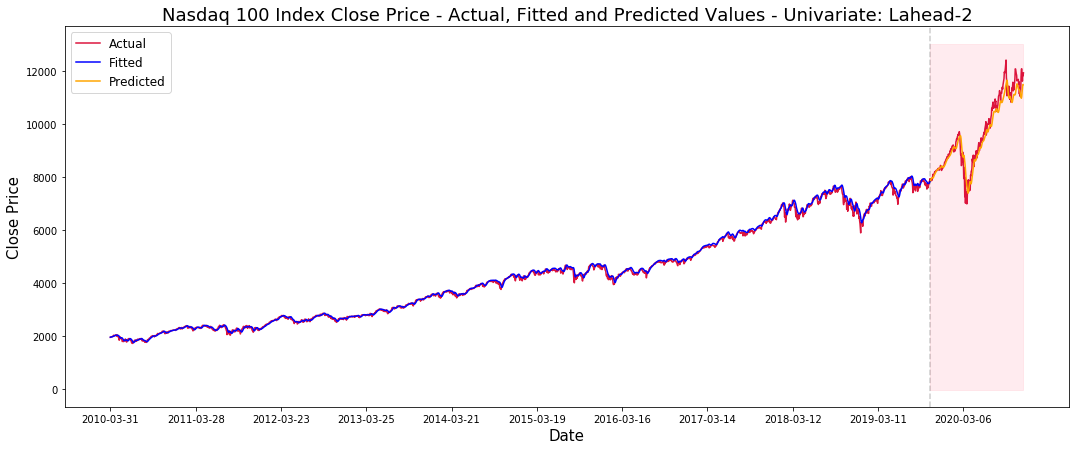

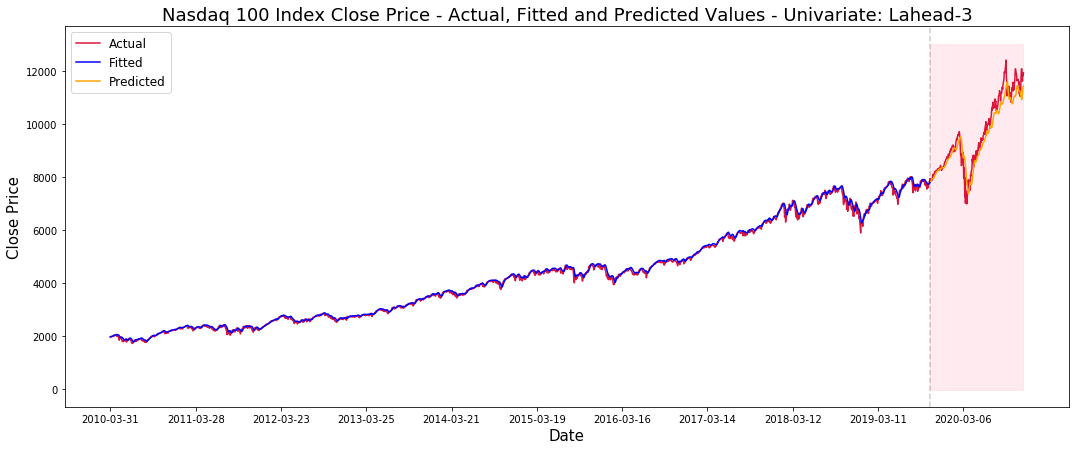

----------------------------------------------- Multivariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_44 (CuDNNLSTM)    (None, 60, 150)           93600     
_________________________________________________________________
dropout_44 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_45 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_45 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_46 (CuDNNLSTM)    (None, 60, 150)           181200    
________________________________

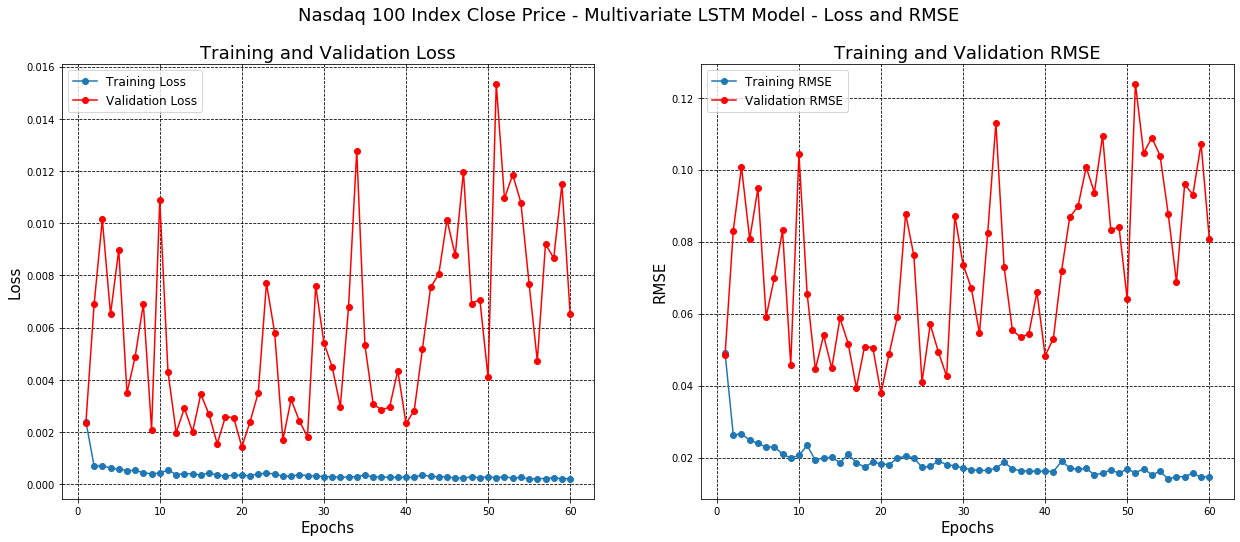

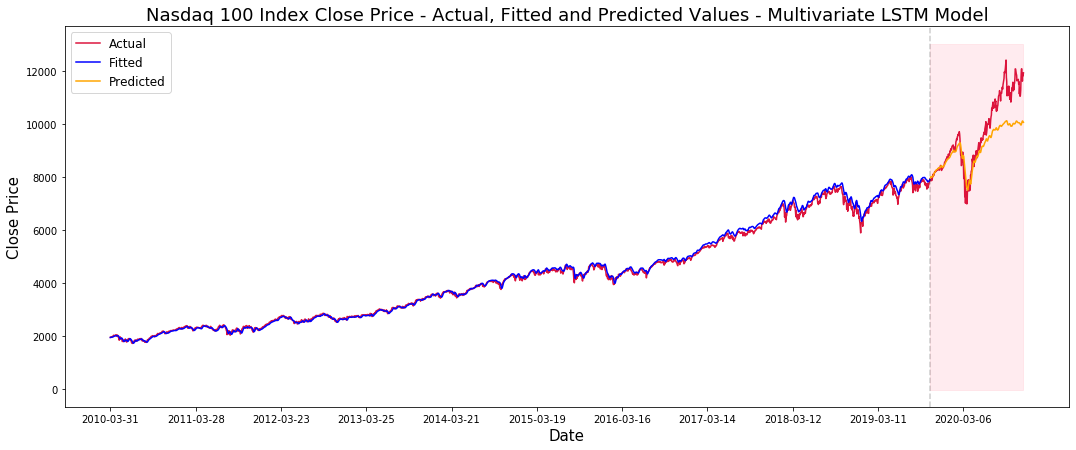


************************************************* Processing Nasdaq 100 Index **********************************************



In [19]:
# Dictionary to store the results of all the LSTM models
lstm_results = {}

# Number of past values to be used for prediction
window_size = 60

# Build and Predict Using all the LSTM Models
for security in dfs_price_scaled_lstm:
    header = header_prefix + security + header_suffix
    print(header)

    security_results = {}    
    security_mse = mse_values[security] if security in mse_values else {}

    price_scaled = dfs_price_scaled_lstm[security]
    security_scalers = scalers_lstm[security]

    total_size = len(price_scaled)

    # Compute Training and Test Set Sizes
    total_training_size = int(total_size * training_percentage)
    training_size = total_training_size - window_size
    test_size = total_size - total_training_size

    # Print Training and Test Set Sizes
    print("LSTM Models: Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)
    print('\n')
    
    model, dates, actual, predictions, mse = univariate_model(price_scaled, security_scalers, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse

    model, dates, actual, predictions, mse  = univariate_multiday_model(price_scaled,
                                                                        security_scalers,
                                                                        security,
                                                                        price_type)
    for i in range(1, len(model)):
        security_results[model[i]] = dates[:, i], actual[:, i], predictions[:, i]
        security_mse[model[i]] = mse[i]

    model, dates, actual, predictions, mse  = multivariate_model(price_scaled, security_scalers, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse

    lstm_results[security] = security_results
    mse_values[security] = security_mse

    footer = footer_prefix + security + footer_suffix
    print(header)

### Display Price Prediction of all the LSTM Models

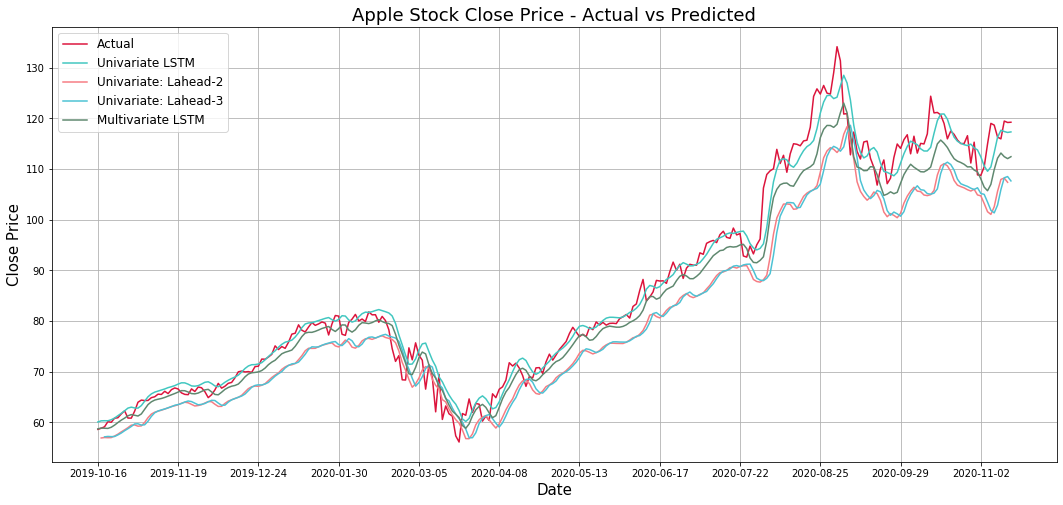

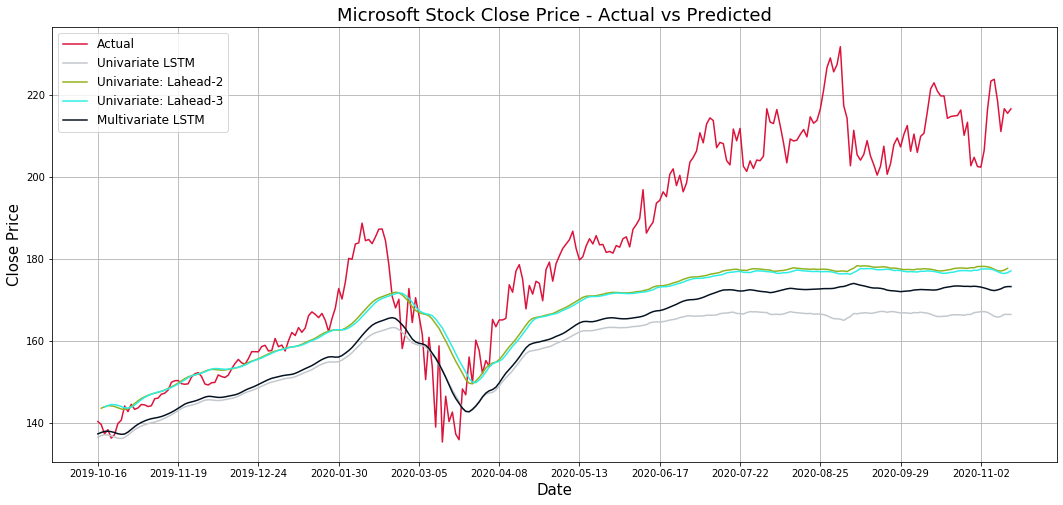

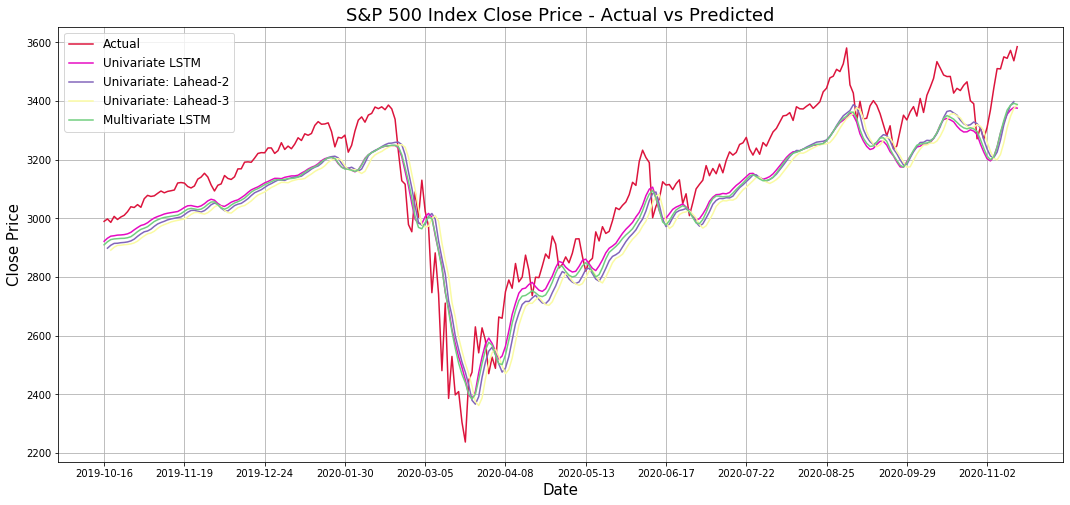

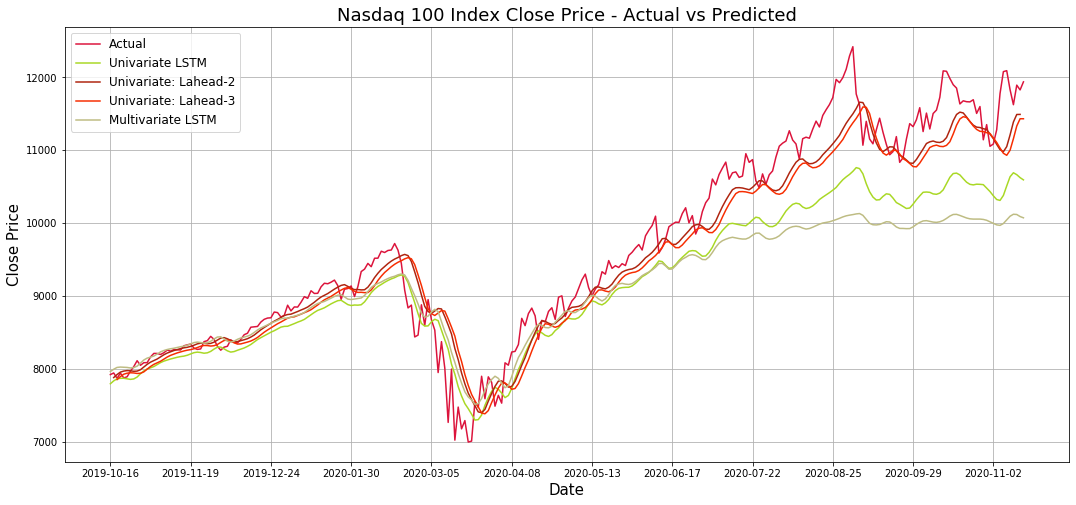

In [20]:
for security, security_results in lstm_results.items():
    actual_displayed = False
    model_list = []

    plt.figure(figsize=(18, 8))
    for model, model_results in security_results.items():
        dates, actual, predictions = model_results
        model_list.append(model)
        if not actual_displayed:
            plt.plot(dates, actual, "-", color='crimson', label='Actual')
            actual_displayed = True

        plt.plot(dates, predictions, "-", color=np.random.rand(3,), label=model)

    plt.title(security + " " + price_type + " Price - Actual vs Predicted", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price", fontsize=15)
    plt.xticks(dates[::24])
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show();

# Performance Comparison of all the models

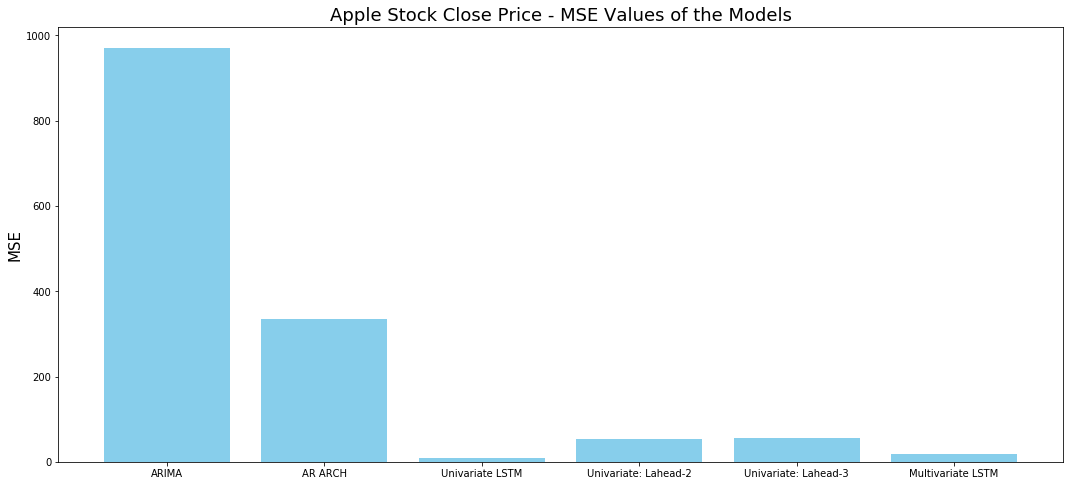

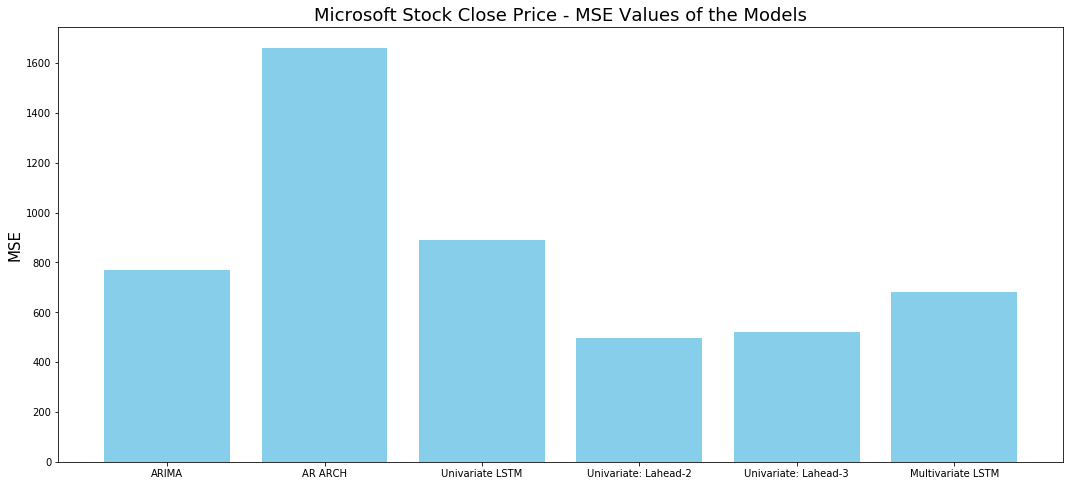

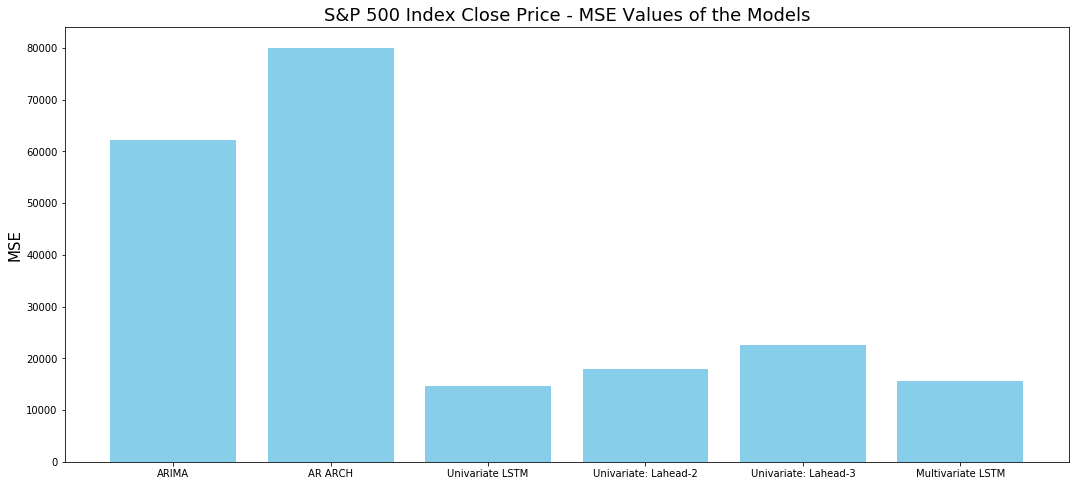

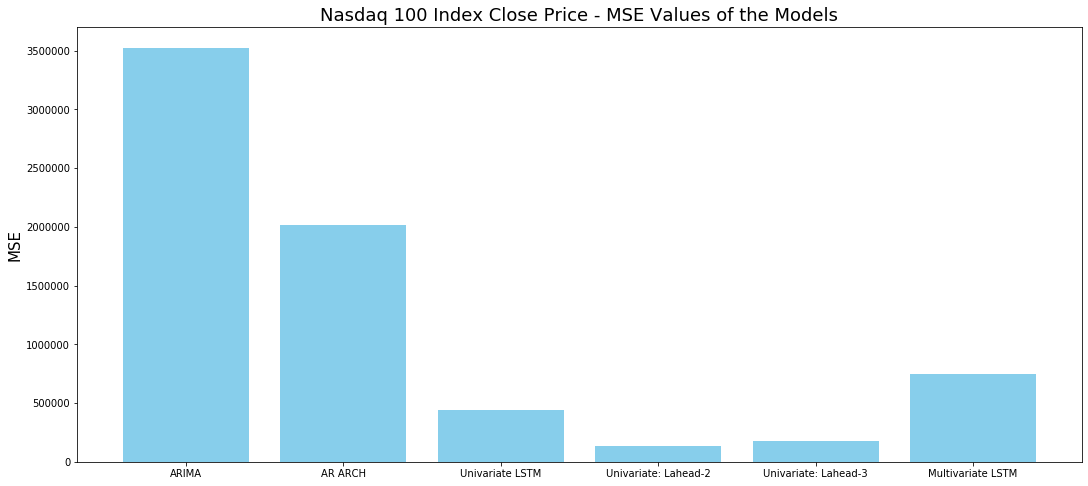

In [21]:
for security, security_results in mse_values.items():
    plt.figure(figsize=(18, 8))
    plt.bar(security_results.keys(), list(security_results.values()), color='skyblue')  
    plt.title(security + " " + price_type + " Price - MSE Values of the Models", fontsize=18)
    plt.ylabel("MSE", fontsize=15)
    plt.show();

In [25]:
for security, security_results in mse_values.items():
    print("MSE Value of the Models for", security, ":\n")
    for model in security_results:
        print(model, "{:.2f}".format(security_results[model]))
    print("\n")

MSE Value of the Models for Apple Stock :

ARIMA 971.49
AR ARCH 333.98
Univariate LSTM 8.92
Univariate: Lahead-2 53.02
Univariate: Lahead-3 55.99
Multivariate LSTM 17.25


MSE Value of the Models for Microsoft Stock :

ARIMA 768.08
AR ARCH 1661.67
Univariate LSTM 888.17
Univariate: Lahead-2 496.92
Univariate: Lahead-3 522.28
Multivariate LSTM 682.56


MSE Value of the Models for S&P 500 Index :

ARIMA 62221.84
AR ARCH 80027.24
Univariate LSTM 14612.05
Univariate: Lahead-2 17848.40
Univariate: Lahead-3 22604.68
Multivariate LSTM 15611.84


MSE Value of the Models for Nasdaq 100 Index :

ARIMA 3524689.79
AR ARCH 2018721.74
Univariate LSTM 442694.88
Univariate: Lahead-2 133750.17
Univariate: Lahead-3 180206.13
Multivariate LSTM 746229.73


